In [1]:
import sys, os
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
print("PyTorch:", torch.__version__)
print(torch.version.cuda)   # shows the CUDA version PyTorch was built against
print(torch.backends.cudnn.version())  # cuDNN version
print(torch.cuda.is_available())

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /work3/s232958/envs/esm_gpu/bin/python
PyTorch: 2.5.1
12.1
90100
True
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [2]:
os.listdir("/work3/s232958/data/")

['pretrained',
 'RAEL.pdb',
 'PDB_files',
 'meta_analysis',
 'PPint_DB',
 'swissprot_human_proteome',
 '.ipynb_checkpoints']

In [3]:
# Load metaanalayis data
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/source_data.csv")
interaction_df = interaction_df[(interaction_df["A_seq"].notna())& (interaction_df["B_seq"].notna())].reset_index(drop=True)
interaction_df = interaction_df[interaction_df["target_chains"] == "[\"B\"]"]
interaction_df = interaction_df[interaction_df["B_seq"].notna()].reset_index(drop=True)
cols_remain = ["binder_id", "target_id", "binder_chain", "target_chains", "binder", "A_seq", "B_seq"]
interaction_df = interaction_df[cols_remain]
# interaction_df = interaction_df.drop(columns=["binder_chain", "target_chains"])

interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...


In [40]:
# No NaN target_id rows
print(f"{len(interaction_df[interaction_df.target_id.isna() == True])} entries with 'target_id' nan")
interaction_df[interaction_df.target_id.isna() == True]

x = interaction_df["target_id"].unique()
print(f"{len(x)} different targets, which are: {x}")

x = interaction_df[interaction_df["target_id"] == "EGFR"]["B_seq"].unique()
print(f"Target 'EGFR' has {len(x)} unique sequences.")

0 entries with 'target_id' nan
13 different targets, which are: ['VirB8' 'FGFR2' 'IL7Ra' 'InsulinR' 'EGFR' 'SARS_CoV2_RBD' 'Pdl1' 'TrkA'
 'IL10Ra' 'LTK' 'Mdm2' 'sntx' 'IL2Ra']
Target 'EGFR' has 3 unique sequences.


In [41]:
print(f"Tagets and number of diff sequences for each:")
for i in interaction_df["target_id"].unique():
    x = interaction_df[interaction_df["target_id"] == i]["B_seq"].unique()
    print(i, len(x))

Tagets and number of diff sequences for each:
VirB8 1
FGFR2 1
IL7Ra 1
InsulinR 1
EGFR 3
SARS_CoV2_RBD 1
Pdl1 1
TrkA 1
IL10Ra 1
LTK 1
Mdm2 1
sntx 2
IL2Ra 1


In [42]:
dfu = interaction_df.drop_duplicates(["target_id", "B_seq"])
dfu[dfu.target_id == "EGFR"].B_seq.tolist()
targets_Dict, target_tracking = {}, {target:int(2) for target in dfu.target_id.unique()}
target_tracking

{'VirB8': 2,
 'FGFR2': 2,
 'IL7Ra': 2,
 'InsulinR': 2,
 'EGFR': 2,
 'SARS_CoV2_RBD': 2,
 'Pdl1': 2,
 'TrkA': 2,
 'IL10Ra': 2,
 'LTK': 2,
 'Mdm2': 2,
 'sntx': 2,
 'IL2Ra': 2}

In [43]:
for idx, target_id in enumerate(dfu.target_id):
    if target_id not in targets_Dict.keys():
        targets_Dict[target_id] = dfu.iloc[idx]["B_seq"]
        print(target_id)
    else:
        target_id_new = f"{target_id}_{target_tracking[target_id]}"
        targets_Dict[target_id_new] = dfu.iloc[idx]["B_seq"]
        count = target_tracking[target_id]
        target_tracking[target_id] = count + 1
        print(target_id_new)

VirB8
FGFR2
IL7Ra
InsulinR
EGFR
SARS_CoV2_RBD
Pdl1
EGFR_2
TrkA
IL10Ra
LTK
Mdm2
EGFR_3
sntx
sntx_2
IL2Ra


In [44]:
interaction_df['target_id_mod'] = interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
print(targets_Dict.keys())
print(f"Entries wheere 'target_id_mod' is NA: {len(interaction_df[interaction_df.target_id_mod.isna() == True])}")

dict_keys(['VirB8', 'FGFR2', 'IL7Ra', 'InsulinR', 'EGFR', 'SARS_CoV2_RBD', 'Pdl1', 'EGFR_2', 'TrkA', 'IL10Ra', 'LTK', 'Mdm2', 'EGFR_3', 'sntx', 'sntx_2', 'IL2Ra'])
Entries wheere 'target_id_mod' is NA: 0


In [45]:
interaction_df[interaction_df.target_id_mod == "EGFR_3"]

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod
1130,nside_mot_359448c81ec7171dd466f2d64631b9c5_000...,EGFR,A,"[""B""]",True,DDESLKLLLILVQIQLALERGEISNDQAKELAKRVEEKARKLGDEQ...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
1516,nside_mot_4a0b58da0a66d934d1bcaa80596e03bc_000...,EGFR,A,"[""B""]",True,DHWEEVFRWALELLQEATEQNDPTKAKKILEEAHKLLRRELSEEEA...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
2268,nside_mot_33a3a00fc629d06a96f91cefd1c5e1ea_000...,EGFR,A,"[""B""]",True,PLEEVKKVVEEALKDDPELVRAVKTIIEAVKKGENDPIFLELLLRL...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
2634,nside_mot_4baece34555bc5def11fd3c4c5db93f5_000...,EGFR,A,"[""B""]",True,DEAAEEVLRYLKKLGDPELAELIERLLERVRKKKDPDLERTLEIIA...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3


In [46]:
cnt = interaction_df.groupby('target_id_mod').cumcount() + 1
interaction_df['target_binder_ID'] = interaction_df['target_id_mod'].astype(str) + '_' + cnt.astype(str)
interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod,target_binder_ID
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4
...,...,...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65


In [47]:
interaction_df.binder.value_counts()

binder
False    3141
True      391
Name: count, dtype: int64

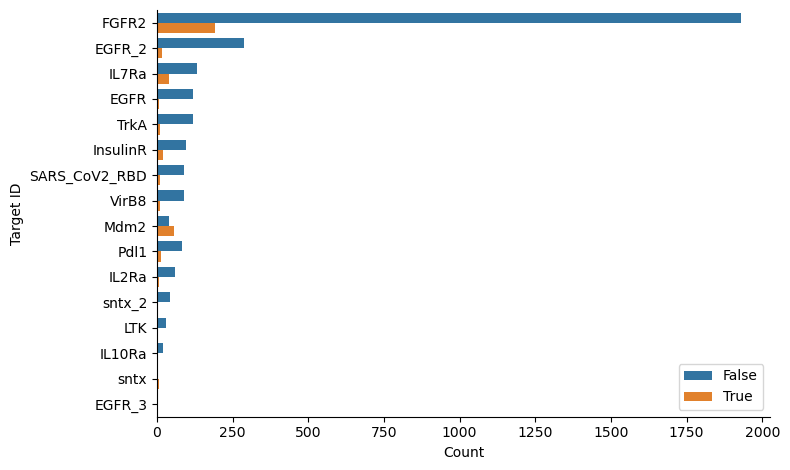

In [48]:
interaction_df.target_id_mod.value_counts()

order = interaction_df['target_id_mod'].value_counts().index

plt.figure(figsize=(8, 0.3 * len(order)))
ax = sns.countplot(
    data=interaction_df,
    y='target_id_mod',
    order=order,
    hue = "binder"
)
ax.set_xlabel('Count')
ax.set_ylabel('Target ID')
ax.legend(loc='lower right')  
sns.despine()
plt.tight_layout()
plt.show()

In [49]:
binders_Dict = {}
for idx, binder_id in enumerate(interaction_df.target_binder_ID):
    if binder_id not in binders_Dict.keys():
        binders_Dict[binder_id] = interaction_df.iloc[idx]["A_seq"]
    else:
        print("Something is off..")
        print(binder_id, interaction_df.iloc[idx]["A_seq"])

In [50]:
# Save modified interaction_df
interaction_df.to_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv", index = False)

In [51]:
ckpt_path = "/work3/s232958/huggingface/hub/models--EvolutionaryScale--esmc-600m-2024-12/blobs/data/weights/esmc_600m_2024_12_v0.pth"

model = ESMC(
    d_model=1152,
    n_heads=18,
    n_layers=36,
    tokenizer=get_esmc_model_tokenizers()
).eval()

state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict)

model = model.to("cuda")  # ready to use on GPU

/work3/s232958/tmp/ipykernel_125412/908899384.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location="cpu")


In [52]:
def calculate_ESM_pr_res_embeddings(sequence):
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    logits_output = model.logits(
    protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
    )
    return logits_output.embeddings.detach().cpu().numpy()

# Test run
sequence = "AAAAAAA"
embedding = calculate_ESM_pr_res_embeddings(sequence)
embedding.shape

(1, 9, 1152)

In [53]:
# where to save
path_to_output_embeddings = "/work3/s232958/data/meta_analysis/targets_embeddings_esmC"
os.makedirs(path_to_output_embeddings, exist_ok=True)

# helper: convert torch tensor to numpy
def to_numpy(x):
    try:
        return x.detach().cpu().numpy()
    except AttributeError:
        return np.asarray(x)

# iterate targets
for name, seqs in tqdm(targets_Dict.items(), total=len(targets_Dict), desc="Embedding targets"):
    emb = calculate_ESM_pr_res_embeddings(seqs)
    emb_np = to_numpy(emb)
    out_path = os.path.join(path_to_output_embeddings, f"{name}.npy")
    np.save(out_path, emb_np)
    print(f"Target {name} embedded and saved to {out_path}")

# Count files in the 
# path_to_output_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"
if len(os.listdir(path_to_output_embeddings)) == len(targets_Dict.keys()):
    print("All targets!")

Embedding targets:  12%|███████████▋                                                                                 | 2/16 [00:00<00:01, 12.51it/s]

Target VirB8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/VirB8.npy
Target FGFR2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/FGFR2.npy
Target IL7Ra embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/IL7Ra.npy


Embedding targets:  38%|██████████████████████████████████▉                                                          | 6/16 [00:00<00:00, 12.29it/s]

Target InsulinR embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/InsulinR.npy
Target EGFR embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/EGFR.npy
Target SARS_CoV2_RBD embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/SARS_CoV2_RBD.npy


Embedding targets:  50%|██████████████████████████████████████████████▌                                              | 8/16 [00:00<00:00, 10.75it/s]

Target Pdl1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/Pdl1.npy
Target EGFR_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/EGFR_2.npy


Embedding targets:  62%|█████████████████████████████████████████████████████████▌                                  | 10/16 [00:00<00:00, 11.62it/s]

Target TrkA embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/TrkA.npy
Target IL10Ra embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/IL10Ra.npy
Target LTK embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/LTK.npy


Embedding targets:  88%|████████████████████████████████████████████████████████████████████████████████▌           | 14/16 [00:01<00:00, 12.74it/s]

Target Mdm2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/Mdm2.npy
Target EGFR_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/EGFR_3.npy
Target sntx embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/sntx.npy
Target sntx_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/sntx_2.npy


Embedding targets: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.45it/s]

Target IL2Ra embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings/IL2Ra.npy
All targets!


In [54]:
# where to save
path_to_output_embeddings = "/work3/s232958/data/meta_analysis/binders_embeddings_esmC"
os.makedirs(path_to_output_embeddings, exist_ok=True)

# iterate targets
for name, seqs in tqdm(binders_Dict.items(), total=len(binders_Dict), desc="Embedding binders"):
    emb = calculate_ESM_pr_res_embeddings(seqs)
    emb_np = to_numpy(emb)
    out_path = os.path.join(path_to_output_embeddings, f"{name}.npy")
    np.save(out_path, emb_np)
    print(f"Binder {name} embedded and saved to {out_path}")

# Count files in the 
# path_to_output_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
if len(os.listdir(path_to_output_embeddings)) == len(binders_Dict.keys()):
    print("All binders!")

Embedding binders:   0%|                                                                                           | 2/3532 [00:00<04:03, 14.50it/s]

Binder VirB8_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_1.npy
Binder FGFR2_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1.npy
Binder FGFR2_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2.npy


Embedding binders:   0%|▏                                                                                          | 6/3532 [00:00<03:55, 14.96it/s]

Binder FGFR2_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_3.npy
Binder FGFR2_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_4.npy
Binder FGFR2_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_5.npy
Binder FGFR2_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_6.npy


Embedding binders:   0%|▎                                                                                         | 10/3532 [00:00<03:43, 15.73it/s]

Binder FGFR2_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_7.npy
Binder FGFR2_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_8.npy
Binder FGFR2_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_9.npy
Binder FGFR2_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_10.npy


Embedding binders:   0%|▎                                                                                         | 14/3532 [00:00<03:39, 16.00it/s]

Binder FGFR2_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_11.npy
Binder FGFR2_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_12.npy
Binder FGFR2_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_13.npy
Binder FGFR2_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_14.npy


Embedding binders:   1%|▍                                                                                         | 18/3532 [00:01<03:38, 16.09it/s]

Binder FGFR2_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_15.npy
Binder FGFR2_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_16.npy
Binder FGFR2_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_17.npy
Binder IL7Ra_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_1.npy


Embedding binders:   1%|▌                                                                                         | 22/3532 [00:01<03:40, 15.89it/s]

Binder IL7Ra_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_2.npy
Binder IL7Ra_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_3.npy
Binder IL7Ra_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_4.npy
Binder IL7Ra_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_5.npy


Embedding binders:   1%|▋                                                                                         | 26/3532 [00:01<03:40, 15.92it/s]

Binder IL7Ra_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_6.npy
Binder IL7Ra_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_7.npy
Binder InsulinR_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_1.npy
Binder InsulinR_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_2.npy


Embedding binders:   1%|▊                                                                                         | 30/3532 [00:01<03:41, 15.80it/s]

Binder InsulinR_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_3.npy
Binder InsulinR_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_4.npy
Binder InsulinR_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_5.npy
Binder InsulinR_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_6.npy


Embedding binders:   1%|▊                                                                                         | 34/3532 [00:02<03:39, 15.93it/s]

Binder InsulinR_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_7.npy
Binder FGFR2_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_18.npy
Binder FGFR2_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_19.npy
Binder FGFR2_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_20.npy


Embedding binders:   1%|▉                                                                                         | 38/3532 [00:02<03:37, 16.04it/s]

Binder FGFR2_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_21.npy
Binder FGFR2_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_22.npy
Binder FGFR2_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_23.npy
Binder FGFR2_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_24.npy


Embedding binders:   1%|█                                                                                         | 42/3532 [00:02<03:36, 16.12it/s]

Binder FGFR2_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_25.npy
Binder EGFR_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_1.npy
Binder EGFR_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2.npy
Binder SARS_CoV2_RBD_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_1.npy


Embedding binders:   1%|█▏                                                                                        | 46/3532 [00:02<03:35, 16.16it/s]

Binder FGFR2_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_26.npy
Binder EGFR_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_3.npy
Binder FGFR2_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_27.npy
Binder FGFR2_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_28.npy


Embedding binders:   1%|█▎                                                                                        | 50/3532 [00:03<03:34, 16.24it/s]

Binder EGFR_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_4.npy
Binder EGFR_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_5.npy
Binder EGFR_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_6.npy
Binder SARS_CoV2_RBD_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_2.npy


Embedding binders:   2%|█▍                                                                                        | 54/3532 [00:03<03:34, 16.18it/s]

Binder FGFR2_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_29.npy
Binder FGFR2_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_30.npy
Binder FGFR2_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_31.npy
Binder FGFR2_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_32.npy


Embedding binders:   2%|█▍                                                                                        | 58/3532 [00:03<03:33, 16.28it/s]

Binder FGFR2_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_33.npy
Binder FGFR2_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_34.npy
Binder FGFR2_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_35.npy
Binder FGFR2_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_36.npy


Embedding binders:   2%|█▌                                                                                        | 62/3532 [00:03<03:33, 16.23it/s]

Binder FGFR2_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_37.npy
Binder FGFR2_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_38.npy
Binder FGFR2_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_39.npy
Binder FGFR2_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_40.npy


Embedding binders:   2%|█▋                                                                                        | 66/3532 [00:04<03:34, 16.19it/s]

Binder FGFR2_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_41.npy
Binder FGFR2_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_42.npy
Binder FGFR2_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_43.npy
Binder FGFR2_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_44.npy


Embedding binders:   2%|█▊                                                                                        | 70/3532 [00:04<03:32, 16.26it/s]

Binder FGFR2_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_45.npy
Binder FGFR2_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_46.npy
Binder FGFR2_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_47.npy
Binder FGFR2_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_48.npy


Embedding binders:   2%|█▉                                                                                        | 74/3532 [00:04<03:33, 16.23it/s]

Binder FGFR2_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_49.npy
Binder FGFR2_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_50.npy
Binder FGFR2_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_51.npy
Binder FGFR2_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_52.npy


Embedding binders:   2%|█▉                                                                                        | 78/3532 [00:04<03:32, 16.27it/s]

Binder FGFR2_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_53.npy
Binder FGFR2_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_54.npy
Binder SARS_CoV2_RBD_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_3.npy
Binder SARS_CoV2_RBD_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_4.npy


Embedding binders:   2%|██                                                                                        | 82/3532 [00:05<03:33, 16.16it/s]

Binder SARS_CoV2_RBD_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_5.npy
Binder SARS_CoV2_RBD_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_6.npy
Binder Pdl1_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_1.npy
Binder Pdl1_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_2.npy


Embedding binders:   2%|██▏                                                                                       | 86/3532 [00:05<03:37, 15.82it/s]

Binder Pdl1_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_3.npy
Binder Pdl1_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_4.npy
Binder Pdl1_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_5.npy
Binder Pdl1_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_6.npy


Embedding binders:   3%|██▎                                                                                       | 90/3532 [00:05<03:36, 15.87it/s]

Binder EGFR_2_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_1.npy
Binder TrkA_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_1.npy
Binder TrkA_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_2.npy
Binder TrkA_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_3.npy


Embedding binders:   3%|██▍                                                                                       | 94/3532 [00:05<03:36, 15.87it/s]

Binder TrkA_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_4.npy
Binder TrkA_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_5.npy
Binder TrkA_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_6.npy
Binder TrkA_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_7.npy


Embedding binders:   3%|██▍                                                                                       | 98/3532 [00:06<03:51, 14.85it/s]

Binder EGFR_2_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_2.npy
Binder EGFR_2_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_3.npy
Binder TrkA_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_8.npy


Embedding binders:   3%|██▌                                                                                      | 102/3532 [00:06<03:47, 15.10it/s]

Binder IL7Ra_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_8.npy
Binder EGFR_2_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_4.npy
Binder EGFR_2_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_5.npy
Binder EGFR_2_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_6.npy


Embedding binders:   3%|██▋                                                                                      | 106/3532 [00:06<03:40, 15.52it/s]

Binder EGFR_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_7.npy
Binder EGFR_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_8.npy
Binder VirB8_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_2.npy
Binder VirB8_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_3.npy


Embedding binders:   3%|██▋                                                                                      | 108/3532 [00:06<03:39, 15.58it/s]

Binder VirB8_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_4.npy
Binder FGFR2_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_55.npy
Binder EGFR_2_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_7.npy
Binder EGFR_2_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_8.npy


Embedding binders:   3%|██▊                                                                                      | 112/3532 [00:07<03:40, 15.51it/s]

Binder IL10Ra_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_1.npy
Binder IL10Ra_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_2.npy
Binder EGFR_2_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_9.npy


Embedding binders:   3%|██▉                                                                                      | 116/3532 [00:07<03:49, 14.92it/s]

Binder EGFR_2_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_10.npy
Binder EGFR_2_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_11.npy
Binder IL7Ra_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_9.npy
Binder IL7Ra_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_10.npy


Embedding binders:   3%|███                                                                                      | 120/3532 [00:07<03:39, 15.52it/s]

Binder LTK_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_1.npy
Binder LTK_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_2.npy
Binder FGFR2_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_56.npy
Binder FGFR2_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_57.npy


Embedding binders:   4%|███                                                                                      | 124/3532 [00:07<03:36, 15.73it/s]

Binder FGFR2_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_58.npy
Binder FGFR2_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_59.npy
Binder FGFR2_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_60.npy
Binder FGFR2_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_61.npy


Embedding binders:   4%|███▏                                                                                     | 128/3532 [00:08<03:34, 15.86it/s]

Binder FGFR2_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_62.npy
Binder FGFR2_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_63.npy
Binder FGFR2_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_64.npy
Binder FGFR2_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_65.npy


Embedding binders:   4%|███▎                                                                                     | 132/3532 [00:08<03:37, 15.60it/s]

Binder FGFR2_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_66.npy
Binder FGFR2_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_67.npy
Binder FGFR2_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_68.npy
Binder FGFR2_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_69.npy


Embedding binders:   4%|███▍                                                                                     | 136/3532 [00:08<03:34, 15.82it/s]

Binder FGFR2_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_70.npy
Binder FGFR2_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_71.npy
Binder FGFR2_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_72.npy
Binder FGFR2_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_73.npy


Embedding binders:   4%|███▌                                                                                     | 140/3532 [00:08<03:33, 15.85it/s]

Binder FGFR2_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_74.npy
Binder FGFR2_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_75.npy
Binder FGFR2_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_76.npy
Binder FGFR2_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_77.npy


Embedding binders:   4%|███▋                                                                                     | 144/3532 [00:09<03:36, 15.65it/s]

Binder FGFR2_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_78.npy
Binder FGFR2_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_79.npy
Binder FGFR2_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_80.npy
Binder FGFR2_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_81.npy


Embedding binders:   4%|███▋                                                                                     | 148/3532 [00:09<03:40, 15.33it/s]

Binder FGFR2_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_82.npy
Binder FGFR2_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_83.npy
Binder FGFR2_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_84.npy
Binder FGFR2_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_85.npy


Embedding binders:   4%|███▊                                                                                     | 152/3532 [00:09<03:36, 15.58it/s]

Binder FGFR2_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_86.npy
Binder FGFR2_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_87.npy
Binder FGFR2_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_88.npy
Binder FGFR2_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_89.npy


Embedding binders:   4%|███▉                                                                                     | 156/3532 [00:09<03:35, 15.65it/s]

Binder FGFR2_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_90.npy
Binder FGFR2_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_91.npy
Binder FGFR2_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_92.npy
Binder FGFR2_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_93.npy


Embedding binders:   5%|████                                                                                     | 160/3532 [00:10<03:35, 15.66it/s]

Binder FGFR2_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_94.npy
Binder FGFR2_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_95.npy
Binder FGFR2_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_96.npy
Binder FGFR2_97 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_97.npy


Embedding binders:   5%|████▏                                                                                    | 164/3532 [00:10<04:13, 13.30it/s]

Binder EGFR_2_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_12.npy
Binder EGFR_2_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_13.npy
Binder VirB8_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_5.npy


Embedding binders:   5%|████▏                                                                                    | 166/3532 [00:10<04:03, 13.85it/s]

Binder VirB8_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_6.npy
Binder Mdm2_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_1.npy
Binder Mdm2_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_2.npy
Binder Mdm2_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_3.npy


Embedding binders:   5%|████▎                                                                                    | 172/3532 [00:11<03:51, 14.50it/s]

Binder Mdm2_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_4.npy
Binder Mdm2_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_5.npy
Binder Mdm2_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_6.npy
Binder FGFR2_98 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_98.npy


Embedding binders:   5%|████▍                                                                                    | 176/3532 [00:11<03:43, 15.01it/s]

Binder FGFR2_99 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_99.npy
Binder FGFR2_100 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_100.npy
Binder FGFR2_101 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_101.npy
Binder FGFR2_102 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_102.npy


Embedding binders:   5%|████▌                                                                                    | 180/3532 [00:11<03:38, 15.31it/s]

Binder FGFR2_103 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_103.npy
Binder EGFR_2_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_14.npy
Binder FGFR2_104 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_104.npy
Binder FGFR2_105 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_105.npy


Embedding binders:   5%|████▋                                                                                    | 184/3532 [00:11<03:35, 15.54it/s]

Binder FGFR2_106 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_106.npy
Binder FGFR2_107 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_107.npy
Binder FGFR2_108 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_108.npy
Binder FGFR2_109 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_109.npy


Embedding binders:   5%|████▋                                                                                    | 188/3532 [00:12<03:35, 15.54it/s]

Binder FGFR2_110 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_110.npy
Binder FGFR2_111 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_111.npy
Binder FGFR2_112 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_112.npy
Binder FGFR2_113 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_113.npy


Embedding binders:   5%|████▊                                                                                    | 192/3532 [00:12<03:34, 15.56it/s]

Binder FGFR2_114 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_114.npy
Binder FGFR2_115 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_115.npy
Binder FGFR2_116 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_116.npy
Binder FGFR2_117 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_117.npy


Embedding binders:   6%|████▉                                                                                    | 196/3532 [00:12<03:30, 15.81it/s]

Binder FGFR2_118 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_118.npy
Binder EGFR_2_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_15.npy
Binder EGFR_2_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_16.npy
Binder EGFR_2_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_17.npy


Embedding binders:   6%|█████                                                                                    | 200/3532 [00:12<03:30, 15.81it/s]

Binder VirB8_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_7.npy
Binder FGFR2_119 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_119.npy
Binder FGFR2_120 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_120.npy
Binder FGFR2_121 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_121.npy


Embedding binders:   6%|█████▏                                                                                   | 204/3532 [00:13<03:31, 15.73it/s]

Binder FGFR2_122 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_122.npy
Binder FGFR2_123 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_123.npy
Binder FGFR2_124 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_124.npy
Binder FGFR2_125 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_125.npy


Embedding binders:   6%|█████▏                                                                                   | 208/3532 [00:13<03:30, 15.81it/s]

Binder FGFR2_126 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_126.npy
Binder FGFR2_127 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_127.npy
Binder FGFR2_128 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_128.npy
Binder FGFR2_129 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_129.npy


Embedding binders:   6%|█████▎                                                                                   | 210/3532 [00:13<03:33, 15.58it/s]

Binder FGFR2_130 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_130.npy
Binder IL7Ra_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_11.npy
Binder IL7Ra_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_12.npy
Binder IL7Ra_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_13.npy


Embedding binders:   6%|█████▍                                                                                   | 216/3532 [00:13<03:35, 15.36it/s]

Binder InsulinR_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_8.npy
Binder InsulinR_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_9.npy
Binder InsulinR_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_10.npy
Binder InsulinR_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_11.npy


Embedding binders:   6%|█████▌                                                                                   | 220/3532 [00:14<03:32, 15.56it/s]

Binder InsulinR_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_12.npy
Binder FGFR2_131 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_131.npy
Binder FGFR2_132 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_132.npy
Binder FGFR2_133 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_133.npy


Embedding binders:   6%|█████▋                                                                                   | 224/3532 [00:14<03:31, 15.63it/s]

Binder EGFR_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_9.npy
Binder FGFR2_134 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_134.npy
Binder FGFR2_135 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_135.npy
Binder FGFR2_136 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_136.npy


Embedding binders:   6%|█████▋                                                                                   | 228/3532 [00:14<03:33, 15.49it/s]

Binder FGFR2_137 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_137.npy
Binder SARS_CoV2_RBD_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_7.npy
Binder FGFR2_138 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_138.npy
Binder SARS_CoV2_RBD_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_8.npy


Embedding binders:   7%|█████▊                                                                                   | 232/3532 [00:14<03:33, 15.45it/s]

Binder FGFR2_139 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_139.npy
Binder FGFR2_140 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_140.npy
Binder FGFR2_141 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_141.npy
Binder FGFR2_142 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_142.npy


Embedding binders:   7%|█████▉                                                                                   | 236/3532 [00:15<03:31, 15.55it/s]

Binder FGFR2_143 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_143.npy
Binder EGFR_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_10.npy
Binder InsulinR_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_13.npy
Binder EGFR_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_11.npy


Embedding binders:   7%|██████                                                                                   | 240/3532 [00:15<03:31, 15.56it/s]

Binder SARS_CoV2_RBD_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_9.npy
Binder FGFR2_144 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_144.npy
Binder FGFR2_145 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_145.npy
Binder SARS_CoV2_RBD_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_10.npy


Embedding binders:   7%|██████▏                                                                                  | 244/3532 [00:15<03:30, 15.61it/s]

Binder FGFR2_146 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_146.npy
Binder FGFR2_147 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_147.npy
Binder SARS_CoV2_RBD_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_11.npy
Binder EGFR_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_12.npy


Embedding binders:   7%|██████▏                                                                                  | 248/3532 [00:15<03:31, 15.54it/s]

Binder FGFR2_148 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_148.npy
Binder FGFR2_149 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_149.npy
Binder FGFR2_150 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_150.npy
Binder FGFR2_151 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_151.npy


Embedding binders:   7%|██████▎                                                                                  | 252/3532 [00:16<03:29, 15.62it/s]

Binder FGFR2_152 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_152.npy
Binder FGFR2_153 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_153.npy
Binder FGFR2_154 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_154.npy
Binder FGFR2_155 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_155.npy


Embedding binders:   7%|██████▍                                                                                  | 256/3532 [00:16<03:30, 15.56it/s]

Binder FGFR2_156 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_156.npy
Binder FGFR2_157 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_157.npy
Binder FGFR2_158 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_158.npy
Binder FGFR2_159 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_159.npy


Embedding binders:   7%|██████▌                                                                                  | 260/3532 [00:16<03:30, 15.56it/s]

Binder FGFR2_160 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_160.npy
Binder FGFR2_161 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_161.npy
Binder FGFR2_162 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_162.npy
Binder FGFR2_163 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_163.npy


Embedding binders:   7%|██████▋                                                                                  | 264/3532 [00:16<03:28, 15.64it/s]

Binder FGFR2_164 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_164.npy
Binder FGFR2_165 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_165.npy
Binder FGFR2_166 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_166.npy
Binder FGFR2_167 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_167.npy


Embedding binders:   8%|██████▊                                                                                  | 268/3532 [00:17<03:27, 15.72it/s]

Binder FGFR2_168 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_168.npy
Binder FGFR2_169 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_169.npy
Binder FGFR2_170 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_170.npy
Binder FGFR2_171 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_171.npy


Embedding binders:   8%|██████▊                                                                                  | 272/3532 [00:17<03:30, 15.51it/s]

Binder FGFR2_172 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_172.npy
Binder SARS_CoV2_RBD_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_12.npy
Binder Pdl1_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_7.npy
Binder Pdl1_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_8.npy


Embedding binders:   8%|██████▉                                                                                  | 274/3532 [00:17<03:33, 15.26it/s]

Binder Pdl1_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_9.npy
Binder Pdl1_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_10.npy
Binder Pdl1_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_11.npy


Embedding binders:   8%|███████                                                                                  | 278/3532 [00:17<03:33, 15.21it/s]

Binder Pdl1_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_12.npy
Binder TrkA_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_9.npy
Binder TrkA_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_10.npy
Binder TrkA_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_11.npy


Embedding binders:   8%|███████                                                                                  | 282/3532 [00:18<03:31, 15.37it/s]

Binder TrkA_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_12.npy
Binder TrkA_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_13.npy
Binder TrkA_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_14.npy
Binder EGFR_2_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_18.npy


Embedding binders:   8%|███████▏                                                                                 | 286/3532 [00:18<03:27, 15.66it/s]

Binder EGFR_2_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_19.npy
Binder EGFR_2_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_20.npy
Binder IL7Ra_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_14.npy
Binder TrkA_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_15.npy


Embedding binders:   8%|███████▎                                                                                 | 290/3532 [00:18<03:37, 14.91it/s]

Binder EGFR_2_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_21.npy
Binder EGFR_2_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_22.npy
Binder EGFR_2_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_23.npy


Embedding binders:   8%|███████▍                                                                                 | 294/3532 [00:18<03:28, 15.55it/s]

Binder EGFR_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_13.npy
Binder EGFR_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_14.npy
Binder EGFR_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_15.npy
Binder EGFR_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_16.npy


Embedding binders:   8%|███████▌                                                                                 | 298/3532 [00:19<03:23, 15.86it/s]

Binder VirB8_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_8.npy
Binder VirB8_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_9.npy
Binder VirB8_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_10.npy
Binder FGFR2_173 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_173.npy


Embedding binders:   9%|███████▌                                                                                 | 302/3532 [00:19<03:20, 16.11it/s]

Binder FGFR2_174 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_174.npy
Binder VirB8_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_11.npy
Binder EGFR_2_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_24.npy
Binder IL10Ra_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_3.npy


Embedding binders:   9%|███████▋                                                                                 | 306/3532 [00:19<03:18, 16.28it/s]

Binder IL10Ra_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_4.npy
Binder EGFR_2_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_25.npy
Binder TrkA_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_16.npy
Binder IL7Ra_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_15.npy


Embedding binders:   9%|███████▊                                                                                 | 310/3532 [00:19<03:18, 16.23it/s]

Binder IL7Ra_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_16.npy
Binder IL7Ra_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_17.npy
Binder IL7Ra_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_18.npy
Binder IL7Ra_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_19.npy


Embedding binders:   9%|███████▉                                                                                 | 314/3532 [00:20<03:18, 16.18it/s]

Binder IL7Ra_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_20.npy
Binder LTK_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_3.npy
Binder LTK_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_4.npy
Binder EGFR_2_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_26.npy


Embedding binders:   9%|████████                                                                                 | 318/3532 [00:20<03:31, 15.19it/s]

Binder EGFR_2_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_27.npy
Binder EGFR_2_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_28.npy
Binder InsulinR_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_14.npy
Binder FGFR2_175 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_175.npy


Embedding binders:   9%|████████                                                                                 | 322/3532 [00:20<03:24, 15.72it/s]

Binder FGFR2_176 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_176.npy
Binder FGFR2_177 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_177.npy
Binder FGFR2_178 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_178.npy
Binder FGFR2_179 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_179.npy


Embedding binders:   9%|████████▏                                                                                | 326/3532 [00:20<03:21, 15.94it/s]

Binder FGFR2_180 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_180.npy
Binder FGFR2_181 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_181.npy
Binder FGFR2_182 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_182.npy
Binder FGFR2_183 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_183.npy


Embedding binders:   9%|████████▎                                                                                | 330/3532 [00:21<03:18, 16.10it/s]

Binder FGFR2_184 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_184.npy
Binder FGFR2_185 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_185.npy
Binder FGFR2_186 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_186.npy
Binder FGFR2_187 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_187.npy


Embedding binders:   9%|████████▍                                                                                | 334/3532 [00:21<03:17, 16.19it/s]

Binder FGFR2_188 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_188.npy
Binder FGFR2_189 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_189.npy
Binder FGFR2_190 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_190.npy
Binder FGFR2_191 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_191.npy


Embedding binders:  10%|████████▌                                                                                | 338/3532 [00:21<03:17, 16.19it/s]

Binder FGFR2_192 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_192.npy
Binder FGFR2_193 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_193.npy
Binder FGFR2_194 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_194.npy
Binder FGFR2_195 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_195.npy


Embedding binders:  10%|████████▌                                                                                | 342/3532 [00:21<03:17, 16.16it/s]

Binder FGFR2_196 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_196.npy
Binder FGFR2_197 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_197.npy
Binder FGFR2_198 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_198.npy
Binder FGFR2_199 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_199.npy


Embedding binders:  10%|████████▋                                                                                | 346/3532 [00:22<03:17, 16.14it/s]

Binder FGFR2_200 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_200.npy
Binder FGFR2_201 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_201.npy
Binder FGFR2_202 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_202.npy
Binder FGFR2_203 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_203.npy


Embedding binders:  10%|████████▊                                                                                | 350/3532 [00:22<03:16, 16.23it/s]

Binder FGFR2_204 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_204.npy
Binder FGFR2_205 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_205.npy
Binder FGFR2_206 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_206.npy
Binder FGFR2_207 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_207.npy


Embedding binders:  10%|████████▉                                                                                | 354/3532 [00:22<03:16, 16.21it/s]

Binder FGFR2_208 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_208.npy
Binder FGFR2_209 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_209.npy
Binder FGFR2_210 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_210.npy
Binder FGFR2_211 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_211.npy


Embedding binders:  10%|█████████                                                                                | 358/3532 [00:22<03:20, 15.81it/s]

Binder FGFR2_212 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_212.npy
Binder EGFR_2_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_29.npy
Binder Mdm2_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_7.npy
Binder Mdm2_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_8.npy


Embedding binders:  10%|█████████                                                                                | 362/3532 [00:23<03:23, 15.55it/s]

Binder Mdm2_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_9.npy
Binder Mdm2_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_10.npy
Binder Mdm2_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_11.npy
Binder Mdm2_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_12.npy


Embedding binders:  10%|█████████▏                                                                               | 366/3532 [00:23<03:18, 15.91it/s]

Binder FGFR2_213 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_213.npy
Binder FGFR2_214 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_214.npy
Binder FGFR2_215 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_215.npy
Binder FGFR2_216 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_216.npy


Embedding binders:  10%|█████████▎                                                                               | 370/3532 [00:23<03:16, 16.06it/s]

Binder FGFR2_217 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_217.npy
Binder FGFR2_218 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_218.npy
Binder FGFR2_219 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_219.npy
Binder FGFR2_220 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_220.npy


Embedding binders:  11%|█████████▍                                                                               | 374/3532 [00:23<03:15, 16.15it/s]

Binder FGFR2_221 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_221.npy
Binder FGFR2_222 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_222.npy
Binder FGFR2_223 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_223.npy
Binder FGFR2_224 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_224.npy


Embedding binders:  11%|█████████▌                                                                               | 378/3532 [00:24<03:14, 16.19it/s]

Binder VirB8_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_12.npy
Binder EGFR_2_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_30.npy
Binder FGFR2_225 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_225.npy
Binder FGFR2_226 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_226.npy


Embedding binders:  11%|█████████▋                                                                               | 382/3532 [00:24<03:14, 16.21it/s]

Binder FGFR2_227 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_227.npy
Binder FGFR2_228 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_228.npy
Binder FGFR2_229 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_229.npy
Binder FGFR2_230 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_230.npy


Embedding binders:  11%|█████████▋                                                                               | 386/3532 [00:24<03:14, 16.20it/s]

Binder FGFR2_231 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_231.npy
Binder FGFR2_232 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_232.npy
Binder FGFR2_233 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_233.npy
Binder FGFR2_234 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_234.npy


Embedding binders:  11%|█████████▊                                                                               | 390/3532 [00:24<03:10, 16.46it/s]

Binder FGFR2_235 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_235.npy
Binder FGFR2_236 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_236.npy
Binder EGFR_2_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_31.npy
Binder EGFR_2_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_32.npy


Embedding binders:  11%|█████████▉                                                                               | 394/3532 [00:25<03:14, 16.11it/s]

Binder EGFR_2_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_33.npy
Binder EGFR_2_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_34.npy
Binder EGFR_2_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_35.npy
Binder VirB8_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_13.npy


Embedding binders:  11%|██████████                                                                               | 398/3532 [00:25<03:14, 16.10it/s]

Binder FGFR2_237 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_237.npy
Binder FGFR2_238 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_238.npy
Binder FGFR2_239 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_239.npy
Binder FGFR2_240 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_240.npy


Embedding binders:  11%|██████████▏                                                                              | 402/3532 [00:25<03:13, 16.19it/s]

Binder FGFR2_241 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_241.npy
Binder FGFR2_242 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_242.npy
Binder FGFR2_243 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_243.npy
Binder FGFR2_244 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_244.npy


Embedding binders:  11%|██████████▏                                                                              | 406/3532 [00:25<03:13, 16.17it/s]

Binder FGFR2_245 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_245.npy
Binder FGFR2_246 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_246.npy
Binder FGFR2_247 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_247.npy
Binder FGFR2_248 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_248.npy


Embedding binders:  12%|██████████▎                                                                              | 410/3532 [00:26<03:13, 16.15it/s]

Binder FGFR2_249 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_249.npy
Binder FGFR2_250 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_250.npy
Binder FGFR2_251 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_251.npy
Binder FGFR2_252 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_252.npy


Embedding binders:  12%|██████████▍                                                                              | 414/3532 [00:26<03:13, 16.11it/s]

Binder FGFR2_253 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_253.npy
Binder FGFR2_254 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_254.npy
Binder IL7Ra_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_21.npy
Binder IL7Ra_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_22.npy


Embedding binders:  12%|██████████▌                                                                              | 418/3532 [00:26<03:15, 15.96it/s]

Binder InsulinR_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_15.npy
Binder InsulinR_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_16.npy
Binder InsulinR_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_17.npy
Binder InsulinR_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_18.npy


Embedding binders:  12%|██████████▋                                                                              | 422/3532 [00:26<03:13, 16.07it/s]

Binder InsulinR_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_19.npy
Binder InsulinR_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_20.npy
Binder FGFR2_255 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_255.npy
Binder FGFR2_256 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_256.npy


Embedding binders:  12%|██████████▋                                                                              | 426/3532 [00:27<03:13, 16.08it/s]

Binder FGFR2_257 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_257.npy
Binder FGFR2_258 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_258.npy
Binder FGFR2_259 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_259.npy
Binder FGFR2_260 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_260.npy


Embedding binders:  12%|██████████▊                                                                              | 430/3532 [00:27<03:12, 16.14it/s]

Binder FGFR2_261 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_261.npy
Binder FGFR2_262 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_262.npy
Binder FGFR2_263 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_263.npy
Binder FGFR2_264 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_264.npy


Embedding binders:  12%|██████████▉                                                                              | 434/3532 [00:27<03:11, 16.20it/s]

Binder FGFR2_265 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_265.npy
Binder FGFR2_266 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_266.npy
Binder FGFR2_267 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_267.npy
Binder EGFR_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_17.npy


Embedding binders:  12%|███████████                                                                              | 438/3532 [00:27<03:10, 16.24it/s]

Binder EGFR_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_18.npy
Binder FGFR2_268 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_268.npy
Binder EGFR_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_19.npy
Binder EGFR_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_20.npy


Embedding binders:  13%|███████████▏                                                                             | 442/3532 [00:28<03:11, 16.12it/s]

Binder FGFR2_269 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_269.npy
Binder FGFR2_270 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_270.npy
Binder FGFR2_271 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_271.npy
Binder FGFR2_272 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_272.npy


Embedding binders:  13%|███████████▏                                                                             | 446/3532 [00:28<03:11, 16.11it/s]

Binder FGFR2_273 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_273.npy
Binder FGFR2_274 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_274.npy
Binder FGFR2_275 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_275.npy
Binder FGFR2_276 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_276.npy


Embedding binders:  13%|███████████▎                                                                             | 450/3532 [00:28<03:10, 16.16it/s]

Binder FGFR2_277 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_277.npy
Binder FGFR2_278 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_278.npy
Binder FGFR2_279 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_279.npy
Binder FGFR2_280 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_280.npy


Embedding binders:  13%|███████████▍                                                                             | 454/3532 [00:28<03:11, 16.11it/s]

Binder FGFR2_281 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_281.npy
Binder FGFR2_282 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_282.npy
Binder FGFR2_283 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_283.npy
Binder SARS_CoV2_RBD_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_13.npy


Embedding binders:  13%|███████████▌                                                                             | 458/3532 [00:29<03:16, 15.67it/s]

Binder FGFR2_284 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_284.npy
Binder FGFR2_285 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_285.npy
Binder FGFR2_286 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_286.npy
Binder FGFR2_287 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_287.npy


Embedding binders:  13%|███████████▋                                                                             | 462/3532 [00:29<03:15, 15.67it/s]

Binder FGFR2_288 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_288.npy
Binder FGFR2_289 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_289.npy
Binder FGFR2_290 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_290.npy
Binder SARS_CoV2_RBD_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_14.npy


Embedding binders:  13%|███████████▋                                                                             | 466/3532 [00:29<03:12, 15.95it/s]

Binder SARS_CoV2_RBD_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_15.npy
Binder SARS_CoV2_RBD_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_16.npy
Binder SARS_CoV2_RBD_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_17.npy
Binder SARS_CoV2_RBD_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_18.npy


Embedding binders:  13%|███████████▊                                                                             | 470/3532 [00:29<03:14, 15.75it/s]

Binder Pdl1_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_13.npy
Binder Pdl1_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_14.npy
Binder Pdl1_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_15.npy
Binder Pdl1_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_16.npy


Embedding binders:  13%|███████████▉                                                                             | 474/3532 [00:30<03:15, 15.67it/s]

Binder Pdl1_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_17.npy
Binder Pdl1_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_18.npy
Binder TrkA_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_17.npy
Binder TrkA_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_18.npy


Embedding binders:  14%|████████████                                                                             | 478/3532 [00:30<03:13, 15.80it/s]

Binder TrkA_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_19.npy
Binder TrkA_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_20.npy
Binder TrkA_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_21.npy
Binder TrkA_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_22.npy


Embedding binders:  14%|████████████▏                                                                            | 482/3532 [00:30<03:20, 15.22it/s]

Binder EGFR_2_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_36.npy
Binder EGFR_2_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_37.npy
Binder TrkA_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_23.npy
Binder IL7Ra_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_23.npy


Embedding binders:  14%|████████████▏                                                                            | 484/3532 [00:30<03:18, 15.36it/s]

Binder IL7Ra_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_24.npy
Binder EGFR_2_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_38.npy
Binder EGFR_2_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_39.npy


Embedding binders:  14%|████████████▎                                                                            | 488/3532 [00:31<03:25, 14.84it/s]

Binder EGFR_2_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_40.npy
Binder EGFR_2_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_41.npy
Binder EGFR_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_21.npy
Binder EGFR_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_22.npy


Embedding binders:  14%|████████████▍                                                                            | 492/3532 [00:31<03:16, 15.45it/s]

Binder EGFR_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_23.npy
Binder EGFR_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_24.npy
Binder VirB8_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_14.npy
Binder VirB8_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_15.npy


Embedding binders:  14%|████████████▍                                                                            | 496/3532 [00:31<03:16, 15.46it/s]

Binder VirB8_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_16.npy
Binder VirB8_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_17.npy
Binder EGFR_2_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_42.npy
Binder FGFR2_291 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_291.npy


Embedding binders:  14%|████████████▌                                                                            | 500/3532 [00:31<03:16, 15.47it/s]

Binder EGFR_2_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_43.npy
Binder EGFR_2_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_44.npy
Binder IL10Ra_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_5.npy
Binder IL10Ra_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_6.npy


Embedding binders:  14%|████████████▋                                                                            | 504/3532 [00:32<03:18, 15.26it/s]

Binder EGFR_2_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_45.npy
Binder IL7Ra_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_25.npy
Binder IL7Ra_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_26.npy
Binder IL7Ra_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_27.npy


Embedding binders:  14%|████████████▊                                                                            | 508/3532 [00:32<03:12, 15.71it/s]

Binder IL7Ra_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_28.npy
Binder IL7Ra_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_29.npy
Binder IL7Ra_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_30.npy
Binder LTK_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_5.npy


Embedding binders:  14%|████████████▉                                                                            | 512/3532 [00:32<03:28, 14.46it/s]

Binder LTK_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_6.npy
Binder EGFR_2_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_46.npy
Binder EGFR_2_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_47.npy


Embedding binders:  15%|█████████████                                                                            | 516/3532 [00:32<03:17, 15.28it/s]

Binder FGFR2_292 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_292.npy
Binder FGFR2_293 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_293.npy
Binder FGFR2_294 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_294.npy
Binder InsulinR_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_21.npy


Embedding binders:  15%|█████████████                                                                            | 520/3532 [00:33<03:11, 15.75it/s]

Binder FGFR2_295 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_295.npy
Binder FGFR2_296 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_296.npy
Binder FGFR2_297 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_297.npy
Binder FGFR2_298 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_298.npy


Embedding binders:  15%|█████████████▏                                                                           | 524/3532 [00:33<03:08, 15.93it/s]

Binder FGFR2_299 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_299.npy
Binder FGFR2_300 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_300.npy
Binder FGFR2_301 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_301.npy
Binder FGFR2_302 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_302.npy


Embedding binders:  15%|█████████████▎                                                                           | 528/3532 [00:33<03:06, 16.07it/s]

Binder FGFR2_303 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_303.npy
Binder FGFR2_304 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_304.npy
Binder FGFR2_305 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_305.npy
Binder FGFR2_306 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_306.npy


Embedding binders:  15%|█████████████▍                                                                           | 532/3532 [00:33<03:05, 16.15it/s]

Binder FGFR2_307 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_307.npy
Binder FGFR2_308 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_308.npy
Binder FGFR2_309 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_309.npy
Binder FGFR2_310 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_310.npy


Embedding binders:  15%|█████████████▌                                                                           | 536/3532 [00:34<03:05, 16.18it/s]

Binder FGFR2_311 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_311.npy
Binder FGFR2_312 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_312.npy
Binder FGFR2_313 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_313.npy
Binder FGFR2_314 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_314.npy


Embedding binders:  15%|█████████████▌                                                                           | 540/3532 [00:34<03:05, 16.16it/s]

Binder FGFR2_315 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_315.npy
Binder FGFR2_316 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_316.npy
Binder FGFR2_317 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_317.npy
Binder FGFR2_318 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_318.npy


Embedding binders:  15%|█████████████▋                                                                           | 544/3532 [00:34<03:06, 16.00it/s]

Binder FGFR2_319 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_319.npy
Binder FGFR2_320 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_320.npy
Binder FGFR2_321 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_321.npy
Binder FGFR2_322 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_322.npy


Embedding binders:  16%|█████████████▊                                                                           | 548/3532 [00:34<03:05, 16.11it/s]

Binder FGFR2_323 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_323.npy
Binder FGFR2_324 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_324.npy
Binder FGFR2_325 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_325.npy
Binder FGFR2_326 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_326.npy


Embedding binders:  16%|█████████████▉                                                                           | 552/3532 [00:35<03:04, 16.12it/s]

Binder FGFR2_327 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_327.npy
Binder FGFR2_328 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_328.npy
Binder FGFR2_329 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_329.npy
Binder FGFR2_330 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_330.npy


Embedding binders:  16%|██████████████                                                                           | 556/3532 [00:35<03:06, 15.98it/s]

Binder EGFR_2_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_48.npy
Binder EGFR_2_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_49.npy
Binder VirB8_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_18.npy
Binder Mdm2_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_13.npy


Embedding binders:  16%|██████████████                                                                           | 560/3532 [00:35<03:09, 15.65it/s]

Binder Mdm2_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_14.npy
Binder Mdm2_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_15.npy
Binder Mdm2_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_16.npy
Binder Mdm2_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_17.npy


Embedding binders:  16%|██████████████▏                                                                          | 564/3532 [00:35<03:07, 15.87it/s]

Binder Mdm2_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_18.npy
Binder FGFR2_331 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_331.npy
Binder FGFR2_332 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_332.npy
Binder FGFR2_333 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_333.npy


Embedding binders:  16%|██████████████▎                                                                          | 568/3532 [00:36<03:04, 16.03it/s]

Binder FGFR2_334 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_334.npy
Binder FGFR2_335 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_335.npy
Binder FGFR2_336 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_336.npy
Binder FGFR2_337 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_337.npy


Embedding binders:  16%|██████████████▍                                                                          | 572/3532 [00:36<03:04, 16.03it/s]

Binder FGFR2_338 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_338.npy
Binder FGFR2_339 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_339.npy
Binder FGFR2_340 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_340.npy
Binder FGFR2_341 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_341.npy


Embedding binders:  16%|██████████████▌                                                                          | 576/3532 [00:36<03:03, 16.13it/s]

Binder FGFR2_342 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_342.npy
Binder FGFR2_343 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_343.npy
Binder FGFR2_344 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_344.npy
Binder FGFR2_345 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_345.npy


Embedding binders:  16%|██████████████▌                                                                          | 580/3532 [00:36<03:02, 16.17it/s]

Binder FGFR2_346 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_346.npy
Binder FGFR2_347 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_347.npy
Binder FGFR2_348 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_348.npy
Binder FGFR2_349 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_349.npy


Embedding binders:  17%|██████████████▋                                                                          | 584/3532 [00:37<03:02, 16.17it/s]

Binder FGFR2_350 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_350.npy
Binder FGFR2_351 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_351.npy
Binder FGFR2_352 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_352.npy
Binder FGFR2_353 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_353.npy


Embedding binders:  17%|██████████████▊                                                                          | 588/3532 [00:37<03:03, 16.05it/s]

Binder FGFR2_354 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_354.npy
Binder EGFR_2_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_50.npy
Binder VirB8_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_19.npy
Binder VirB8_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_20.npy


Embedding binders:  17%|██████████████▉                                                                          | 592/3532 [00:37<03:01, 16.23it/s]

Binder FGFR2_355 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_355.npy
Binder FGFR2_356 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_356.npy
Binder FGFR2_357 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_357.npy
Binder FGFR2_358 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_358.npy


Embedding binders:  17%|███████████████                                                                          | 596/3532 [00:37<03:00, 16.25it/s]

Binder FGFR2_359 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_359.npy
Binder FGFR2_360 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_360.npy
Binder FGFR2_361 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_361.npy
Binder FGFR2_362 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_362.npy


Embedding binders:  17%|███████████████                                                                          | 600/3532 [00:38<03:00, 16.23it/s]

Binder FGFR2_363 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_363.npy
Binder FGFR2_364 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_364.npy
Binder VirB8_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_21.npy
Binder IL7Ra_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_31.npy


Embedding binders:  17%|███████████████▏                                                                         | 604/3532 [00:38<03:01, 16.10it/s]

Binder IL7Ra_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_32.npy
Binder IL7Ra_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_33.npy
Binder IL7Ra_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_34.npy
Binder InsulinR_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_22.npy


Embedding binders:  17%|███████████████▎                                                                         | 608/3532 [00:38<03:03, 15.97it/s]

Binder InsulinR_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_23.npy
Binder InsulinR_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_24.npy
Binder InsulinR_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_25.npy
Binder InsulinR_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_26.npy


Embedding binders:  17%|███████████████▍                                                                         | 612/3532 [00:38<03:01, 16.08it/s]

Binder InsulinR_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_27.npy
Binder FGFR2_365 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_365.npy
Binder FGFR2_366 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_366.npy
Binder FGFR2_367 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_367.npy


Embedding binders:  17%|███████████████▌                                                                         | 616/3532 [00:39<02:59, 16.21it/s]

Binder FGFR2_368 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_368.npy
Binder FGFR2_369 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_369.npy
Binder FGFR2_370 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_370.npy
Binder FGFR2_371 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_371.npy


Embedding binders:  18%|███████████████▌                                                                         | 620/3532 [00:39<02:59, 16.23it/s]

Binder FGFR2_372 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_372.npy
Binder FGFR2_373 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_373.npy
Binder FGFR2_374 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_374.npy
Binder FGFR2_375 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_375.npy


Embedding binders:  18%|███████████████▋                                                                         | 624/3532 [00:39<02:59, 16.17it/s]

Binder EGFR_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_25.npy
Binder EGFR_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_26.npy
Binder FGFR2_376 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_376.npy
Binder SARS_CoV2_RBD_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_19.npy


Embedding binders:  18%|███████████████▊                                                                         | 628/3532 [00:39<02:59, 16.18it/s]

Binder SARS_CoV2_RBD_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_20.npy
Binder SARS_CoV2_RBD_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_21.npy
Binder FGFR2_377 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_377.npy
Binder FGFR2_378 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_378.npy


Embedding binders:  18%|███████████████▉                                                                         | 632/3532 [00:40<02:58, 16.24it/s]

Binder FGFR2_379 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_379.npy
Binder FGFR2_380 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_380.npy
Binder FGFR2_381 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_381.npy
Binder FGFR2_382 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_382.npy


Embedding binders:  18%|████████████████                                                                         | 636/3532 [00:40<02:58, 16.22it/s]

Binder FGFR2_383 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_383.npy
Binder FGFR2_384 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_384.npy
Binder FGFR2_385 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_385.npy
Binder FGFR2_386 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_386.npy


Embedding binders:  18%|████████████████▏                                                                        | 640/3532 [00:40<02:58, 16.16it/s]

Binder FGFR2_387 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_387.npy
Binder FGFR2_388 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_388.npy
Binder FGFR2_389 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_389.npy
Binder FGFR2_390 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_390.npy


Embedding binders:  18%|████████████████▏                                                                        | 644/3532 [00:40<02:57, 16.25it/s]

Binder FGFR2_391 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_391.npy
Binder FGFR2_392 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_392.npy
Binder FGFR2_393 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_393.npy
Binder FGFR2_394 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_394.npy


Embedding binders:  18%|████████████████▎                                                                        | 648/3532 [00:41<02:57, 16.23it/s]

Binder FGFR2_395 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_395.npy
Binder FGFR2_396 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_396.npy
Binder SARS_CoV2_RBD_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_22.npy
Binder FGFR2_397 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_397.npy


Embedding binders:  18%|████████████████▍                                                                        | 652/3532 [00:41<02:58, 16.18it/s]

Binder FGFR2_398 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_398.npy
Binder FGFR2_399 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_399.npy
Binder FGFR2_400 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_400.npy
Binder FGFR2_401 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_401.npy


Embedding binders:  19%|████████████████▌                                                                        | 656/3532 [00:41<03:00, 15.92it/s]

Binder SARS_CoV2_RBD_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_23.npy
Binder SARS_CoV2_RBD_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_24.npy
Binder Pdl1_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_19.npy
Binder Pdl1_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_20.npy


Embedding binders:  19%|████████████████▋                                                                        | 660/3532 [00:41<03:01, 15.83it/s]

Binder Pdl1_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_21.npy
Binder Pdl1_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_22.npy
Binder Pdl1_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_23.npy
Binder Pdl1_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_24.npy


Embedding binders:  19%|████████████████▋                                                                        | 664/3532 [00:42<02:59, 15.95it/s]

Binder TrkA_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_24.npy
Binder TrkA_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_25.npy
Binder TrkA_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_26.npy
Binder TrkA_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_27.npy


Embedding binders:  19%|████████████████▊                                                                        | 668/3532 [00:42<03:02, 15.68it/s]

Binder TrkA_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_28.npy
Binder TrkA_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_29.npy
Binder EGFR_2_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_51.npy
Binder EGFR_2_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_52.npy


Embedding binders:  19%|████████████████▉                                                                        | 672/3532 [00:42<02:59, 15.91it/s]

Binder EGFR_2_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_53.npy
Binder EGFR_2_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_54.npy
Binder IL7Ra_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_35.npy
Binder TrkA_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_30.npy


Embedding binders:  19%|█████████████████                                                                        | 676/3532 [00:42<02:57, 16.08it/s]

Binder IL7Ra_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_36.npy
Binder EGFR_2_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_55.npy
Binder EGFR_2_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_56.npy
Binder EGFR_2_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_57.npy


Embedding binders:  19%|█████████████████▏                                                                       | 680/3532 [00:43<02:56, 16.14it/s]

Binder EGFR_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_27.npy
Binder EGFR_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_28.npy
Binder EGFR_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_29.npy
Binder VirB8_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_22.npy


Embedding binders:  19%|█████████████████▏                                                                       | 682/3532 [00:43<03:13, 14.74it/s]

Binder EGFR_2_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_58.npy
Binder EGFR_2_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_59.npy
Binder EGFR_2_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_60.npy


Embedding binders:  19%|█████████████████▎                                                                       | 686/3532 [00:43<03:04, 15.41it/s]

Binder FGFR2_402 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_402.npy
Binder FGFR2_403 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_403.npy
Binder FGFR2_404 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_404.npy
Binder FGFR2_405 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_405.npy


Embedding binders:  20%|█████████████████▍                                                                       | 690/3532 [00:43<02:59, 15.84it/s]

Binder FGFR2_406 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_406.npy
Binder IL10Ra_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_7.npy
Binder IL10Ra_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_8.npy
Binder IL7Ra_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_37.npy


Embedding binders:  20%|█████████████████▍                                                                       | 694/3532 [00:43<02:56, 16.06it/s]

Binder IL7Ra_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_38.npy
Binder IL7Ra_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_39.npy
Binder IL7Ra_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_40.npy
Binder LTK_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_7.npy


Embedding binders:  20%|█████████████████▌                                                                       | 698/3532 [00:44<02:59, 15.78it/s]

Binder LTK_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_8.npy
Binder EGFR_2_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_61.npy
Binder EGFR_2_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_62.npy
Binder FGFR2_407 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_407.npy


Embedding binders:  20%|█████████████████▋                                                                       | 702/3532 [00:44<02:56, 16.01it/s]

Binder FGFR2_408 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_408.npy
Binder FGFR2_409 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_409.npy
Binder FGFR2_410 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_410.npy
Binder FGFR2_411 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_411.npy


Embedding binders:  20%|█████████████████▊                                                                       | 706/3532 [00:44<02:55, 16.07it/s]

Binder FGFR2_412 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_412.npy
Binder FGFR2_413 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_413.npy
Binder FGFR2_414 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_414.npy
Binder FGFR2_415 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_415.npy


Embedding binders:  20%|█████████████████▉                                                                       | 710/3532 [00:44<02:54, 16.17it/s]

Binder FGFR2_416 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_416.npy
Binder FGFR2_417 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_417.npy
Binder FGFR2_418 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_418.npy
Binder FGFR2_419 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_419.npy


Embedding binders:  20%|█████████████████▉                                                                       | 714/3532 [00:45<02:54, 16.18it/s]

Binder FGFR2_420 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_420.npy
Binder FGFR2_421 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_421.npy
Binder FGFR2_422 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_422.npy
Binder FGFR2_423 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_423.npy


Embedding binders:  20%|██████████████████                                                                       | 718/3532 [00:45<02:54, 16.17it/s]

Binder FGFR2_424 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_424.npy
Binder FGFR2_425 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_425.npy
Binder FGFR2_426 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_426.npy
Binder FGFR2_427 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_427.npy


Embedding binders:  20%|██████████████████▏                                                                      | 722/3532 [00:45<02:54, 16.13it/s]

Binder FGFR2_428 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_428.npy
Binder FGFR2_429 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_429.npy
Binder FGFR2_430 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_430.npy
Binder FGFR2_431 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_431.npy


Embedding binders:  21%|██████████████████▎                                                                      | 726/3532 [00:45<03:08, 14.87it/s]

Binder FGFR2_432 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_432.npy
Binder FGFR2_433 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_433.npy
Binder FGFR2_434 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_434.npy


Embedding binders:  21%|██████████████████▍                                                                      | 730/3532 [00:46<03:02, 15.39it/s]

Binder FGFR2_435 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_435.npy
Binder FGFR2_436 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_436.npy
Binder FGFR2_437 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_437.npy
Binder FGFR2_438 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_438.npy


Embedding binders:  21%|██████████████████▍                                                                      | 734/3532 [00:46<02:57, 15.78it/s]

Binder FGFR2_439 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_439.npy
Binder InsulinR_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_28.npy
Binder FGFR2_440 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_440.npy
Binder FGFR2_441 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_441.npy


Embedding binders:  21%|██████████████████▌                                                                      | 738/3532 [00:46<02:55, 15.91it/s]

Binder FGFR2_442 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_442.npy
Binder FGFR2_443 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_443.npy
Binder FGFR2_444 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_444.npy
Binder FGFR2_445 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_445.npy


Embedding binders:  21%|██████████████████▋                                                                      | 742/3532 [00:46<02:56, 15.80it/s]

Binder VirB8_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_23.npy
Binder Mdm2_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_19.npy
Binder Mdm2_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_20.npy
Binder Mdm2_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_21.npy


Embedding binders:  21%|██████████████████▊                                                                      | 746/3532 [00:47<02:56, 15.79it/s]

Binder Mdm2_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_22.npy
Binder Mdm2_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_23.npy
Binder Mdm2_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_24.npy
Binder FGFR2_446 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_446.npy


Embedding binders:  21%|██████████████████▉                                                                      | 750/3532 [00:47<02:53, 16.02it/s]

Binder FGFR2_447 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_447.npy
Binder FGFR2_448 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_448.npy
Binder FGFR2_449 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_449.npy
Binder FGFR2_450 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_450.npy


Embedding binders:  21%|██████████████████▉                                                                      | 754/3532 [00:47<02:53, 16.04it/s]

Binder FGFR2_451 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_451.npy
Binder FGFR2_452 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_452.npy
Binder FGFR2_453 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_453.npy
Binder EGFR_2_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_63.npy


Embedding binders:  21%|███████████████████                                                                      | 758/3532 [00:47<02:52, 16.09it/s]

Binder VirB8_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_24.npy
Binder FGFR2_454 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_454.npy
Binder FGFR2_455 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_455.npy
Binder FGFR2_456 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_456.npy


Embedding binders:  22%|███████████████████▏                                                                     | 762/3532 [00:48<02:51, 16.18it/s]

Binder FGFR2_457 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_457.npy
Binder FGFR2_458 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_458.npy
Binder FGFR2_459 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_459.npy
Binder FGFR2_460 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_460.npy


Embedding binders:  22%|███████████████████▎                                                                     | 766/3532 [00:48<02:51, 16.17it/s]

Binder FGFR2_461 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_461.npy
Binder FGFR2_462 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_462.npy
Binder FGFR2_463 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_463.npy
Binder FGFR2_464 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_464.npy


Embedding binders:  22%|███████████████████▍                                                                     | 770/3532 [00:48<02:51, 16.10it/s]

Binder FGFR2_465 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_465.npy
Binder FGFR2_466 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_466.npy
Binder FGFR2_467 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_467.npy
Binder FGFR2_468 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_468.npy


Embedding binders:  22%|███████████████████▌                                                                     | 774/3532 [00:48<02:50, 16.17it/s]

Binder FGFR2_469 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_469.npy
Binder FGFR2_470 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_470.npy
Binder FGFR2_471 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_471.npy
Binder FGFR2_472 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_472.npy


Embedding binders:  22%|███████████████████▌                                                                     | 778/3532 [00:49<02:52, 15.96it/s]

Binder EGFR_2_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_64.npy
Binder EGFR_2_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_65.npy
Binder EGFR_2_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_66.npy
Binder EGFR_2_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_67.npy


Embedding binders:  22%|███████████████████▋                                                                     | 780/3532 [00:49<03:01, 15.18it/s]

Binder EGFR_2_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_68.npy
Binder EGFR_2_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_69.npy
Binder VirB8_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_25.npy


Embedding binders:  22%|███████████████████▊                                                                     | 784/3532 [00:49<02:55, 15.64it/s]

Binder VirB8_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_26.npy
Binder VirB8_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_27.npy
Binder FGFR2_473 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_473.npy
Binder FGFR2_474 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_474.npy


Embedding binders:  22%|███████████████████▊                                                                     | 788/3532 [00:49<02:52, 15.91it/s]

Binder FGFR2_475 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_475.npy
Binder FGFR2_476 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_476.npy
Binder FGFR2_477 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_477.npy
Binder FGFR2_478 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_478.npy


Embedding binders:  22%|███████████████████▉                                                                     | 792/3532 [00:50<02:50, 16.07it/s]

Binder FGFR2_479 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_479.npy
Binder FGFR2_480 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_480.npy
Binder FGFR2_481 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_481.npy
Binder FGFR2_482 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_482.npy


Embedding binders:  23%|████████████████████                                                                     | 796/3532 [00:50<02:48, 16.24it/s]

Binder FGFR2_483 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_483.npy
Binder FGFR2_484 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_484.npy
Binder FGFR2_485 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_485.npy
Binder FGFR2_486 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_486.npy


Embedding binders:  23%|████████████████████▏                                                                    | 800/3532 [00:50<02:47, 16.30it/s]

Binder FGFR2_487 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_487.npy
Binder FGFR2_488 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_488.npy
Binder FGFR2_489 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_489.npy
Binder FGFR2_490 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_490.npy


Embedding binders:  23%|████████████████████▎                                                                    | 804/3532 [00:50<02:47, 16.27it/s]

Binder FGFR2_491 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_491.npy
Binder FGFR2_492 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_492.npy
Binder FGFR2_493 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_493.npy
Binder FGFR2_494 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_494.npy


Embedding binders:  23%|████████████████████▎                                                                    | 808/3532 [00:51<02:47, 16.31it/s]

Binder FGFR2_495 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_495.npy
Binder FGFR2_496 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_496.npy
Binder IL7Ra_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_41.npy
Binder IL7Ra_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_42.npy


Embedding binders:  23%|████████████████████▍                                                                    | 812/3532 [00:51<02:49, 16.02it/s]

Binder IL7Ra_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_43.npy
Binder IL7Ra_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_44.npy
Binder IL7Ra_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_45.npy
Binder InsulinR_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_29.npy


Embedding binders:  23%|████████████████████▌                                                                    | 816/3532 [00:51<02:49, 16.06it/s]

Binder InsulinR_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_30.npy
Binder InsulinR_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_31.npy
Binder InsulinR_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_32.npy
Binder InsulinR_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_33.npy


Embedding binders:  23%|████████████████████▋                                                                    | 820/3532 [00:51<02:49, 15.99it/s]

Binder InsulinR_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_34.npy
Binder FGFR2_497 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_497.npy
Binder FGFR2_498 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_498.npy
Binder FGFR2_499 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_499.npy


Embedding binders:  23%|████████████████████▊                                                                    | 824/3532 [00:52<02:48, 16.07it/s]

Binder FGFR2_500 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_500.npy
Binder FGFR2_501 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_501.npy
Binder FGFR2_502 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_502.npy
Binder EGFR_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_30.npy


Embedding binders:  23%|████████████████████▊                                                                    | 828/3532 [00:52<02:46, 16.27it/s]

Binder FGFR2_503 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_503.npy
Binder FGFR2_504 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_504.npy
Binder FGFR2_505 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_505.npy
Binder FGFR2_506 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_506.npy


Embedding binders:  24%|████████████████████▉                                                                    | 832/3532 [00:52<02:45, 16.33it/s]

Binder FGFR2_507 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_507.npy
Binder EGFR_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_31.npy
Binder FGFR2_508 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_508.npy
Binder EGFR_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_32.npy


Embedding binders:  24%|█████████████████████                                                                    | 836/3532 [00:52<02:45, 16.31it/s]

Binder FGFR2_509 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_509.npy
Binder FGFR2_510 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_510.npy
Binder SARS_CoV2_RBD_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_25.npy
Binder FGFR2_511 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_511.npy


Embedding binders:  24%|█████████████████████▏                                                                   | 840/3532 [00:53<02:45, 16.25it/s]

Binder EGFR_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_33.npy
Binder InsulinR_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_35.npy
Binder EGFR_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_34.npy
Binder FGFR2_512 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_512.npy


Embedding binders:  24%|█████████████████████▎                                                                   | 844/3532 [00:53<02:46, 16.18it/s]

Binder SARS_CoV2_RBD_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_26.npy
Binder FGFR2_513 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_513.npy
Binder SARS_CoV2_RBD_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_27.npy
Binder FGFR2_514 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_514.npy


Embedding binders:  24%|█████████████████████▎                                                                   | 848/3532 [00:53<02:46, 16.10it/s]

Binder FGFR2_515 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_515.npy
Binder FGFR2_516 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_516.npy
Binder FGFR2_517 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_517.npy
Binder FGFR2_518 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_518.npy


Embedding binders:  24%|█████████████████████▍                                                                   | 852/3532 [00:53<02:46, 16.11it/s]

Binder FGFR2_519 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_519.npy
Binder FGFR2_520 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_520.npy
Binder FGFR2_521 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_521.npy
Binder FGFR2_522 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_522.npy


Embedding binders:  24%|█████████████████████▌                                                                   | 856/3532 [00:54<02:45, 16.16it/s]

Binder FGFR2_523 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_523.npy
Binder SARS_CoV2_RBD_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_28.npy
Binder SARS_CoV2_RBD_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_29.npy
Binder FGFR2_524 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_524.npy


Embedding binders:  24%|█████████████████████▋                                                                   | 860/3532 [00:54<02:44, 16.20it/s]

Binder FGFR2_525 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_525.npy
Binder FGFR2_526 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_526.npy
Binder FGFR2_527 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_527.npy
Binder FGFR2_528 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_528.npy


Embedding binders:  24%|█████████████████████▊                                                                   | 864/3532 [00:54<02:43, 16.36it/s]

Binder FGFR2_529 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_529.npy
Binder FGFR2_530 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_530.npy
Binder SARS_CoV2_RBD_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_30.npy
Binder FGFR2_531 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_531.npy


Embedding binders:  25%|█████████████████████▊                                                                   | 868/3532 [00:54<02:44, 16.24it/s]

Binder FGFR2_532 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_532.npy
Binder Pdl1_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_25.npy
Binder Pdl1_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_26.npy
Binder Pdl1_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_27.npy


Embedding binders:  25%|█████████████████████▉                                                                   | 872/3532 [00:55<02:46, 15.94it/s]

Binder Pdl1_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_28.npy
Binder Pdl1_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_29.npy
Binder Pdl1_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_30.npy
Binder TrkA_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_31.npy


Embedding binders:  25%|██████████████████████                                                                   | 876/3532 [00:55<02:45, 16.01it/s]

Binder TrkA_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_32.npy
Binder TrkA_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_33.npy
Binder TrkA_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_34.npy
Binder TrkA_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_35.npy


Embedding binders:  25%|██████████████████████▏                                                                  | 880/3532 [00:55<02:48, 15.73it/s]

Binder TrkA_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_36.npy
Binder EGFR_2_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_70.npy
Binder EGFR_2_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_71.npy


Embedding binders:  25%|██████████████████████▎                                                                  | 884/3532 [00:55<02:48, 15.69it/s]

Binder EGFR_2_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_72.npy
Binder IL7Ra_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_46.npy
Binder IL7Ra_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_47.npy
Binder IL7Ra_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_48.npy


Embedding binders:  25%|██████████████████████▍                                                                  | 888/3532 [00:56<02:45, 16.02it/s]

Binder TrkA_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_37.npy
Binder EGFR_2_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_73.npy
Binder EGFR_2_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_74.npy
Binder EGFR_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_35.npy


Embedding binders:  25%|██████████████████████▍                                                                  | 892/3532 [00:56<02:44, 16.01it/s]

Binder EGFR_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_36.npy
Binder VirB8_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_28.npy
Binder VirB8_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_29.npy
Binder EGFR_2_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_75.npy


Embedding binders:  25%|██████████████████████▌                                                                  | 896/3532 [00:56<02:43, 16.17it/s]

Binder FGFR2_533 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_533.npy
Binder FGFR2_534 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_534.npy
Binder FGFR2_535 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_535.npy
Binder FGFR2_536 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_536.npy


Embedding binders:  25%|██████████████████████▋                                                                  | 900/3532 [00:56<02:41, 16.25it/s]

Binder EGFR_2_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_76.npy
Binder EGFR_2_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_77.npy
Binder IL10Ra_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_9.npy
Binder EGFR_2_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_78.npy


Embedding binders:  26%|██████████████████████▋                                                                  | 902/3532 [00:56<02:49, 15.52it/s]

Binder EGFR_2_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_79.npy
Binder EGFR_2_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_80.npy
Binder EGFR_2_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_81.npy


Embedding binders:  26%|██████████████████████▊                                                                  | 906/3532 [00:57<02:45, 15.82it/s]

Binder IL7Ra_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_49.npy
Binder IL7Ra_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_50.npy
Binder LTK_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_9.npy
Binder LTK_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_10.npy


Embedding binders:  26%|██████████████████████▉                                                                  | 910/3532 [00:57<02:42, 16.13it/s]

Binder FGFR2_537 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_537.npy
Binder FGFR2_538 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_538.npy
Binder FGFR2_539 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_539.npy
Binder FGFR2_540 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_540.npy


Embedding binders:  26%|███████████████████████                                                                  | 914/3532 [00:57<02:41, 16.21it/s]

Binder FGFR2_541 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_541.npy
Binder FGFR2_542 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_542.npy
Binder FGFR2_543 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_543.npy
Binder FGFR2_544 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_544.npy


Embedding binders:  26%|███████████████████████▏                                                                 | 918/3532 [00:57<02:41, 16.23it/s]

Binder FGFR2_545 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_545.npy
Binder FGFR2_546 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_546.npy
Binder FGFR2_547 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_547.npy
Binder FGFR2_548 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_548.npy


Embedding binders:  26%|███████████████████████▏                                                                 | 922/3532 [00:58<02:40, 16.21it/s]

Binder FGFR2_549 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_549.npy
Binder FGFR2_550 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_550.npy
Binder FGFR2_551 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_551.npy
Binder FGFR2_552 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_552.npy


Embedding binders:  26%|███████████████████████▎                                                                 | 926/3532 [00:58<02:40, 16.24it/s]

Binder FGFR2_553 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_553.npy
Binder FGFR2_554 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_554.npy
Binder FGFR2_555 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_555.npy
Binder FGFR2_556 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_556.npy


Embedding binders:  26%|███████████████████████▍                                                                 | 930/3532 [00:58<02:40, 16.24it/s]

Binder FGFR2_557 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_557.npy
Binder FGFR2_558 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_558.npy
Binder FGFR2_559 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_559.npy
Binder FGFR2_560 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_560.npy


Embedding binders:  26%|███████████████████████▌                                                                 | 934/3532 [00:58<02:39, 16.27it/s]

Binder FGFR2_561 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_561.npy
Binder FGFR2_562 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_562.npy
Binder FGFR2_563 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_563.npy
Binder FGFR2_564 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_564.npy


Embedding binders:  27%|███████████████████████▋                                                                 | 938/3532 [00:59<02:40, 16.19it/s]

Binder FGFR2_565 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_565.npy
Binder FGFR2_566 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_566.npy
Binder FGFR2_567 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_567.npy
Binder FGFR2_568 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_568.npy


Embedding binders:  27%|███████████████████████▋                                                                 | 942/3532 [00:59<02:39, 16.19it/s]

Binder FGFR2_569 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_569.npy
Binder FGFR2_570 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_570.npy
Binder FGFR2_571 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_571.npy
Binder FGFR2_572 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_572.npy


Embedding binders:  27%|███████████████████████▊                                                                 | 946/3532 [00:59<02:39, 16.18it/s]

Binder FGFR2_573 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_573.npy
Binder FGFR2_574 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_574.npy
Binder FGFR2_575 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_575.npy
Binder FGFR2_576 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_576.npy


Embedding binders:  27%|███████████████████████▉                                                                 | 950/3532 [00:59<02:42, 15.88it/s]

Binder EGFR_2_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_82.npy
Binder VirB8_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_30.npy
Binder Mdm2_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_25.npy
Binder Mdm2_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_26.npy


Embedding binders:  27%|████████████████████████                                                                 | 954/3532 [01:00<02:44, 15.71it/s]

Binder Mdm2_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_27.npy
Binder Mdm2_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_28.npy
Binder Mdm2_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_29.npy
Binder Mdm2_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_30.npy


Embedding binders:  27%|████████████████████████▏                                                                | 958/3532 [01:00<02:42, 15.83it/s]

Binder FGFR2_577 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_577.npy
Binder FGFR2_578 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_578.npy
Binder FGFR2_579 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_579.npy
Binder FGFR2_580 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_580.npy


Embedding binders:  27%|████████████████████████▏                                                                | 962/3532 [01:00<02:40, 16.04it/s]

Binder FGFR2_581 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_581.npy
Binder FGFR2_582 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_582.npy
Binder FGFR2_583 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_583.npy
Binder FGFR2_584 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_584.npy


Embedding binders:  27%|████████████████████████▎                                                                | 966/3532 [01:00<02:38, 16.18it/s]

Binder FGFR2_585 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_585.npy
Binder FGFR2_586 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_586.npy
Binder FGFR2_587 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_587.npy
Binder FGFR2_588 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_588.npy


Embedding binders:  27%|████████████████████████▍                                                                | 970/3532 [01:01<02:36, 16.36it/s]

Binder FGFR2_589 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_589.npy
Binder FGFR2_590 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_590.npy
Binder EGFR_2_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_83.npy
Binder EGFR_2_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_84.npy


Embedding binders:  28%|████████████████████████▌                                                                | 974/3532 [01:01<02:37, 16.24it/s]

Binder EGFR_2_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_85.npy
Binder EGFR_2_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_86.npy
Binder FGFR2_591 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_591.npy
Binder FGFR2_592 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_592.npy


Embedding binders:  28%|████████████████████████▋                                                                | 978/3532 [01:01<02:37, 16.22it/s]

Binder FGFR2_593 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_593.npy
Binder FGFR2_594 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_594.npy
Binder FGFR2_595 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_595.npy
Binder FGFR2_596 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_596.npy


Embedding binders:  28%|████████████████████████▋                                                                | 982/3532 [01:01<02:36, 16.34it/s]

Binder FGFR2_597 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_597.npy
Binder FGFR2_598 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_598.npy
Binder FGFR2_599 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_599.npy
Binder FGFR2_600 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_600.npy


Embedding binders:  28%|████████████████████████▊                                                                | 986/3532 [01:02<02:35, 16.35it/s]

Binder FGFR2_601 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_601.npy
Binder FGFR2_602 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_602.npy
Binder FGFR2_603 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_603.npy
Binder FGFR2_604 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_604.npy


Embedding binders:  28%|████████████████████████▉                                                                | 990/3532 [01:02<02:36, 16.25it/s]

Binder FGFR2_605 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_605.npy
Binder FGFR2_606 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_606.npy
Binder FGFR2_607 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_607.npy
Binder FGFR2_608 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_608.npy


Embedding binders:  28%|█████████████████████████                                                                | 994/3532 [01:02<02:36, 16.18it/s]

Binder IL7Ra_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_51.npy
Binder IL7Ra_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_52.npy
Binder IL7Ra_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_53.npy
Binder IL7Ra_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_54.npy


Embedding binders:  28%|█████████████████████████▏                                                               | 998/3532 [01:02<02:37, 16.10it/s]

Binder IL7Ra_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_55.npy
Binder IL7Ra_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_56.npy
Binder IL7Ra_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_57.npy
Binder IL7Ra_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_58.npy


Embedding binders:  28%|████████████████████████▉                                                               | 1002/3532 [01:03<02:37, 16.06it/s]

Binder IL7Ra_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_59.npy
Binder InsulinR_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_36.npy
Binder InsulinR_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_37.npy
Binder InsulinR_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_38.npy


Embedding binders:  28%|█████████████████████████                                                               | 1006/3532 [01:03<02:38, 15.95it/s]

Binder InsulinR_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_39.npy
Binder InsulinR_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_40.npy
Binder InsulinR_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_41.npy
Binder LTK_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_11.npy


Embedding binders:  29%|█████████████████████████▏                                                              | 1010/3532 [01:03<02:36, 16.14it/s]

Binder FGFR2_609 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_609.npy
Binder FGFR2_610 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_610.npy
Binder FGFR2_611 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_611.npy
Binder FGFR2_612 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_612.npy


Embedding binders:  29%|█████████████████████████▎                                                              | 1014/3532 [01:03<02:35, 16.16it/s]

Binder FGFR2_613 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_613.npy
Binder FGFR2_614 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_614.npy
Binder FGFR2_615 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_615.npy
Binder FGFR2_616 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_616.npy


Embedding binders:  29%|█████████████████████████▎                                                              | 1018/3532 [01:04<02:35, 16.20it/s]

Binder FGFR2_617 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_617.npy
Binder FGFR2_618 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_618.npy
Binder FGFR2_619 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_619.npy
Binder FGFR2_620 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_620.npy


Embedding binders:  29%|█████████████████████████▍                                                              | 1022/3532 [01:04<02:34, 16.23it/s]

Binder FGFR2_621 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_621.npy
Binder FGFR2_622 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_622.npy
Binder EGFR_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_37.npy
Binder SARS_CoV2_RBD_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_31.npy


Embedding binders:  29%|█████████████████████████▌                                                              | 1026/3532 [01:04<02:37, 15.96it/s]

Binder FGFR2_623 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_623.npy
Binder FGFR2_624 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_624.npy
Binder FGFR2_625 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_625.npy
Binder SARS_CoV2_RBD_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_32.npy


Embedding binders:  29%|█████████████████████████▋                                                              | 1030/3532 [01:04<02:36, 15.94it/s]

Binder FGFR2_626 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_626.npy
Binder FGFR2_627 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_627.npy
Binder FGFR2_628 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_628.npy
Binder FGFR2_629 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_629.npy


Embedding binders:  29%|█████████████████████████▊                                                              | 1034/3532 [01:05<02:35, 16.11it/s]

Binder FGFR2_630 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_630.npy
Binder FGFR2_631 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_631.npy
Binder FGFR2_632 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_632.npy
Binder FGFR2_633 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_633.npy


Embedding binders:  29%|█████████████████████████▊                                                              | 1038/3532 [01:05<02:34, 16.11it/s]

Binder FGFR2_634 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_634.npy
Binder FGFR2_635 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_635.npy
Binder FGFR2_636 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_636.npy
Binder FGFR2_637 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_637.npy


Embedding binders:  30%|█████████████████████████▉                                                              | 1042/3532 [01:05<02:33, 16.17it/s]

Binder FGFR2_638 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_638.npy
Binder FGFR2_639 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_639.npy
Binder FGFR2_640 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_640.npy
Binder FGFR2_641 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_641.npy


Embedding binders:  30%|██████████████████████████                                                              | 1046/3532 [01:05<02:33, 16.20it/s]

Binder SARS_CoV2_RBD_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_33.npy
Binder FGFR2_642 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_642.npy
Binder FGFR2_643 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_643.npy
Binder FGFR2_644 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_644.npy


Embedding binders:  30%|██████████████████████████▏                                                             | 1050/3532 [01:06<02:32, 16.29it/s]

Binder SARS_CoV2_RBD_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_34.npy
Binder SARS_CoV2_RBD_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_35.npy
Binder SARS_CoV2_RBD_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_36.npy
Binder Pdl1_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_31.npy


Embedding binders:  30%|██████████████████████████▎                                                             | 1054/3532 [01:06<02:33, 16.12it/s]

Binder Pdl1_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_32.npy
Binder Pdl1_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_33.npy
Binder Pdl1_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_34.npy
Binder Pdl1_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_35.npy


Embedding binders:  30%|██████████████████████████▎                                                             | 1058/3532 [01:06<02:34, 16.05it/s]

Binder TrkA_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_38.npy
Binder TrkA_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_39.npy
Binder TrkA_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_40.npy
Binder TrkA_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_41.npy


Embedding binders:  30%|██████████████████████████▍                                                             | 1062/3532 [01:06<02:38, 15.61it/s]

Binder EGFR_2_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_87.npy
Binder TrkA_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_42.npy
Binder TrkA_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_43.npy


Embedding binders:  30%|██████████████████████████▌                                                             | 1066/3532 [01:07<02:44, 15.00it/s]

Binder EGFR_2_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_88.npy
Binder EGFR_2_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_89.npy
Binder EGFR_2_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_90.npy
Binder EGFR_2_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_91.npy


Embedding binders:  30%|██████████████████████████▋                                                             | 1070/3532 [01:07<02:42, 15.11it/s]

Binder VirB8_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_31.npy
Binder VirB8_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_32.npy
Binder EGFR_2_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_92.npy
Binder EGFR_2_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_93.npy


Embedding binders:  30%|██████████████████████████▊                                                             | 1074/3532 [01:07<02:37, 15.65it/s]

Binder EGFR_2_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_94.npy
Binder FGFR2_645 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_645.npy
Binder VirB8_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_33.npy
Binder FGFR2_646 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_646.npy


Embedding binders:  31%|██████████████████████████▊                                                             | 1078/3532 [01:07<02:35, 15.76it/s]

Binder EGFR_2_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_95.npy
Binder EGFR_2_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_96.npy
Binder EGFR_2_97 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_97.npy
Binder EGFR_2_98 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_98.npy


Embedding binders:  31%|██████████████████████████▉                                                             | 1082/3532 [01:08<02:36, 15.70it/s]

Binder IL10Ra_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_10.npy
Binder EGFR_2_99 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_99.npy
Binder EGFR_2_100 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_100.npy
Binder EGFR_2_101 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_101.npy


Embedding binders:  31%|███████████████████████████                                                             | 1086/3532 [01:08<02:33, 15.90it/s]

Binder TrkA_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_44.npy
Binder IL7Ra_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_60.npy
Binder LTK_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_12.npy
Binder EGFR_2_102 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_102.npy


Embedding binders:  31%|███████████████████████████▏                                                            | 1090/3532 [01:08<02:35, 15.68it/s]

Binder EGFR_2_103 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_103.npy
Binder EGFR_2_104 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_104.npy
Binder FGFR2_647 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_647.npy
Binder FGFR2_648 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_648.npy


Embedding binders:  31%|███████████████████████████▎                                                            | 1094/3532 [01:08<02:32, 16.04it/s]

Binder FGFR2_649 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_649.npy
Binder FGFR2_650 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_650.npy
Binder FGFR2_651 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_651.npy
Binder FGFR2_652 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_652.npy


Embedding binders:  31%|███████████████████████████▎                                                            | 1098/3532 [01:09<02:30, 16.13it/s]

Binder FGFR2_653 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_653.npy
Binder FGFR2_654 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_654.npy
Binder FGFR2_655 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_655.npy
Binder FGFR2_656 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_656.npy


Embedding binders:  31%|███████████████████████████▍                                                            | 1102/3532 [01:09<02:29, 16.21it/s]

Binder FGFR2_657 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_657.npy
Binder FGFR2_658 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_658.npy
Binder FGFR2_659 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_659.npy
Binder FGFR2_660 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_660.npy


Embedding binders:  31%|███████████████████████████▌                                                            | 1106/3532 [01:09<02:30, 16.15it/s]

Binder FGFR2_661 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_661.npy
Binder FGFR2_662 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_662.npy
Binder FGFR2_663 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_663.npy
Binder FGFR2_664 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_664.npy


Embedding binders:  31%|███████████████████████████▋                                                            | 1110/3532 [01:09<02:37, 15.42it/s]

Binder FGFR2_665 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_665.npy
Binder FGFR2_666 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_666.npy
Binder FGFR2_667 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_667.npy
Binder FGFR2_668 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_668.npy


Embedding binders:  32%|███████████████████████████▊                                                            | 1114/3532 [01:10<02:32, 15.89it/s]

Binder FGFR2_669 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_669.npy
Binder FGFR2_670 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_670.npy
Binder FGFR2_671 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_671.npy
Binder FGFR2_672 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_672.npy


Embedding binders:  32%|███████████████████████████▊                                                            | 1118/3532 [01:10<02:30, 16.05it/s]

Binder FGFR2_673 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_673.npy
Binder FGFR2_674 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_674.npy
Binder FGFR2_675 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_675.npy
Binder FGFR2_676 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_676.npy


Embedding binders:  32%|███████████████████████████▉                                                            | 1122/3532 [01:10<02:29, 16.11it/s]

Binder FGFR2_677 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_677.npy
Binder FGFR2_678 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_678.npy
Binder FGFR2_679 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_679.npy
Binder FGFR2_680 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_680.npy


Embedding binders:  32%|████████████████████████████                                                            | 1126/3532 [01:10<02:28, 16.21it/s]

Binder FGFR2_681 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_681.npy
Binder FGFR2_682 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_682.npy
Binder FGFR2_683 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_683.npy
Binder FGFR2_684 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_684.npy


Embedding binders:  32%|████████████████████████████▏                                                           | 1130/3532 [01:11<02:31, 15.84it/s]

Binder FGFR2_685 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_685.npy
Binder FGFR2_686 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_686.npy
Binder FGFR2_687 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_687.npy
Binder EGFR_2_105 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_105.npy


Embedding binders:  32%|████████████████████████████▎                                                           | 1134/3532 [01:11<02:30, 15.94it/s]

Binder EGFR_3_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_3_1.npy
Binder VirB8_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_34.npy
Binder VirB8_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_35.npy
Binder Mdm2_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_31.npy


Embedding binders:  32%|████████████████████████████▎                                                           | 1138/3532 [01:11<02:32, 15.66it/s]

Binder Mdm2_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_32.npy
Binder Mdm2_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_33.npy
Binder Mdm2_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_34.npy
Binder Mdm2_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_35.npy


Embedding binders:  32%|████████████████████████████▍                                                           | 1142/3532 [01:11<02:31, 15.82it/s]

Binder Mdm2_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_36.npy
Binder FGFR2_688 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_688.npy
Binder FGFR2_689 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_689.npy
Binder FGFR2_690 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_690.npy


Embedding binders:  32%|████████████████████████████▌                                                           | 1146/3532 [01:12<02:28, 16.10it/s]

Binder FGFR2_691 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_691.npy
Binder FGFR2_692 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_692.npy
Binder FGFR2_693 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_693.npy
Binder FGFR2_694 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_694.npy


Embedding binders:  33%|████████████████████████████▋                                                           | 1150/3532 [01:12<02:27, 16.17it/s]

Binder EGFR_2_106 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_106.npy
Binder VirB8_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_36.npy
Binder InsulinR_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_42.npy
Binder FGFR2_695 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_695.npy


Embedding binders:  33%|████████████████████████████▊                                                           | 1154/3532 [01:12<02:27, 16.12it/s]

Binder FGFR2_696 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_696.npy
Binder FGFR2_697 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_697.npy
Binder FGFR2_698 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_698.npy
Binder FGFR2_699 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_699.npy


Embedding binders:  33%|████████████████████████████▊                                                           | 1158/3532 [01:12<02:26, 16.25it/s]

Binder FGFR2_700 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_700.npy
Binder FGFR2_701 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_701.npy
Binder FGFR2_702 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_702.npy
Binder FGFR2_703 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_703.npy


Embedding binders:  33%|████████████████████████████▉                                                           | 1162/3532 [01:13<02:26, 16.22it/s]

Binder FGFR2_704 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_704.npy
Binder FGFR2_705 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_705.npy
Binder FGFR2_706 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_706.npy
Binder FGFR2_707 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_707.npy


Embedding binders:  33%|█████████████████████████████                                                           | 1164/3532 [01:13<02:25, 16.28it/s]

Binder FGFR2_708 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_708.npy
Binder EGFR_2_107 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_107.npy
Binder EGFR_2_108 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_108.npy


Embedding binders:  33%|█████████████████████████████                                                           | 1168/3532 [01:13<02:31, 15.62it/s]

Binder VirB8_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_37.npy
Binder FGFR2_709 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_709.npy
Binder FGFR2_710 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_710.npy
Binder FGFR2_711 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_711.npy


Embedding binders:  33%|█████████████████████████████▏                                                          | 1172/3532 [01:13<02:27, 15.96it/s]

Binder FGFR2_712 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_712.npy
Binder FGFR2_713 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_713.npy
Binder FGFR2_714 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_714.npy
Binder FGFR2_715 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_715.npy


Embedding binders:  33%|█████████████████████████████▎                                                          | 1176/3532 [01:14<02:25, 16.14it/s]

Binder FGFR2_716 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_716.npy
Binder FGFR2_717 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_717.npy
Binder FGFR2_718 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_718.npy
Binder FGFR2_719 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_719.npy


Embedding binders:  33%|█████████████████████████████▍                                                          | 1180/3532 [01:14<02:25, 16.21it/s]

Binder FGFR2_720 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_720.npy
Binder FGFR2_721 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_721.npy
Binder FGFR2_722 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_722.npy
Binder FGFR2_723 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_723.npy


Embedding binders:  34%|█████████████████████████████▍                                                          | 1184/3532 [01:14<02:24, 16.22it/s]

Binder FGFR2_724 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_724.npy
Binder IL7Ra_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_61.npy
Binder IL7Ra_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_62.npy
Binder IL7Ra_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_63.npy


Embedding binders:  34%|█████████████████████████████▌                                                          | 1188/3532 [01:14<02:27, 15.90it/s]

Binder IL7Ra_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_64.npy
Binder IL7Ra_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_65.npy
Binder InsulinR_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_43.npy
Binder InsulinR_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_44.npy


Embedding binders:  34%|█████████████████████████████▋                                                          | 1192/3532 [01:15<02:26, 15.99it/s]

Binder InsulinR_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_45.npy
Binder FGFR2_725 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_725.npy
Binder FGFR2_726 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_726.npy
Binder InsulinR_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_46.npy


Embedding binders:  34%|█████████████████████████████▊                                                          | 1196/3532 [01:15<02:24, 16.12it/s]

Binder FGFR2_727 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_727.npy
Binder FGFR2_728 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_728.npy
Binder FGFR2_729 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_729.npy
Binder FGFR2_730 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_730.npy


Embedding binders:  34%|█████████████████████████████▉                                                          | 1200/3532 [01:15<02:24, 16.14it/s]

Binder SARS_CoV2_RBD_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_37.npy
Binder EGFR_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_38.npy
Binder EGFR_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_39.npy
Binder EGFR_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_40.npy


Embedding binders:  34%|█████████████████████████████▉                                                          | 1204/3532 [01:15<02:23, 16.17it/s]

Binder SARS_CoV2_RBD_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_38.npy
Binder FGFR2_731 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_731.npy
Binder FGFR2_732 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_732.npy
Binder FGFR2_733 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_733.npy


Embedding binders:  34%|██████████████████████████████                                                          | 1208/3532 [01:16<02:24, 16.09it/s]

Binder FGFR2_734 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_734.npy
Binder InsulinR_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_47.npy
Binder SARS_CoV2_RBD_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_39.npy
Binder EGFR_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_41.npy


Embedding binders:  34%|██████████████████████████████▏                                                         | 1212/3532 [01:16<02:23, 16.19it/s]

Binder SARS_CoV2_RBD_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_40.npy
Binder FGFR2_735 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_735.npy
Binder EGFR_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_42.npy
Binder FGFR2_736 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_736.npy


Embedding binders:  34%|██████████████████████████████▎                                                         | 1216/3532 [01:16<02:22, 16.20it/s]

Binder FGFR2_737 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_737.npy
Binder FGFR2_738 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_738.npy
Binder FGFR2_739 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_739.npy
Binder FGFR2_740 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_740.npy


Embedding binders:  35%|██████████████████████████████▍                                                         | 1220/3532 [01:16<02:23, 16.11it/s]

Binder FGFR2_741 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_741.npy
Binder FGFR2_742 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_742.npy
Binder FGFR2_743 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_743.npy
Binder FGFR2_744 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_744.npy


Embedding binders:  35%|██████████████████████████████▍                                                         | 1224/3532 [01:17<02:22, 16.18it/s]

Binder FGFR2_745 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_745.npy
Binder FGFR2_746 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_746.npy
Binder FGFR2_747 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_747.npy
Binder FGFR2_748 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_748.npy


Embedding binders:  35%|██████████████████████████████▌                                                         | 1228/3532 [01:17<02:23, 16.11it/s]

Binder FGFR2_749 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_749.npy
Binder FGFR2_750 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_750.npy
Binder FGFR2_751 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_751.npy
Binder FGFR2_752 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_752.npy


Embedding binders:  35%|██████████████████████████████▋                                                         | 1232/3532 [01:17<02:22, 16.09it/s]

Binder FGFR2_753 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_753.npy
Binder FGFR2_754 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_754.npy
Binder FGFR2_755 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_755.npy
Binder FGFR2_756 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_756.npy


Embedding binders:  35%|██████████████████████████████▊                                                         | 1236/3532 [01:17<02:21, 16.17it/s]

Binder FGFR2_757 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_757.npy
Binder FGFR2_758 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_758.npy
Binder SARS_CoV2_RBD_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_41.npy
Binder SARS_CoV2_RBD_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_42.npy


Embedding binders:  35%|██████████████████████████████▉                                                         | 1240/3532 [01:18<02:24, 15.88it/s]

Binder Pdl1_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_36.npy
Binder Pdl1_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_37.npy
Binder Pdl1_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_38.npy
Binder Pdl1_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_39.npy


Embedding binders:  35%|██████████████████████████████▉                                                         | 1244/3532 [01:18<02:23, 15.98it/s]

Binder Pdl1_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_40.npy
Binder EGFR_2_109 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_109.npy
Binder EGFR_2_110 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_110.npy
Binder TrkA_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_45.npy


Embedding binders:  35%|███████████████████████████████                                                         | 1248/3532 [01:18<02:23, 15.94it/s]

Binder TrkA_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_46.npy
Binder TrkA_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_47.npy
Binder TrkA_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_48.npy
Binder EGFR_2_111 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_111.npy


Embedding binders:  35%|███████████████████████████████▏                                                        | 1252/3532 [01:18<02:25, 15.66it/s]

Binder EGFR_2_112 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_112.npy
Binder EGFR_2_113 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_113.npy
Binder IL7Ra_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_66.npy
Binder IL7Ra_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_67.npy


Embedding binders:  36%|███████████████████████████████▎                                                        | 1256/3532 [01:19<02:23, 15.90it/s]

Binder TrkA_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_49.npy
Binder IL7Ra_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_68.npy
Binder EGFR_2_114 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_114.npy
Binder EGFR_2_115 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_115.npy


Embedding binders:  36%|███████████████████████████████▍                                                        | 1260/3532 [01:19<02:21, 16.01it/s]

Binder EGFR_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_43.npy
Binder EGFR_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_44.npy
Binder VirB8_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_38.npy
Binder FGFR2_759 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_759.npy


Embedding binders:  36%|███████████████████████████████▍                                                        | 1264/3532 [01:19<02:20, 16.13it/s]

Binder FGFR2_760 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_760.npy
Binder FGFR2_761 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_761.npy
Binder FGFR2_762 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_762.npy
Binder FGFR2_763 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_763.npy


Embedding binders:  36%|███████████████████████████████▌                                                        | 1268/3532 [01:19<02:23, 15.75it/s]

Binder EGFR_2_116 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_116.npy
Binder IL10Ra_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_11.npy
Binder EGFR_2_117 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_117.npy


Embedding binders:  36%|███████████████████████████████▋                                                        | 1272/3532 [01:20<02:25, 15.51it/s]

Binder EGFR_2_118 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_118.npy
Binder TrkA_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_50.npy
Binder TrkA_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_51.npy
Binder IL7Ra_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_69.npy


Embedding binders:  36%|███████████████████████████████▊                                                        | 1276/3532 [01:20<02:24, 15.66it/s]

Binder IL7Ra_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_70.npy
Binder LTK_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_13.npy
Binder LTK_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_14.npy
Binder EGFR_2_119 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_119.npy


Embedding binders:  36%|███████████████████████████████▉                                                        | 1280/3532 [01:20<02:21, 15.94it/s]

Binder FGFR2_764 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_764.npy
Binder FGFR2_765 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_765.npy
Binder FGFR2_766 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_766.npy
Binder FGFR2_767 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_767.npy


Embedding binders:  36%|███████████████████████████████▉                                                        | 1284/3532 [01:20<02:19, 16.15it/s]

Binder FGFR2_768 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_768.npy
Binder FGFR2_769 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_769.npy
Binder FGFR2_770 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_770.npy
Binder FGFR2_771 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_771.npy


Embedding binders:  36%|████████████████████████████████                                                        | 1288/3532 [01:21<02:18, 16.18it/s]

Binder FGFR2_772 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_772.npy
Binder FGFR2_773 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_773.npy
Binder FGFR2_774 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_774.npy
Binder FGFR2_775 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_775.npy


Embedding binders:  37%|████████████████████████████████▏                                                       | 1292/3532 [01:21<02:18, 16.21it/s]

Binder FGFR2_776 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_776.npy
Binder FGFR2_777 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_777.npy
Binder FGFR2_778 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_778.npy
Binder FGFR2_779 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_779.npy


Embedding binders:  37%|████████████████████████████████▎                                                       | 1296/3532 [01:21<02:17, 16.26it/s]

Binder FGFR2_780 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_780.npy
Binder FGFR2_781 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_781.npy
Binder FGFR2_782 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_782.npy
Binder FGFR2_783 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_783.npy


Embedding binders:  37%|████████████████████████████████▍                                                       | 1300/3532 [01:21<02:17, 16.26it/s]

Binder FGFR2_784 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_784.npy
Binder FGFR2_785 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_785.npy
Binder FGFR2_786 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_786.npy
Binder FGFR2_787 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_787.npy


Embedding binders:  37%|████████████████████████████████▍                                                       | 1304/3532 [01:22<02:17, 16.22it/s]

Binder FGFR2_788 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_788.npy
Binder FGFR2_789 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_789.npy
Binder FGFR2_790 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_790.npy
Binder FGFR2_791 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_791.npy


Embedding binders:  37%|████████████████████████████████▌                                                       | 1308/3532 [01:22<02:17, 16.19it/s]

Binder FGFR2_792 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_792.npy
Binder FGFR2_793 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_793.npy
Binder FGFR2_794 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_794.npy
Binder FGFR2_795 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_795.npy


Embedding binders:  37%|████████████████████████████████▋                                                       | 1312/3532 [01:22<02:16, 16.24it/s]

Binder FGFR2_796 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_796.npy
Binder FGFR2_797 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_797.npy
Binder FGFR2_798 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_798.npy
Binder FGFR2_799 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_799.npy


Embedding binders:  37%|████████████████████████████████▊                                                       | 1316/3532 [01:22<02:16, 16.24it/s]

Binder FGFR2_800 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_800.npy
Binder FGFR2_801 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_801.npy
Binder FGFR2_802 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_802.npy
Binder FGFR2_803 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_803.npy


Embedding binders:  37%|████████████████████████████████▉                                                       | 1320/3532 [01:23<02:17, 16.14it/s]

Binder EGFR_2_120 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_120.npy
Binder EGFR_2_121 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_121.npy
Binder VirB8_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_39.npy
Binder VirB8_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_40.npy


Embedding binders:  37%|████████████████████████████████▉                                                       | 1324/3532 [01:23<02:18, 15.91it/s]

Binder VirB8_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_41.npy
Binder VirB8_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_42.npy
Binder Mdm2_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_37.npy
Binder Mdm2_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_38.npy


Embedding binders:  38%|█████████████████████████████████                                                       | 1328/3532 [01:23<02:19, 15.79it/s]

Binder Mdm2_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_39.npy
Binder Mdm2_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_40.npy
Binder Mdm2_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_41.npy
Binder FGFR2_804 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_804.npy


Embedding binders:  38%|█████████████████████████████████▏                                                      | 1332/3532 [01:23<02:17, 16.02it/s]

Binder FGFR2_805 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_805.npy
Binder FGFR2_806 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_806.npy
Binder FGFR2_807 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_807.npy
Binder FGFR2_808 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_808.npy


Embedding binders:  38%|█████████████████████████████████▎                                                      | 1336/3532 [01:24<02:16, 16.06it/s]

Binder FGFR2_809 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_809.npy
Binder FGFR2_810 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_810.npy
Binder EGFR_2_122 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_122.npy
Binder InsulinR_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_48.npy


Embedding binders:  38%|█████████████████████████████████▍                                                      | 1340/3532 [01:24<02:15, 16.14it/s]

Binder InsulinR_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_49.npy
Binder FGFR2_811 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_811.npy
Binder FGFR2_812 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_812.npy
Binder FGFR2_813 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_813.npy


Embedding binders:  38%|█████████████████████████████████▍                                                      | 1344/3532 [01:24<02:15, 16.18it/s]

Binder FGFR2_814 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_814.npy
Binder FGFR2_815 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_815.npy
Binder FGFR2_816 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_816.npy
Binder FGFR2_817 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_817.npy


Embedding binders:  38%|█████████████████████████████████▌                                                      | 1348/3532 [01:24<02:14, 16.23it/s]

Binder FGFR2_818 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_818.npy
Binder FGFR2_819 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_819.npy
Binder FGFR2_820 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_820.npy
Binder FGFR2_821 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_821.npy


Embedding binders:  38%|█████████████████████████████████▋                                                      | 1352/3532 [01:24<02:14, 16.23it/s]

Binder FGFR2_822 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_822.npy
Binder FGFR2_823 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_823.npy
Binder FGFR2_824 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_824.npy
Binder FGFR2_825 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_825.npy


Embedding binders:  38%|█████████████████████████████████▊                                                      | 1356/3532 [01:25<02:13, 16.35it/s]

Binder FGFR2_826 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_826.npy
Binder EGFR_2_123 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_123.npy
Binder EGFR_2_124 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_124.npy
Binder EGFR_2_125 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_125.npy


Embedding binders:  39%|█████████████████████████████████▉                                                      | 1360/3532 [01:25<02:12, 16.39it/s]

Binder VirB8_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_43.npy
Binder FGFR2_827 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_827.npy
Binder FGFR2_828 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_828.npy
Binder FGFR2_829 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_829.npy


Embedding binders:  39%|█████████████████████████████████▉                                                      | 1364/3532 [01:25<02:12, 16.37it/s]

Binder FGFR2_830 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_830.npy
Binder FGFR2_831 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_831.npy
Binder FGFR2_832 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_832.npy
Binder FGFR2_833 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_833.npy


Embedding binders:  39%|██████████████████████████████████                                                      | 1368/3532 [01:25<02:13, 16.26it/s]

Binder FGFR2_834 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_834.npy
Binder FGFR2_835 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_835.npy
Binder FGFR2_836 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_836.npy
Binder FGFR2_837 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_837.npy


Embedding binders:  39%|██████████████████████████████████▏                                                     | 1372/3532 [01:26<02:12, 16.29it/s]

Binder FGFR2_838 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_838.npy
Binder FGFR2_839 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_839.npy
Binder FGFR2_840 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_840.npy
Binder FGFR2_841 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_841.npy


Embedding binders:  39%|██████████████████████████████████▎                                                     | 1376/3532 [01:26<02:13, 16.20it/s]

Binder VirB8_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_44.npy
Binder IL7Ra_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_71.npy
Binder IL7Ra_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_72.npy
Binder IL7Ra_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_73.npy


Embedding binders:  39%|██████████████████████████████████▍                                                     | 1380/3532 [01:26<02:14, 16.05it/s]

Binder IL7Ra_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_74.npy
Binder IL7Ra_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_75.npy
Binder InsulinR_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_50.npy
Binder InsulinR_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_51.npy


Embedding binders:  39%|██████████████████████████████████▍                                                     | 1384/3532 [01:26<02:12, 16.22it/s]

Binder InsulinR_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_52.npy
Binder InsulinR_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_53.npy
Binder InsulinR_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_54.npy
Binder LTK_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_15.npy


Embedding binders:  39%|██████████████████████████████████▌                                                     | 1388/3532 [01:27<02:12, 16.17it/s]

Binder FGFR2_842 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_842.npy
Binder FGFR2_843 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_843.npy
Binder FGFR2_844 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_844.npy
Binder FGFR2_845 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_845.npy


Embedding binders:  39%|██████████████████████████████████▋                                                     | 1392/3532 [01:27<02:15, 15.81it/s]

Binder SARS_CoV2_RBD_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_43.npy
Binder FGFR2_846 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_846.npy
Binder FGFR2_847 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_847.npy
Binder FGFR2_848 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_848.npy


Embedding binders:  40%|██████████████████████████████████▊                                                     | 1396/3532 [01:27<02:12, 16.07it/s]

Binder FGFR2_849 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_849.npy
Binder FGFR2_850 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_850.npy
Binder FGFR2_851 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_851.npy
Binder FGFR2_852 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_852.npy


Embedding binders:  40%|██████████████████████████████████▉                                                     | 1400/3532 [01:27<02:11, 16.25it/s]

Binder EGFR_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_45.npy
Binder FGFR2_853 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_853.npy
Binder FGFR2_854 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_854.npy
Binder SARS_CoV2_RBD_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_44.npy


Embedding binders:  40%|██████████████████████████████████▉                                                     | 1404/3532 [01:28<02:11, 16.22it/s]

Binder FGFR2_855 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_855.npy
Binder EGFR_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_46.npy
Binder FGFR2_856 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_856.npy
Binder EGFR_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_47.npy


Embedding binders:  40%|███████████████████████████████████                                                     | 1408/3532 [01:28<02:10, 16.23it/s]

Binder SARS_CoV2_RBD_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_45.npy
Binder FGFR2_857 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_857.npy
Binder FGFR2_858 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_858.npy
Binder FGFR2_859 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_859.npy


Embedding binders:  40%|███████████████████████████████████▏                                                    | 1412/3532 [01:28<02:10, 16.25it/s]

Binder FGFR2_860 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_860.npy
Binder FGFR2_861 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_861.npy
Binder FGFR2_862 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_862.npy
Binder FGFR2_863 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_863.npy


Embedding binders:  40%|███████████████████████████████████▎                                                    | 1416/3532 [01:28<02:10, 16.25it/s]

Binder FGFR2_864 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_864.npy
Binder FGFR2_865 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_865.npy
Binder FGFR2_866 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_866.npy
Binder FGFR2_867 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_867.npy


Embedding binders:  40%|███████████████████████████████████▍                                                    | 1420/3532 [01:29<02:09, 16.33it/s]

Binder FGFR2_868 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_868.npy
Binder FGFR2_869 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_869.npy
Binder FGFR2_870 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_870.npy
Binder FGFR2_871 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_871.npy


Embedding binders:  40%|███████████████████████████████████▍                                                    | 1424/3532 [01:29<02:10, 16.21it/s]

Binder FGFR2_872 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_872.npy
Binder FGFR2_873 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_873.npy
Binder FGFR2_874 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_874.npy
Binder SARS_CoV2_RBD_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_46.npy


Embedding binders:  40%|███████████████████████████████████▌                                                    | 1428/3532 [01:29<02:09, 16.20it/s]

Binder FGFR2_875 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_875.npy
Binder SARS_CoV2_RBD_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_47.npy
Binder FGFR2_876 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_876.npy
Binder SARS_CoV2_RBD_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_48.npy


Embedding binders:  41%|███████████████████████████████████▋                                                    | 1432/3532 [01:29<02:12, 15.84it/s]

Binder Pdl1_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_41.npy
Binder Pdl1_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_42.npy
Binder Pdl1_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_43.npy
Binder Pdl1_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_44.npy


Embedding binders:  41%|███████████████████████████████████▊                                                    | 1436/3532 [01:30<02:12, 15.84it/s]

Binder Pdl1_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_45.npy
Binder EGFR_2_126 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_126.npy
Binder TrkA_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_52.npy
Binder TrkA_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_53.npy


Embedding binders:  41%|███████████████████████████████████▉                                                    | 1440/3532 [01:30<02:12, 15.82it/s]

Binder TrkA_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_54.npy
Binder TrkA_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_55.npy
Binder TrkA_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_56.npy
Binder TrkA_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_57.npy


Embedding binders:  41%|███████████████████████████████████▉                                                    | 1442/3532 [01:30<02:13, 15.66it/s]

Binder EGFR_2_127 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_127.npy
Binder IL7Ra_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_76.npy
Binder TrkA_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_58.npy


Embedding binders:  41%|████████████████████████████████████                                                    | 1446/3532 [01:30<02:22, 14.59it/s]

Binder EGFR_2_128 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_128.npy
Binder EGFR_2_129 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_129.npy
Binder EGFR_2_130 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_130.npy


Embedding binders:  41%|████████████████████████████████████▏                                                   | 1450/3532 [01:31<02:15, 15.39it/s]

Binder EGFR_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_48.npy
Binder EGFR_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_49.npy
Binder EGFR_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_50.npy
Binder VirB8_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_45.npy


Embedding binders:  41%|████████████████████████████████████▏                                                   | 1454/3532 [01:31<02:12, 15.63it/s]

Binder VirB8_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_46.npy
Binder VirB8_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_47.npy
Binder EGFR_2_131 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_131.npy
Binder FGFR2_877 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_877.npy


Embedding binders:  41%|████████████████████████████████████▎                                                   | 1458/3532 [01:31<02:09, 15.97it/s]

Binder FGFR2_878 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_878.npy
Binder FGFR2_879 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_879.npy
Binder EGFR_2_132 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_132.npy
Binder IL10Ra_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_12.npy


Embedding binders:  41%|████████████████████████████████████▍                                                   | 1462/3532 [01:31<02:12, 15.62it/s]

Binder EGFR_2_133 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_133.npy
Binder IL7Ra_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_77.npy
Binder IL7Ra_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_78.npy
Binder IL7Ra_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_79.npy


Embedding binders:  41%|████████████████████████████████████▍                                                   | 1464/3532 [01:32<02:10, 15.87it/s]

Binder IL7Ra_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_80.npy
Binder LTK_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_16.npy
Binder EGFR_2_134 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_134.npy


Embedding binders:  42%|████████████████████████████████████▌                                                   | 1468/3532 [01:32<02:27, 13.96it/s]

Binder InsulinR_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_55.npy
Binder FGFR2_880 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_880.npy
Binder FGFR2_881 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_881.npy


Embedding binders:  42%|████████████████████████████████████▋                                                   | 1472/3532 [01:32<02:17, 14.97it/s]

Binder FGFR2_882 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_882.npy
Binder FGFR2_883 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_883.npy
Binder FGFR2_884 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_884.npy
Binder FGFR2_885 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_885.npy


Embedding binders:  42%|████████████████████████████████████▊                                                   | 1476/3532 [01:32<02:12, 15.56it/s]

Binder FGFR2_886 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_886.npy
Binder FGFR2_887 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_887.npy
Binder FGFR2_888 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_888.npy
Binder FGFR2_889 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_889.npy


Embedding binders:  42%|████████████████████████████████████▊                                                   | 1480/3532 [01:33<02:09, 15.91it/s]

Binder FGFR2_890 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_890.npy
Binder FGFR2_891 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_891.npy
Binder FGFR2_892 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_892.npy
Binder FGFR2_893 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_893.npy


Embedding binders:  42%|████████████████████████████████████▉                                                   | 1484/3532 [01:33<02:07, 16.06it/s]

Binder FGFR2_894 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_894.npy
Binder FGFR2_895 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_895.npy
Binder FGFR2_896 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_896.npy
Binder FGFR2_897 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_897.npy


Embedding binders:  42%|█████████████████████████████████████                                                   | 1488/3532 [01:33<02:07, 16.06it/s]

Binder FGFR2_898 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_898.npy
Binder FGFR2_899 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_899.npy
Binder FGFR2_900 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_900.npy
Binder FGFR2_901 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_901.npy


Embedding binders:  42%|█████████████████████████████████████▏                                                  | 1492/3532 [01:33<02:06, 16.16it/s]

Binder FGFR2_902 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_902.npy
Binder FGFR2_903 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_903.npy
Binder FGFR2_904 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_904.npy
Binder FGFR2_905 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_905.npy


Embedding binders:  42%|█████████████████████████████████████▎                                                  | 1496/3532 [01:34<02:05, 16.21it/s]

Binder FGFR2_906 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_906.npy
Binder FGFR2_907 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_907.npy
Binder FGFR2_908 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_908.npy
Binder FGFR2_909 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_909.npy


Embedding binders:  42%|█████████████████████████████████████▎                                                  | 1500/3532 [01:34<02:05, 16.23it/s]

Binder FGFR2_910 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_910.npy
Binder FGFR2_911 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_911.npy
Binder FGFR2_912 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_912.npy
Binder FGFR2_913 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_913.npy


Embedding binders:  43%|█████████████████████████████████████▍                                                  | 1504/3532 [01:34<02:04, 16.23it/s]

Binder FGFR2_914 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_914.npy
Binder FGFR2_915 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_915.npy
Binder FGFR2_916 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_916.npy
Binder FGFR2_917 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_917.npy


Embedding binders:  43%|█████████████████████████████████████▌                                                  | 1508/3532 [01:34<02:04, 16.21it/s]

Binder FGFR2_918 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_918.npy
Binder FGFR2_919 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_919.npy
Binder FGFR2_920 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_920.npy
Binder FGFR2_921 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_921.npy


Embedding binders:  43%|█████████████████████████████████████▋                                                  | 1512/3532 [01:35<02:06, 15.94it/s]

Binder FGFR2_922 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_922.npy
Binder FGFR2_923 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_923.npy
Binder FGFR2_924 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_924.npy
Binder FGFR2_925 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_925.npy


Embedding binders:  43%|█████████████████████████████████████▊                                                  | 1516/3532 [01:35<02:05, 16.12it/s]

Binder FGFR2_926 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_926.npy
Binder FGFR2_927 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_927.npy
Binder FGFR2_928 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_928.npy
Binder EGFR_2_135 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_135.npy


Embedding binders:  43%|█████████████████████████████████████▊                                                  | 1520/3532 [01:35<02:07, 15.81it/s]

Binder EGFR_3_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_3_2.npy
Binder VirB8_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_48.npy
Binder Mdm2_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_42.npy
Binder Mdm2_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_43.npy


Embedding binders:  43%|█████████████████████████████████████▉                                                  | 1524/3532 [01:35<02:06, 15.85it/s]

Binder Mdm2_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_44.npy
Binder Mdm2_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_45.npy
Binder Mdm2_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_46.npy
Binder InsulinR_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_56.npy


Embedding binders:  43%|██████████████████████████████████████                                                  | 1528/3532 [01:36<02:04, 16.05it/s]

Binder FGFR2_929 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_929.npy
Binder FGFR2_930 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_930.npy
Binder FGFR2_931 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_931.npy
Binder FGFR2_932 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_932.npy


Embedding binders:  43%|██████████████████████████████████████▏                                                 | 1532/3532 [01:36<02:04, 16.13it/s]

Binder FGFR2_933 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_933.npy
Binder FGFR2_934 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_934.npy
Binder FGFR2_935 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_935.npy
Binder EGFR_2_136 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_136.npy


Embedding binders:  43%|██████████████████████████████████████▎                                                 | 1536/3532 [01:36<02:03, 16.17it/s]

Binder FGFR2_936 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_936.npy
Binder FGFR2_937 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_937.npy
Binder FGFR2_938 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_938.npy
Binder FGFR2_939 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_939.npy


Embedding binders:  44%|██████████████████████████████████████▎                                                 | 1540/3532 [01:36<02:03, 16.15it/s]

Binder FGFR2_940 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_940.npy
Binder FGFR2_941 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_941.npy
Binder FGFR2_942 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_942.npy
Binder FGFR2_943 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_943.npy


Embedding binders:  44%|██████████████████████████████████████▍                                                 | 1544/3532 [01:37<02:00, 16.56it/s]

Binder FGFR2_944 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_944.npy
Binder EGFR_2_137 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_137.npy
Binder EGFR_2_138 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_138.npy
Binder EGFR_2_139 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_139.npy


Embedding binders:  44%|██████████████████████████████████████▌                                                 | 1548/3532 [01:37<02:02, 16.23it/s]

Binder EGFR_2_140 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_140.npy
Binder EGFR_2_141 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_141.npy
Binder EGFR_2_142 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_142.npy
Binder VirB8_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_49.npy


Embedding binders:  44%|██████████████████████████████████████▋                                                 | 1552/3532 [01:37<02:01, 16.27it/s]

Binder VirB8_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_50.npy
Binder FGFR2_945 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_945.npy
Binder FGFR2_946 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_946.npy
Binder FGFR2_947 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_947.npy


Embedding binders:  44%|██████████████████████████████████████▊                                                 | 1556/3532 [01:37<02:01, 16.29it/s]

Binder FGFR2_948 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_948.npy
Binder FGFR2_949 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_949.npy
Binder FGFR2_950 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_950.npy
Binder FGFR2_951 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_951.npy


Embedding binders:  44%|██████████████████████████████████████▊                                                 | 1560/3532 [01:38<02:01, 16.29it/s]

Binder FGFR2_952 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_952.npy
Binder FGFR2_953 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_953.npy
Binder FGFR2_954 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_954.npy
Binder FGFR2_955 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_955.npy


Embedding binders:  44%|██████████████████████████████████████▉                                                 | 1564/3532 [01:38<02:01, 16.16it/s]

Binder FGFR2_956 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_956.npy
Binder IL10Ra_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_13.npy
Binder IL7Ra_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_81.npy
Binder IL7Ra_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_82.npy


Embedding binders:  44%|███████████████████████████████████████                                                 | 1568/3532 [01:38<02:03, 15.93it/s]

Binder IL7Ra_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_83.npy
Binder IL7Ra_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_84.npy
Binder IL7Ra_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_85.npy
Binder IL7Ra_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_86.npy


Embedding binders:  45%|███████████████████████████████████████▏                                                | 1572/3532 [01:38<02:03, 15.84it/s]

Binder IL7Ra_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_87.npy
Binder InsulinR_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_57.npy
Binder InsulinR_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_58.npy
Binder InsulinR_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_59.npy


Embedding binders:  45%|███████████████████████████████████████▎                                                | 1576/3532 [01:39<02:02, 15.97it/s]

Binder InsulinR_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_60.npy
Binder InsulinR_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_61.npy
Binder FGFR2_957 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_957.npy
Binder FGFR2_958 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_958.npy


Embedding binders:  45%|███████████████████████████████████████▎                                                | 1580/3532 [01:39<02:00, 16.15it/s]

Binder FGFR2_959 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_959.npy
Binder FGFR2_960 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_960.npy
Binder FGFR2_961 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_961.npy
Binder SARS_CoV2_RBD_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_49.npy


Embedding binders:  45%|███████████████████████████████████████▍                                                | 1584/3532 [01:39<02:00, 16.18it/s]

Binder FGFR2_962 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_962.npy
Binder FGFR2_963 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_963.npy
Binder FGFR2_964 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_964.npy
Binder FGFR2_965 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_965.npy


Embedding binders:  45%|███████████████████████████████████████▌                                                | 1588/3532 [01:39<02:00, 16.15it/s]

Binder SARS_CoV2_RBD_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_50.npy
Binder FGFR2_966 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_966.npy
Binder FGFR2_967 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_967.npy
Binder FGFR2_968 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_968.npy


Embedding binders:  45%|███████████████████████████████████████▋                                                | 1592/3532 [01:40<01:59, 16.20it/s]

Binder EGFR_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_51.npy
Binder EGFR_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_52.npy
Binder SARS_CoV2_RBD_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_51.npy
Binder InsulinR_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_62.npy


Embedding binders:  45%|███████████████████████████████████████▊                                                | 1596/3532 [01:40<01:59, 16.23it/s]

Binder FGFR2_969 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_969.npy
Binder FGFR2_970 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_970.npy
Binder EGFR_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_53.npy
Binder SARS_CoV2_RBD_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_52.npy


Embedding binders:  45%|███████████████████████████████████████▊                                                | 1600/3532 [01:40<01:59, 16.17it/s]

Binder FGFR2_971 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_971.npy
Binder FGFR2_972 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_972.npy
Binder EGFR_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_54.npy
Binder SARS_CoV2_RBD_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_53.npy


Embedding binders:  45%|███████████████████████████████████████▉                                                | 1604/3532 [01:40<01:58, 16.22it/s]

Binder FGFR2_973 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_973.npy
Binder FGFR2_974 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_974.npy
Binder FGFR2_975 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_975.npy
Binder FGFR2_976 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_976.npy


Embedding binders:  46%|████████████████████████████████████████                                                | 1608/3532 [01:40<01:58, 16.23it/s]

Binder FGFR2_977 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_977.npy
Binder FGFR2_978 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_978.npy
Binder FGFR2_979 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_979.npy
Binder FGFR2_980 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_980.npy


Embedding binders:  46%|████████████████████████████████████████▏                                               | 1612/3532 [01:41<01:58, 16.24it/s]

Binder FGFR2_981 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_981.npy
Binder FGFR2_982 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_982.npy
Binder FGFR2_983 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_983.npy
Binder FGFR2_984 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_984.npy


Embedding binders:  46%|████████████████████████████████████████▎                                               | 1616/3532 [01:41<01:57, 16.31it/s]

Binder FGFR2_985 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_985.npy
Binder FGFR2_986 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_986.npy
Binder FGFR2_987 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_987.npy
Binder FGFR2_988 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_988.npy


Embedding binders:  46%|████████████████████████████████████████▎                                               | 1620/3532 [01:41<01:57, 16.32it/s]

Binder FGFR2_989 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_989.npy
Binder FGFR2_990 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_990.npy
Binder FGFR2_991 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_991.npy
Binder FGFR2_992 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_992.npy


Embedding binders:  46%|████████████████████████████████████████▍                                               | 1624/3532 [01:41<01:58, 16.10it/s]

Binder FGFR2_993 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_993.npy
Binder FGFR2_994 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_994.npy
Binder SARS_CoV2_RBD_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_54.npy
Binder Pdl1_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_46.npy


Embedding binders:  46%|████████████████████████████████████████▌                                               | 1628/3532 [01:42<01:59, 15.88it/s]

Binder Pdl1_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_47.npy
Binder Pdl1_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_48.npy
Binder Pdl1_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_49.npy
Binder Pdl1_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_50.npy


Embedding binders:  46%|████████████████████████████████████████▋                                               | 1632/3532 [01:42<01:58, 16.04it/s]

Binder TrkA_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_59.npy
Binder TrkA_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_60.npy
Binder TrkA_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_61.npy
Binder TrkA_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_62.npy


Embedding binders:  46%|████████████████████████████████████████▊                                               | 1636/3532 [01:42<02:01, 15.66it/s]

Binder TrkA_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_63.npy
Binder TrkA_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_64.npy
Binder EGFR_2_143 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_143.npy
Binder EGFR_2_144 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_144.npy


Embedding binders:  46%|████████████████████████████████████████▊                                               | 1640/3532 [01:42<01:56, 16.29it/s]

Binder IL7Ra_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_88.npy
Binder IL7Ra_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_89.npy
Binder EGFR_2_145 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_145.npy
Binder EGFR_2_146 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_146.npy


Embedding binders:  47%|████████████████████████████████████████▉                                               | 1644/3532 [01:43<01:58, 15.99it/s]

Binder EGFR_2_147 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_147.npy
Binder EGFR_2_148 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_148.npy
Binder EGFR_2_149 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_149.npy
Binder EGFR_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_55.npy


Embedding binders:  47%|█████████████████████████████████████████                                               | 1648/3532 [01:43<01:57, 16.09it/s]

Binder EGFR_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_56.npy
Binder VirB8_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_51.npy
Binder EGFR_2_150 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_150.npy
Binder FGFR2_995 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_995.npy


Embedding binders:  47%|█████████████████████████████████████████▏                                              | 1652/3532 [01:43<01:55, 16.22it/s]

Binder FGFR2_996 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_996.npy
Binder VirB8_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_52.npy
Binder FGFR2_997 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_997.npy
Binder FGFR2_998 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_998.npy


Embedding binders:  47%|█████████████████████████████████████████▎                                              | 1656/3532 [01:43<01:57, 15.93it/s]

Binder EGFR_2_151 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_151.npy
Binder IL7Ra_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_90.npy
Binder TrkA_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_65.npy
Binder LTK_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_17.npy


Embedding binders:  47%|█████████████████████████████████████████▎                                              | 1660/3532 [01:44<01:59, 15.71it/s]

Binder LTK_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_18.npy
Binder EGFR_2_152 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_152.npy
Binder EGFR_2_153 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_153.npy
Binder InsulinR_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_63.npy


Embedding binders:  47%|█████████████████████████████████████████▍                                              | 1664/3532 [01:44<01:57, 15.90it/s]

Binder FGFR2_999 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_999.npy
Binder FGFR2_1000 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1000.npy
Binder FGFR2_1001 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1001.npy
Binder FGFR2_1002 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1002.npy


Embedding binders:  47%|█████████████████████████████████████████▌                                              | 1668/3532 [01:44<01:56, 16.03it/s]

Binder FGFR2_1003 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1003.npy
Binder FGFR2_1004 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1004.npy
Binder FGFR2_1005 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1005.npy
Binder FGFR2_1006 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1006.npy


Embedding binders:  47%|█████████████████████████████████████████▋                                              | 1672/3532 [01:44<01:55, 16.09it/s]

Binder FGFR2_1007 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1007.npy
Binder FGFR2_1008 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1008.npy
Binder FGFR2_1009 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1009.npy
Binder FGFR2_1010 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1010.npy


Embedding binders:  47%|█████████████████████████████████████████▊                                              | 1676/3532 [01:45<01:55, 16.12it/s]

Binder FGFR2_1011 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1011.npy
Binder FGFR2_1012 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1012.npy
Binder FGFR2_1013 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1013.npy
Binder FGFR2_1014 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1014.npy


Embedding binders:  48%|█████████████████████████████████████████▊                                              | 1680/3532 [01:45<01:54, 16.14it/s]

Binder FGFR2_1015 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1015.npy
Binder FGFR2_1016 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1016.npy
Binder FGFR2_1017 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1017.npy
Binder FGFR2_1018 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1018.npy


Embedding binders:  48%|█████████████████████████████████████████▉                                              | 1684/3532 [01:45<01:53, 16.24it/s]

Binder FGFR2_1019 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1019.npy
Binder FGFR2_1020 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1020.npy
Binder FGFR2_1021 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1021.npy
Binder FGFR2_1022 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1022.npy


Embedding binders:  48%|██████████████████████████████████████████                                              | 1688/3532 [01:45<01:54, 16.13it/s]

Binder FGFR2_1023 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1023.npy
Binder FGFR2_1024 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1024.npy
Binder FGFR2_1025 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1025.npy
Binder FGFR2_1026 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1026.npy


Embedding binders:  48%|██████████████████████████████████████████▏                                             | 1692/3532 [01:46<01:55, 15.88it/s]

Binder FGFR2_1027 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1027.npy
Binder FGFR2_1028 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1028.npy
Binder FGFR2_1029 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1029.npy
Binder FGFR2_1030 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1030.npy


Embedding binders:  48%|██████████████████████████████████████████▎                                             | 1696/3532 [01:46<01:55, 15.83it/s]

Binder FGFR2_1031 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1031.npy
Binder FGFR2_1032 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1032.npy
Binder FGFR2_1033 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1033.npy
Binder FGFR2_1034 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1034.npy


Embedding binders:  48%|██████████████████████████████████████████▎                                             | 1700/3532 [01:46<01:53, 16.07it/s]

Binder FGFR2_1035 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1035.npy
Binder FGFR2_1036 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1036.npy
Binder FGFR2_1037 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1037.npy
Binder FGFR2_1038 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1038.npy


Embedding binders:  48%|██████████████████████████████████████████▍                                             | 1704/3532 [01:46<01:52, 16.29it/s]

Binder EGFR_2_154 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_154.npy
Binder EGFR_2_155 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_155.npy
Binder EGFR_2_156 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_156.npy
Binder VirB8_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_53.npy


Embedding binders:  48%|██████████████████████████████████████████▌                                             | 1708/3532 [01:47<01:53, 16.02it/s]

Binder VirB8_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_54.npy
Binder Mdm2_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_47.npy
Binder Mdm2_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_48.npy
Binder Mdm2_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_49.npy


Embedding binders:  48%|██████████████████████████████████████████▋                                             | 1712/3532 [01:47<01:53, 15.97it/s]

Binder Mdm2_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_50.npy
Binder Mdm2_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_51.npy
Binder FGFR2_1039 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1039.npy
Binder FGFR2_1040 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1040.npy


Embedding binders:  49%|██████████████████████████████████████████▊                                             | 1716/3532 [01:47<01:53, 16.05it/s]

Binder FGFR2_1041 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1041.npy
Binder FGFR2_1042 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1042.npy
Binder FGFR2_1043 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1043.npy
Binder FGFR2_1044 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1044.npy


Embedding binders:  49%|██████████████████████████████████████████▊                                             | 1720/3532 [01:47<01:53, 16.03it/s]

Binder FGFR2_1045 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1045.npy
Binder EGFR_2_157 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_157.npy
Binder FGFR2_1046 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1046.npy
Binder FGFR2_1047 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1047.npy


Embedding binders:  49%|██████████████████████████████████████████▉                                             | 1724/3532 [01:48<01:52, 16.05it/s]

Binder FGFR2_1048 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1048.npy
Binder FGFR2_1049 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1049.npy
Binder FGFR2_1050 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1050.npy
Binder FGFR2_1051 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1051.npy


Embedding binders:  49%|███████████████████████████████████████████                                             | 1728/3532 [01:48<01:52, 16.10it/s]

Binder FGFR2_1052 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1052.npy
Binder FGFR2_1053 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1053.npy
Binder FGFR2_1054 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1054.npy
Binder FGFR2_1055 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1055.npy


Embedding binders:  49%|███████████████████████████████████████████▏                                            | 1732/3532 [01:48<01:51, 16.16it/s]

Binder FGFR2_1056 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1056.npy
Binder FGFR2_1057 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1057.npy
Binder FGFR2_1058 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1058.npy
Binder FGFR2_1059 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1059.npy


Embedding binders:  49%|███████████████████████████████████████████▎                                            | 1736/3532 [01:48<01:51, 16.17it/s]

Binder FGFR2_1060 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1060.npy
Binder FGFR2_1061 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1061.npy
Binder FGFR2_1062 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1062.npy
Binder EGFR_2_158 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_158.npy


Embedding binders:  49%|███████████████████████████████████████████▎                                            | 1740/3532 [01:49<01:51, 16.00it/s]

Binder EGFR_2_159 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_159.npy
Binder EGFR_2_160 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_160.npy
Binder VirB8_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_55.npy
Binder FGFR2_1063 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1063.npy


Embedding binders:  49%|███████████████████████████████████████████▍                                            | 1744/3532 [01:49<01:50, 16.17it/s]

Binder FGFR2_1064 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1064.npy
Binder FGFR2_1065 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1065.npy
Binder FGFR2_1066 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1066.npy
Binder FGFR2_1067 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1067.npy


Embedding binders:  49%|███████████████████████████████████████████▌                                            | 1748/3532 [01:49<01:50, 16.20it/s]

Binder FGFR2_1068 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1068.npy
Binder FGFR2_1069 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1069.npy
Binder FGFR2_1070 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1070.npy
Binder FGFR2_1071 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1071.npy


Embedding binders:  50%|███████████████████████████████████████████▋                                            | 1752/3532 [01:49<01:49, 16.23it/s]

Binder FGFR2_1072 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1072.npy
Binder FGFR2_1073 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1073.npy
Binder FGFR2_1074 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1074.npy
Binder FGFR2_1075 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1075.npy


Embedding binders:  50%|███████████████████████████████████████████▊                                            | 1756/3532 [01:50<01:49, 16.17it/s]

Binder FGFR2_1076 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1076.npy
Binder FGFR2_1077 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1077.npy
Binder FGFR2_1078 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1078.npy
Binder FGFR2_1079 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1079.npy


Embedding binders:  50%|███████████████████████████████████████████▊                                            | 1760/3532 [01:50<01:48, 16.28it/s]

Binder FGFR2_1080 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1080.npy
Binder FGFR2_1081 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1081.npy
Binder FGFR2_1082 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1082.npy
Binder IL7Ra_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_91.npy


Embedding binders:  50%|███████████████████████████████████████████▉                                            | 1764/3532 [01:50<01:49, 16.16it/s]

Binder IL7Ra_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_92.npy
Binder IL7Ra_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_93.npy
Binder IL7Ra_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_94.npy
Binder InsulinR_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_64.npy


Embedding binders:  50%|████████████████████████████████████████████                                            | 1768/3532 [01:50<01:49, 16.13it/s]

Binder InsulinR_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_65.npy
Binder InsulinR_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_66.npy
Binder InsulinR_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_67.npy
Binder InsulinR_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_68.npy


Embedding binders:  50%|████████████████████████████████████████████▏                                           | 1772/3532 [01:51<01:49, 16.12it/s]

Binder EGFR_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_57.npy
Binder FGFR2_1083 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1083.npy
Binder FGFR2_1084 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1084.npy
Binder FGFR2_1085 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1085.npy


Embedding binders:  50%|████████████████████████████████████████████▏                                           | 1776/3532 [01:51<01:48, 16.24it/s]

Binder FGFR2_1086 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1086.npy
Binder FGFR2_1087 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1087.npy
Binder FGFR2_1088 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1088.npy
Binder FGFR2_1089 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1089.npy


Embedding binders:  50%|████████████████████████████████████████████▎                                           | 1780/3532 [01:51<01:47, 16.25it/s]

Binder FGFR2_1090 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1090.npy
Binder FGFR2_1091 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1091.npy
Binder EGFR_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_58.npy
Binder EGFR_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_59.npy


Embedding binders:  51%|████████████████████████████████████████████▍                                           | 1784/3532 [01:51<01:46, 16.34it/s]

Binder FGFR2_1092 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1092.npy
Binder EGFR_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_60.npy
Binder FGFR2_1093 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1093.npy
Binder InsulinR_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_69.npy


Embedding binders:  51%|████████████████████████████████████████████▌                                           | 1788/3532 [01:52<01:47, 16.30it/s]

Binder FGFR2_1094 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1094.npy
Binder FGFR2_1095 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1095.npy
Binder FGFR2_1096 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1096.npy
Binder FGFR2_1097 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1097.npy


Embedding binders:  51%|████████████████████████████████████████████▋                                           | 1792/3532 [01:52<01:47, 16.23it/s]

Binder FGFR2_1098 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1098.npy
Binder SARS_CoV2_RBD_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_55.npy
Binder SARS_CoV2_RBD_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_56.npy
Binder SARS_CoV2_RBD_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_57.npy


Embedding binders:  51%|████████████████████████████████████████████▋                                           | 1796/3532 [01:52<01:46, 16.24it/s]

Binder SARS_CoV2_RBD_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_58.npy
Binder FGFR2_1099 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1099.npy
Binder FGFR2_1100 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1100.npy
Binder FGFR2_1101 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1101.npy


Embedding binders:  51%|████████████████████████████████████████████▊                                           | 1800/3532 [01:52<01:46, 16.30it/s]

Binder FGFR2_1102 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1102.npy
Binder FGFR2_1103 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1103.npy
Binder FGFR2_1104 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1104.npy
Binder FGFR2_1105 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1105.npy


Embedding binders:  51%|████████████████████████████████████████████▉                                           | 1804/3532 [01:53<01:45, 16.33it/s]

Binder FGFR2_1106 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1106.npy
Binder FGFR2_1107 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1107.npy
Binder FGFR2_1108 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1108.npy
Binder FGFR2_1109 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1109.npy


Embedding binders:  51%|█████████████████████████████████████████████                                           | 1808/3532 [01:53<01:46, 16.17it/s]

Binder FGFR2_1110 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1110.npy
Binder FGFR2_1111 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1111.npy
Binder FGFR2_1112 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1112.npy
Binder FGFR2_1113 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1113.npy


Embedding binders:  51%|█████████████████████████████████████████████▏                                          | 1812/3532 [01:53<01:46, 16.18it/s]

Binder FGFR2_1114 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1114.npy
Binder FGFR2_1115 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1115.npy
Binder FGFR2_1116 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1116.npy
Binder FGFR2_1117 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1117.npy


Embedding binders:  51%|█████████████████████████████████████████████▏                                          | 1816/3532 [01:53<01:46, 16.18it/s]

Binder FGFR2_1118 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1118.npy
Binder FGFR2_1119 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1119.npy
Binder FGFR2_1120 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1120.npy
Binder FGFR2_1121 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1121.npy


Embedding binders:  52%|█████████████████████████████████████████████▎                                          | 1820/3532 [01:54<01:45, 16.20it/s]

Binder FGFR2_1122 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1122.npy
Binder FGFR2_1123 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1123.npy
Binder FGFR2_1124 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1124.npy
Binder FGFR2_1125 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1125.npy


Embedding binders:  52%|█████████████████████████████████████████████▍                                          | 1824/3532 [01:54<01:48, 15.77it/s]

Binder FGFR2_1126 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1126.npy
Binder FGFR2_1127 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1127.npy
Binder SARS_CoV2_RBD_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_59.npy
Binder Pdl1_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_51.npy


Embedding binders:  52%|█████████████████████████████████████████████▌                                          | 1828/3532 [01:54<01:49, 15.57it/s]

Binder Pdl1_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_52.npy
Binder Pdl1_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_53.npy
Binder Pdl1_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_54.npy
Binder Pdl1_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_55.npy


Embedding binders:  52%|█████████████████████████████████████████████▋                                          | 1832/3532 [01:54<01:49, 15.50it/s]

Binder TrkA_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_66.npy
Binder TrkA_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_67.npy
Binder TrkA_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_68.npy
Binder TrkA_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_69.npy


Embedding binders:  52%|█████████████████████████████████████████████▋                                          | 1836/3532 [01:55<01:48, 15.58it/s]

Binder TrkA_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_70.npy
Binder TrkA_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_71.npy
Binder TrkA_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_72.npy
Binder IL7Ra_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_95.npy


Embedding binders:  52%|█████████████████████████████████████████████▊                                          | 1840/3532 [01:55<01:49, 15.47it/s]

Binder IL7Ra_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_96.npy
Binder EGFR_2_161 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_161.npy
Binder EGFR_2_162 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_162.npy
Binder EGFR_2_163 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_163.npy


Embedding binders:  52%|█████████████████████████████████████████████▉                                          | 1844/3532 [01:55<01:47, 15.70it/s]

Binder EGFR_2_164 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_164.npy
Binder EGFR_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_61.npy
Binder EGFR_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_62.npy
Binder EGFR_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_63.npy


Embedding binders:  52%|█████████████████████████████████████████████▉                                          | 1846/3532 [01:55<01:46, 15.85it/s]

Binder EGFR_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_64.npy
Binder VirB8_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_56.npy
Binder VirB8_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_57.npy


Embedding binders:  52%|██████████████████████████████████████████████                                          | 1850/3532 [01:56<01:50, 15.19it/s]

Binder EGFR_2_165 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_165.npy
Binder EGFR_2_166 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_166.npy
Binder FGFR2_1128 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1128.npy
Binder FGFR2_1129 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1129.npy


Embedding binders:  52%|██████████████████████████████████████████████▏                                         | 1854/3532 [01:56<01:48, 15.43it/s]

Binder EGFR_2_167 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_167.npy
Binder EGFR_2_168 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_168.npy
Binder IL10Ra_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_14.npy
Binder EGFR_2_169 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_169.npy


Embedding binders:  53%|██████████████████████████████████████████████▎                                         | 1858/3532 [01:56<01:45, 15.90it/s]

Binder EGFR_2_170 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_170.npy
Binder IL7Ra_97 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_97.npy
Binder IL7Ra_98 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_98.npy
Binder IL7Ra_99 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_99.npy


Embedding binders:  53%|██████████████████████████████████████████████▍                                         | 1862/3532 [01:56<01:44, 15.96it/s]

Binder LTK_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_19.npy
Binder LTK_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_20.npy
Binder EGFR_2_171 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_171.npy
Binder FGFR2_1130 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1130.npy


Embedding binders:  53%|██████████████████████████████████████████████▍                                         | 1866/3532 [01:57<01:43, 16.14it/s]

Binder FGFR2_1131 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1131.npy
Binder FGFR2_1132 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1132.npy
Binder FGFR2_1133 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1133.npy
Binder FGFR2_1134 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1134.npy


Embedding binders:  53%|██████████████████████████████████████████████▌                                         | 1870/3532 [01:57<01:42, 16.17it/s]

Binder FGFR2_1135 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1135.npy
Binder FGFR2_1136 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1136.npy
Binder FGFR2_1137 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1137.npy
Binder FGFR2_1138 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1138.npy


Embedding binders:  53%|██████████████████████████████████████████████▋                                         | 1874/3532 [01:57<01:44, 15.84it/s]

Binder FGFR2_1139 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1139.npy
Binder FGFR2_1140 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1140.npy
Binder FGFR2_1141 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1141.npy
Binder FGFR2_1142 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1142.npy


Embedding binders:  53%|██████████████████████████████████████████████▊                                         | 1878/3532 [01:57<01:42, 16.10it/s]

Binder FGFR2_1143 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1143.npy
Binder FGFR2_1144 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1144.npy
Binder FGFR2_1145 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1145.npy
Binder FGFR2_1146 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1146.npy


Embedding binders:  53%|██████████████████████████████████████████████▉                                         | 1882/3532 [01:58<01:42, 16.18it/s]

Binder FGFR2_1147 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1147.npy
Binder FGFR2_1148 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1148.npy
Binder FGFR2_1149 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1149.npy
Binder FGFR2_1150 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1150.npy


Embedding binders:  53%|██████████████████████████████████████████████▉                                         | 1886/3532 [01:58<01:41, 16.23it/s]

Binder FGFR2_1151 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1151.npy
Binder FGFR2_1152 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1152.npy
Binder FGFR2_1153 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1153.npy
Binder FGFR2_1154 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1154.npy


Embedding binders:  54%|███████████████████████████████████████████████                                         | 1890/3532 [01:58<01:41, 16.23it/s]

Binder FGFR2_1155 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1155.npy
Binder FGFR2_1156 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1156.npy
Binder FGFR2_1157 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1157.npy
Binder FGFR2_1158 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1158.npy


Embedding binders:  54%|███████████████████████████████████████████████▏                                        | 1894/3532 [01:58<01:40, 16.26it/s]

Binder FGFR2_1159 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1159.npy
Binder FGFR2_1160 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1160.npy
Binder FGFR2_1161 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1161.npy
Binder FGFR2_1162 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1162.npy


Embedding binders:  54%|███████████████████████████████████████████████▎                                        | 1898/3532 [01:59<01:40, 16.22it/s]

Binder FGFR2_1163 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1163.npy
Binder FGFR2_1164 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1164.npy
Binder FGFR2_1165 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1165.npy


Embedding binders:  54%|███████████████████████████████████████████████▎                                        | 1900/3532 [01:59<01:50, 14.75it/s]

Binder EGFR_2_172 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_172.npy
Binder EGFR_2_173 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_173.npy
Binder VirB8_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_58.npy


Embedding binders:  54%|███████████████████████████████████████████████▍                                        | 1904/3532 [01:59<01:46, 15.34it/s]

Binder VirB8_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_59.npy
Binder Mdm2_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_52.npy
Binder Mdm2_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_53.npy
Binder Mdm2_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_54.npy


Embedding binders:  54%|███████████████████████████████████████████████▌                                        | 1908/3532 [01:59<01:45, 15.37it/s]

Binder Mdm2_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_55.npy
Binder Mdm2_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_56.npy
Binder FGFR2_1166 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1166.npy
Binder FGFR2_1167 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1167.npy


Embedding binders:  54%|███████████████████████████████████████████████▋                                        | 1912/3532 [01:59<01:42, 15.84it/s]

Binder FGFR2_1168 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1168.npy
Binder FGFR2_1169 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1169.npy
Binder FGFR2_1170 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1170.npy
Binder EGFR_2_174 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_174.npy


Embedding binders:  54%|███████████████████████████████████████████████▋                                        | 1916/3532 [02:00<01:41, 15.99it/s]

Binder FGFR2_1171 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1171.npy
Binder FGFR2_1172 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1172.npy
Binder FGFR2_1173 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1173.npy
Binder FGFR2_1174 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1174.npy


Embedding binders:  54%|███████████████████████████████████████████████▊                                        | 1920/3532 [02:00<01:40, 16.12it/s]

Binder FGFR2_1175 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1175.npy
Binder FGFR2_1176 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1176.npy
Binder FGFR2_1177 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1177.npy
Binder FGFR2_1178 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1178.npy


Embedding binders:  54%|███████████████████████████████████████████████▉                                        | 1924/3532 [02:00<01:39, 16.20it/s]

Binder FGFR2_1179 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1179.npy
Binder FGFR2_1180 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1180.npy
Binder EGFR_2_175 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_175.npy
Binder EGFR_2_176 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_176.npy


Embedding binders:  55%|████████████████████████████████████████████████                                        | 1928/3532 [02:00<01:40, 15.94it/s]

Binder VirB8_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_60.npy
Binder FGFR2_1181 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1181.npy
Binder FGFR2_1182 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1182.npy
Binder FGFR2_1183 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1183.npy


Embedding binders:  55%|████████████████████████████████████████████████▏                                       | 1932/3532 [02:01<01:39, 16.14it/s]

Binder FGFR2_1184 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1184.npy
Binder FGFR2_1185 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1185.npy
Binder FGFR2_1186 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1186.npy
Binder FGFR2_1187 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1187.npy


Embedding binders:  55%|████████████████████████████████████████████████▏                                       | 1936/3532 [02:01<01:38, 16.26it/s]

Binder FGFR2_1188 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1188.npy
Binder FGFR2_1189 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1189.npy
Binder FGFR2_1190 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1190.npy
Binder FGFR2_1191 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1191.npy


Embedding binders:  55%|████████████████████████████████████████████████▎                                       | 1940/3532 [02:01<01:37, 16.26it/s]

Binder FGFR2_1192 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1192.npy
Binder FGFR2_1193 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1193.npy
Binder FGFR2_1194 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1194.npy
Binder FGFR2_1195 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1195.npy


Embedding binders:  55%|████████████████████████████████████████████████▍                                       | 1944/3532 [02:01<01:37, 16.25it/s]

Binder FGFR2_1196 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1196.npy
Binder FGFR2_1197 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1197.npy
Binder FGFR2_1198 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1198.npy
Binder IL7Ra_100 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_100.npy


Embedding binders:  55%|████████████████████████████████████████████████▌                                       | 1948/3532 [02:02<01:37, 16.19it/s]

Binder IL7Ra_101 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_101.npy
Binder IL7Ra_102 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_102.npy
Binder IL7Ra_103 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_103.npy
Binder IL7Ra_104 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_104.npy


Embedding binders:  55%|████████████████████████████████████████████████▋                                       | 1952/3532 [02:02<01:38, 15.97it/s]

Binder InsulinR_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_70.npy
Binder InsulinR_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_71.npy
Binder InsulinR_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_72.npy
Binder InsulinR_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_73.npy


Embedding binders:  55%|████████████████████████████████████████████████▋                                       | 1956/3532 [02:02<01:38, 15.95it/s]

Binder InsulinR_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_74.npy
Binder FGFR2_1199 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1199.npy
Binder FGFR2_1200 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1200.npy
Binder FGFR2_1201 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1201.npy


Embedding binders:  55%|████████████████████████████████████████████████▊                                       | 1960/3532 [02:02<01:37, 16.09it/s]

Binder FGFR2_1202 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1202.npy
Binder FGFR2_1203 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1203.npy
Binder FGFR2_1204 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1204.npy
Binder FGFR2_1205 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1205.npy


Embedding binders:  56%|████████████████████████████████████████████████▉                                       | 1964/3532 [02:03<01:36, 16.22it/s]

Binder FGFR2_1206 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1206.npy
Binder FGFR2_1207 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1207.npy
Binder EGFR_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_65.npy
Binder FGFR2_1208 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1208.npy


Embedding binders:  56%|█████████████████████████████████████████████████                                       | 1968/3532 [02:03<01:36, 16.23it/s]

Binder FGFR2_1209 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1209.npy
Binder EGFR_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_66.npy
Binder EGFR_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_67.npy
Binder FGFR2_1210 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1210.npy


Embedding binders:  56%|█████████████████████████████████████████████████▏                                      | 1972/3532 [02:03<01:36, 16.24it/s]

Binder FGFR2_1211 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1211.npy
Binder EGFR_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_68.npy
Binder FGFR2_1212 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1212.npy
Binder SARS_CoV2_RBD_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_60.npy


Embedding binders:  56%|█████████████████████████████████████████████████▏                                      | 1976/3532 [02:03<01:35, 16.26it/s]

Binder FGFR2_1213 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1213.npy
Binder InsulinR_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_75.npy
Binder SARS_CoV2_RBD_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_61.npy
Binder SARS_CoV2_RBD_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_62.npy


Embedding binders:  56%|█████████████████████████████████████████████████▎                                      | 1980/3532 [02:04<01:35, 16.20it/s]

Binder FGFR2_1214 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1214.npy
Binder FGFR2_1215 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1215.npy
Binder FGFR2_1216 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1216.npy
Binder FGFR2_1217 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1217.npy


Embedding binders:  56%|█████████████████████████████████████████████████▍                                      | 1984/3532 [02:04<01:35, 16.21it/s]

Binder FGFR2_1218 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1218.npy
Binder FGFR2_1219 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1219.npy
Binder FGFR2_1220 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1220.npy
Binder FGFR2_1221 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1221.npy


Embedding binders:  56%|█████████████████████████████████████████████████▌                                      | 1988/3532 [02:04<01:35, 16.22it/s]

Binder FGFR2_1222 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1222.npy
Binder FGFR2_1223 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1223.npy
Binder FGFR2_1224 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1224.npy
Binder FGFR2_1225 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1225.npy


Embedding binders:  56%|█████████████████████████████████████████████████▋                                      | 1992/3532 [02:04<01:35, 16.15it/s]

Binder FGFR2_1226 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1226.npy
Binder FGFR2_1227 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1227.npy
Binder FGFR2_1228 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1228.npy
Binder FGFR2_1229 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1229.npy


Embedding binders:  57%|█████████████████████████████████████████████████▋                                      | 1996/3532 [02:05<01:34, 16.25it/s]

Binder FGFR2_1230 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1230.npy
Binder FGFR2_1231 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1231.npy
Binder FGFR2_1232 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1232.npy
Binder FGFR2_1233 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1233.npy


Embedding binders:  57%|█████████████████████████████████████████████████▊                                      | 2000/3532 [02:05<01:34, 16.17it/s]

Binder FGFR2_1234 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1234.npy
Binder FGFR2_1235 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1235.npy
Binder FGFR2_1236 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1236.npy
Binder FGFR2_1237 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1237.npy


Embedding binders:  57%|█████████████████████████████████████████████████▉                                      | 2004/3532 [02:05<01:33, 16.28it/s]

Binder FGFR2_1238 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1238.npy
Binder SARS_CoV2_RBD_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_63.npy
Binder FGFR2_1239 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1239.npy
Binder FGFR2_1240 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1240.npy


Embedding binders:  57%|██████████████████████████████████████████████████                                      | 2008/3532 [02:05<01:35, 16.02it/s]

Binder SARS_CoV2_RBD_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_64.npy
Binder Pdl1_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_56.npy
Binder Pdl1_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_57.npy
Binder Pdl1_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_58.npy


Embedding binders:  57%|██████████████████████████████████████████████████▏                                     | 2012/3532 [02:06<01:35, 16.00it/s]

Binder Pdl1_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_59.npy
Binder Pdl1_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_60.npy
Binder TrkA_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_73.npy
Binder TrkA_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_74.npy


Embedding binders:  57%|██████████████████████████████████████████████████▏                                     | 2016/3532 [02:06<01:35, 15.85it/s]

Binder TrkA_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_75.npy
Binder TrkA_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_76.npy
Binder EGFR_2_177 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_177.npy
Binder EGFR_2_178 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_178.npy


Embedding binders:  57%|██████████████████████████████████████████████████▎                                     | 2020/3532 [02:06<01:34, 15.97it/s]

Binder TrkA_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_77.npy
Binder TrkA_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_78.npy
Binder IL7Ra_105 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_105.npy
Binder IL7Ra_106 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_106.npy


Embedding binders:  57%|██████████████████████████████████████████████████▍                                     | 2024/3532 [02:06<01:33, 16.14it/s]

Binder EGFR_2_179 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_179.npy
Binder EGFR_2_180 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_180.npy
Binder EGFR_2_181 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_181.npy
Binder EGFR_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_69.npy


Embedding binders:  57%|██████████████████████████████████████████████████▌                                     | 2028/3532 [02:07<01:32, 16.27it/s]

Binder EGFR_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_70.npy
Binder EGFR_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_71.npy
Binder VirB8_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_61.npy
Binder VirB8_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_62.npy


Embedding binders:  58%|██████████████████████████████████████████████████▋                                     | 2032/3532 [02:07<01:32, 16.15it/s]

Binder VirB8_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_63.npy
Binder EGFR_2_182 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_182.npy
Binder FGFR2_1241 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1241.npy
Binder FGFR2_1242 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1242.npy


Embedding binders:  58%|██████████████████████████████████████████████████▋                                     | 2036/3532 [02:07<01:32, 16.16it/s]

Binder FGFR2_1243 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1243.npy
Binder FGFR2_1244 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1244.npy
Binder EGFR_2_183 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_183.npy
Binder EGFR_2_184 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_184.npy


Embedding binders:  58%|██████████████████████████████████████████████████▊                                     | 2040/3532 [02:07<01:33, 15.97it/s]

Binder EGFR_2_185 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_185.npy
Binder IL10Ra_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_15.npy
Binder EGFR_2_186 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_186.npy
Binder EGFR_2_187 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_187.npy


Embedding binders:  58%|██████████████████████████████████████████████████▉                                     | 2044/3532 [02:08<01:31, 16.29it/s]

Binder TrkA_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_79.npy
Binder IL7Ra_107 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_107.npy
Binder IL7Ra_108 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_108.npy
Binder LTK_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_21.npy


Embedding binders:  58%|███████████████████████████████████████████████████                                     | 2048/3532 [02:08<01:38, 15.02it/s]

Binder LTK_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_22.npy
Binder EGFR_2_188 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_188.npy
Binder EGFR_2_189 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_189.npy


Embedding binders:  58%|███████████████████████████████████████████████████▏                                    | 2052/3532 [02:08<01:35, 15.55it/s]

Binder EGFR_2_190 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_190.npy
Binder FGFR2_1245 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1245.npy
Binder FGFR2_1246 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1246.npy
Binder FGFR2_1247 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1247.npy


Embedding binders:  58%|███████████████████████████████████████████████████▏                                    | 2056/3532 [02:08<01:32, 15.92it/s]

Binder FGFR2_1248 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1248.npy
Binder FGFR2_1249 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1249.npy
Binder FGFR2_1250 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1250.npy
Binder FGFR2_1251 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1251.npy


Embedding binders:  58%|███████████████████████████████████████████████████▎                                    | 2060/3532 [02:09<01:31, 16.09it/s]

Binder FGFR2_1252 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1252.npy
Binder FGFR2_1253 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1253.npy
Binder FGFR2_1254 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1254.npy
Binder FGFR2_1255 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1255.npy


Embedding binders:  58%|███████████████████████████████████████████████████▍                                    | 2064/3532 [02:09<01:30, 16.14it/s]

Binder FGFR2_1256 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1256.npy
Binder FGFR2_1257 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1257.npy
Binder FGFR2_1258 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1258.npy
Binder FGFR2_1259 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1259.npy


Embedding binders:  59%|███████████████████████████████████████████████████▌                                    | 2068/3532 [02:09<01:30, 16.21it/s]

Binder FGFR2_1260 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1260.npy
Binder FGFR2_1261 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1261.npy
Binder FGFR2_1262 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1262.npy
Binder FGFR2_1263 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1263.npy


Embedding binders:  59%|███████████████████████████████████████████████████▌                                    | 2072/3532 [02:09<01:30, 16.17it/s]

Binder FGFR2_1264 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1264.npy
Binder FGFR2_1265 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1265.npy
Binder FGFR2_1266 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1266.npy
Binder FGFR2_1267 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1267.npy


Embedding binders:  59%|███████████████████████████████████████████████████▋                                    | 2076/3532 [02:10<01:30, 16.13it/s]

Binder FGFR2_1268 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1268.npy
Binder FGFR2_1269 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1269.npy
Binder FGFR2_1270 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1270.npy
Binder FGFR2_1271 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1271.npy


Embedding binders:  59%|███████████████████████████████████████████████████▊                                    | 2080/3532 [02:10<01:29, 16.19it/s]

Binder FGFR2_1272 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1272.npy
Binder FGFR2_1273 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1273.npy
Binder FGFR2_1274 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1274.npy
Binder FGFR2_1275 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1275.npy


Embedding binders:  59%|███████████████████████████████████████████████████▉                                    | 2084/3532 [02:10<01:29, 16.26it/s]

Binder FGFR2_1276 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1276.npy
Binder FGFR2_1277 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1277.npy
Binder FGFR2_1278 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1278.npy
Binder FGFR2_1279 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1279.npy


Embedding binders:  59%|████████████████████████████████████████████████████                                    | 2088/3532 [02:10<01:28, 16.23it/s]

Binder FGFR2_1280 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1280.npy
Binder FGFR2_1281 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1281.npy
Binder FGFR2_1282 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1282.npy
Binder FGFR2_1283 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1283.npy


Embedding binders:  59%|████████████████████████████████████████████████████                                    | 2092/3532 [02:11<01:29, 16.18it/s]

Binder FGFR2_1284 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1284.npy
Binder FGFR2_1285 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1285.npy
Binder FGFR2_1286 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1286.npy
Binder FGFR2_1287 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1287.npy


Embedding binders:  59%|████████████████████████████████████████████████████▏                                   | 2096/3532 [02:11<01:31, 15.74it/s]

Binder EGFR_2_191 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_191.npy
Binder VirB8_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_64.npy
Binder Mdm2_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_57.npy
Binder Mdm2_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_58.npy


Embedding binders:  59%|████████████████████████████████████████████████████▎                                   | 2100/3532 [02:11<01:32, 15.40it/s]

Binder Mdm2_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_59.npy
Binder Mdm2_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_60.npy
Binder Mdm2_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_61.npy
Binder FGFR2_1288 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1288.npy


Embedding binders:  60%|████████████████████████████████████████████████████▍                                   | 2104/3532 [02:11<01:31, 15.57it/s]

Binder FGFR2_1289 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1289.npy
Binder FGFR2_1290 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1290.npy
Binder FGFR2_1291 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1291.npy
Binder FGFR2_1292 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1292.npy


Embedding binders:  60%|████████████████████████████████████████████████████▌                                   | 2108/3532 [02:12<01:29, 15.85it/s]

Binder FGFR2_1293 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1293.npy
Binder FGFR2_1294 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1294.npy
Binder FGFR2_1295 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1295.npy
Binder FGFR2_1296 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1296.npy


Embedding binders:  60%|████████████████████████████████████████████████████▌                                   | 2110/3532 [02:12<01:29, 15.97it/s]

Binder FGFR2_1297 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1297.npy
Binder FGFR2_1298 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1298.npy
Binder EGFR_2_192 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_192.npy


Embedding binders:  60%|████████████████████████████████████████████████████▋                                   | 2114/3532 [02:12<01:31, 15.52it/s]

Binder EGFR_2_193 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_193.npy
Binder VirB8_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_65.npy
Binder VirB8_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_66.npy
Binder FGFR2_1299 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1299.npy


Embedding binders:  60%|████████████████████████████████████████████████████▊                                   | 2118/3532 [02:12<01:28, 15.91it/s]

Binder FGFR2_1300 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1300.npy
Binder FGFR2_1301 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1301.npy
Binder FGFR2_1302 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1302.npy
Binder FGFR2_1303 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1303.npy


Embedding binders:  60%|████████████████████████████████████████████████████▊                                   | 2122/3532 [02:13<01:28, 16.02it/s]

Binder FGFR2_1304 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1304.npy
Binder FGFR2_1305 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1305.npy
Binder FGFR2_1306 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1306.npy
Binder FGFR2_1307 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1307.npy


Embedding binders:  60%|████████████████████████████████████████████████████▉                                   | 2126/3532 [02:13<01:26, 16.21it/s]

Binder FGFR2_1308 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1308.npy
Binder FGFR2_1309 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1309.npy
Binder FGFR2_1310 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1310.npy
Binder FGFR2_1311 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1311.npy


Embedding binders:  60%|█████████████████████████████████████████████████████                                   | 2130/3532 [02:13<01:26, 16.28it/s]

Binder FGFR2_1312 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1312.npy
Binder FGFR2_1313 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1313.npy
Binder FGFR2_1314 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1314.npy
Binder FGFR2_1315 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1315.npy


Embedding binders:  60%|█████████████████████████████████████████████████████▏                                  | 2134/3532 [02:13<01:26, 16.25it/s]

Binder FGFR2_1316 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1316.npy
Binder FGFR2_1317 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1317.npy
Binder FGFR2_1318 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1318.npy
Binder FGFR2_1319 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1319.npy


Embedding binders:  61%|█████████████████████████████████████████████████████▎                                  | 2138/3532 [02:14<01:25, 16.26it/s]

Binder IL7Ra_109 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_109.npy
Binder IL7Ra_110 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_110.npy
Binder IL7Ra_111 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_111.npy
Binder IL7Ra_112 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_112.npy


Embedding binders:  61%|█████████████████████████████████████████████████████▎                                  | 2142/3532 [02:14<01:26, 16.01it/s]

Binder IL7Ra_113 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_113.npy
Binder IL7Ra_114 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_114.npy
Binder InsulinR_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_76.npy
Binder InsulinR_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_77.npy


Embedding binders:  61%|█████████████████████████████████████████████████████▍                                  | 2146/3532 [02:14<01:26, 15.94it/s]

Binder InsulinR_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_78.npy
Binder InsulinR_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_79.npy
Binder InsulinR_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_80.npy
Binder InsulinR_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_81.npy


Embedding binders:  61%|█████████████████████████████████████████████████████▌                                  | 2150/3532 [02:14<01:26, 16.02it/s]

Binder FGFR2_1320 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1320.npy
Binder FGFR2_1321 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1321.npy
Binder FGFR2_1322 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1322.npy
Binder EGFR_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_72.npy


Embedding binders:  61%|█████████████████████████████████████████████████████▋                                  | 2154/3532 [02:15<01:25, 16.19it/s]

Binder FGFR2_1323 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1323.npy
Binder FGFR2_1324 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1324.npy
Binder EGFR_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_73.npy
Binder SARS_CoV2_RBD_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_65.npy


Embedding binders:  61%|█████████████████████████████████████████████████████▊                                  | 2158/3532 [02:15<01:24, 16.26it/s]

Binder FGFR2_1325 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1325.npy
Binder SARS_CoV2_RBD_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_66.npy
Binder EGFR_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_74.npy
Binder EGFR_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_75.npy


Embedding binders:  61%|█████████████████████████████████████████████████████▊                                  | 2162/3532 [02:15<01:24, 16.25it/s]

Binder FGFR2_1326 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1326.npy
Binder EGFR_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_76.npy
Binder SARS_CoV2_RBD_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_67.npy
Binder SARS_CoV2_RBD_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_68.npy


Embedding binders:  61%|█████████████████████████████████████████████████████▉                                  | 2166/3532 [02:15<01:24, 16.24it/s]

Binder FGFR2_1327 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1327.npy
Binder EGFR_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_77.npy
Binder EGFR_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_78.npy
Binder FGFR2_1328 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1328.npy


Embedding binders:  61%|██████████████████████████████████████████████████████                                  | 2170/3532 [02:16<01:23, 16.26it/s]

Binder FGFR2_1329 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1329.npy
Binder FGFR2_1330 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1330.npy
Binder FGFR2_1331 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1331.npy
Binder FGFR2_1332 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1332.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▏                                 | 2174/3532 [02:16<01:23, 16.17it/s]

Binder FGFR2_1333 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1333.npy
Binder FGFR2_1334 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1334.npy
Binder FGFR2_1335 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1335.npy
Binder FGFR2_1336 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1336.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▎                                 | 2178/3532 [02:16<01:24, 16.10it/s]

Binder FGFR2_1337 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1337.npy
Binder FGFR2_1338 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1338.npy
Binder FGFR2_1339 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1339.npy
Binder FGFR2_1340 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1340.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▎                                 | 2182/3532 [02:16<01:23, 16.14it/s]

Binder FGFR2_1341 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1341.npy
Binder FGFR2_1342 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1342.npy
Binder FGFR2_1343 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1343.npy
Binder FGFR2_1344 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1344.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▍                                 | 2186/3532 [02:17<01:23, 16.19it/s]

Binder FGFR2_1345 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1345.npy
Binder FGFR2_1346 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1346.npy
Binder FGFR2_1347 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1347.npy
Binder FGFR2_1348 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1348.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▌                                 | 2190/3532 [02:17<01:23, 16.13it/s]

Binder SARS_CoV2_RBD_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_69.npy
Binder Pdl1_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_61.npy
Binder Pdl1_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_62.npy
Binder Pdl1_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_63.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▋                                 | 2194/3532 [02:17<01:26, 15.52it/s]

Binder Pdl1_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_64.npy
Binder Pdl1_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_65.npy
Binder TrkA_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_80.npy
Binder TrkA_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_81.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▊                                 | 2198/3532 [02:17<01:26, 15.44it/s]

Binder TrkA_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_82.npy
Binder TrkA_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_83.npy
Binder EGFR_2_194 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_194.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▊                                 | 2202/3532 [02:18<01:25, 15.59it/s]

Binder EGFR_2_195 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_195.npy
Binder TrkA_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_84.npy
Binder TrkA_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_85.npy
Binder TrkA_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_86.npy


Embedding binders:  62%|██████████████████████████████████████████████████████▉                                 | 2206/3532 [02:18<01:23, 15.80it/s]

Binder IL7Ra_115 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_115.npy
Binder EGFR_2_196 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_196.npy
Binder EGFR_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_79.npy
Binder EGFR_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_80.npy


Embedding binders:  63%|███████████████████████████████████████████████████████                                 | 2208/3532 [02:18<01:23, 15.94it/s]

Binder EGFR_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_81.npy
Binder VirB8_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_67.npy
Binder EGFR_2_197 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_197.npy


Embedding binders:  63%|███████████████████████████████████████████████████████                                 | 2212/3532 [02:18<01:25, 15.36it/s]

Binder EGFR_2_198 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_198.npy
Binder FGFR2_1349 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1349.npy
Binder FGFR2_1350 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1350.npy
Binder FGFR2_1351 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1351.npy


Embedding binders:  63%|███████████████████████████████████████████████████████▏                                | 2216/3532 [02:18<01:23, 15.82it/s]

Binder VirB8_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_68.npy
Binder VirB8_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_69.npy
Binder IL10Ra_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_16.npy
Binder IL7Ra_116 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_116.npy


Embedding binders:  63%|███████████████████████████████████████████████████████▎                                | 2220/3532 [02:19<01:21, 16.14it/s]

Binder IL7Ra_117 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_117.npy
Binder LTK_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_23.npy
Binder LTK_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_24.npy


Embedding binders:  63%|███████████████████████████████████████████████████████▍                                | 2224/3532 [02:19<01:27, 15.00it/s]

Binder EGFR_2_199 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_199.npy
Binder EGFR_2_200 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_200.npy
Binder EGFR_2_201 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_201.npy
Binder EGFR_2_202 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_202.npy


Embedding binders:  63%|███████████████████████████████████████████████████████▌                                | 2228/3532 [02:19<01:23, 15.57it/s]

Binder EGFR_2_203 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_203.npy
Binder FGFR2_1352 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1352.npy
Binder FGFR2_1353 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1353.npy
Binder FGFR2_1354 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1354.npy


Embedding binders:  63%|███████████████████████████████████████████████████████▌                                | 2232/3532 [02:19<01:22, 15.68it/s]

Binder FGFR2_1355 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1355.npy
Binder FGFR2_1356 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1356.npy
Binder FGFR2_1357 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1357.npy
Binder FGFR2_1358 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1358.npy


Embedding binders:  63%|███████████████████████████████████████████████████████▋                                | 2236/3532 [02:20<01:22, 15.68it/s]

Binder FGFR2_1359 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1359.npy
Binder FGFR2_1360 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1360.npy
Binder FGFR2_1361 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1361.npy
Binder FGFR2_1362 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1362.npy


Embedding binders:  63%|███████████████████████████████████████████████████████▊                                | 2240/3532 [02:20<01:21, 15.92it/s]

Binder FGFR2_1363 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1363.npy
Binder FGFR2_1364 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1364.npy
Binder FGFR2_1365 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1365.npy
Binder FGFR2_1366 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1366.npy


Embedding binders:  64%|███████████████████████████████████████████████████████▉                                | 2244/3532 [02:20<01:20, 16.08it/s]

Binder FGFR2_1367 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1367.npy
Binder FGFR2_1368 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1368.npy
Binder FGFR2_1369 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1369.npy
Binder FGFR2_1370 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1370.npy


Embedding binders:  64%|████████████████████████████████████████████████████████                                | 2248/3532 [02:20<01:19, 16.19it/s]

Binder FGFR2_1371 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1371.npy
Binder FGFR2_1372 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1372.npy
Binder FGFR2_1373 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1373.npy
Binder FGFR2_1374 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1374.npy


Embedding binders:  64%|████████████████████████████████████████████████████████                                | 2252/3532 [02:21<01:18, 16.25it/s]

Binder FGFR2_1375 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1375.npy
Binder FGFR2_1376 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1376.npy
Binder FGFR2_1377 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1377.npy
Binder FGFR2_1378 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1378.npy


Embedding binders:  64%|████████████████████████████████████████████████████████▏                               | 2256/3532 [02:21<01:18, 16.23it/s]

Binder FGFR2_1379 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1379.npy
Binder FGFR2_1380 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1380.npy
Binder FGFR2_1381 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1381.npy
Binder FGFR2_1382 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1382.npy


Embedding binders:  64%|████████████████████████████████████████████████████████▎                               | 2260/3532 [02:21<01:18, 16.28it/s]

Binder FGFR2_1383 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1383.npy
Binder FGFR2_1384 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1384.npy
Binder FGFR2_1385 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1385.npy
Binder FGFR2_1386 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1386.npy


Embedding binders:  64%|████████████████████████████████████████████████████████▍                               | 2264/3532 [02:21<01:18, 16.24it/s]

Binder FGFR2_1387 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1387.npy
Binder FGFR2_1388 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1388.npy
Binder FGFR2_1389 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1389.npy
Binder FGFR2_1390 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1390.npy


Embedding binders:  64%|████████████████████████████████████████████████████████▌                               | 2268/3532 [02:22<01:17, 16.30it/s]

Binder FGFR2_1391 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1391.npy
Binder FGFR2_1392 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1392.npy
Binder FGFR2_1393 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1393.npy
Binder FGFR2_1394 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1394.npy


Embedding binders:  64%|████████████████████████████████████████████████████████▌                               | 2272/3532 [02:22<01:19, 15.93it/s]

Binder EGFR_3_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_3_3.npy
Binder Mdm2_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_62.npy
Binder Mdm2_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_63.npy
Binder Mdm2_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_64.npy


Embedding binders:  64%|████████████████████████████████████████████████████████▋                               | 2276/3532 [02:22<01:19, 15.90it/s]

Binder Mdm2_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_65.npy
Binder Mdm2_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_66.npy
Binder FGFR2_1395 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1395.npy
Binder FGFR2_1396 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1396.npy


Embedding binders:  65%|████████████████████████████████████████████████████████▊                               | 2280/3532 [02:22<01:17, 16.24it/s]

Binder FGFR2_1397 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1397.npy
Binder FGFR2_1398 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1398.npy
Binder FGFR2_1399 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1399.npy
Binder EGFR_2_204 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_204.npy


Embedding binders:  65%|████████████████████████████████████████████████████████▉                               | 2284/3532 [02:23<01:16, 16.23it/s]

Binder FGFR2_1400 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1400.npy
Binder FGFR2_1401 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1401.npy
Binder FGFR2_1402 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1402.npy
Binder FGFR2_1403 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1403.npy


Embedding binders:  65%|█████████████████████████████████████████████████████████                               | 2288/3532 [02:23<01:16, 16.19it/s]

Binder FGFR2_1404 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1404.npy
Binder FGFR2_1405 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1405.npy
Binder FGFR2_1406 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1406.npy
Binder FGFR2_1407 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1407.npy


Embedding binders:  65%|█████████████████████████████████████████████████████████                               | 2292/3532 [02:23<01:16, 16.20it/s]

Binder FGFR2_1408 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1408.npy
Binder FGFR2_1409 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1409.npy
Binder FGFR2_1410 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1410.npy
Binder FGFR2_1411 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1411.npy


Embedding binders:  65%|█████████████████████████████████████████████████████████▏                              | 2296/3532 [02:23<01:16, 16.24it/s]

Binder FGFR2_1412 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1412.npy
Binder FGFR2_1413 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1413.npy
Binder FGFR2_1414 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1414.npy
Binder FGFR2_1415 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1415.npy


Embedding binders:  65%|█████████████████████████████████████████████████████████▎                              | 2300/3532 [02:24<01:16, 16.07it/s]

Binder FGFR2_1416 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1416.npy
Binder EGFR_2_205 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_205.npy
Binder EGFR_2_206 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_206.npy
Binder FGFR2_1417 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1417.npy


Embedding binders:  65%|█████████████████████████████████████████████████████████▍                              | 2304/3532 [02:24<01:15, 16.26it/s]

Binder FGFR2_1418 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1418.npy
Binder FGFR2_1419 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1419.npy
Binder FGFR2_1420 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1420.npy
Binder FGFR2_1421 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1421.npy


Embedding binders:  65%|█████████████████████████████████████████████████████████▌                              | 2308/3532 [02:24<01:15, 16.21it/s]

Binder FGFR2_1422 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1422.npy
Binder FGFR2_1423 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1423.npy
Binder FGFR2_1424 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1424.npy
Binder FGFR2_1425 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1425.npy


Embedding binders:  65%|█████████████████████████████████████████████████████████▌                              | 2312/3532 [02:24<01:15, 16.20it/s]

Binder FGFR2_1426 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1426.npy
Binder FGFR2_1427 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1427.npy
Binder FGFR2_1428 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1428.npy
Binder FGFR2_1429 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1429.npy


Embedding binders:  66%|█████████████████████████████████████████████████████████▋                              | 2316/3532 [02:25<01:16, 15.94it/s]

Binder FGFR2_1430 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1430.npy
Binder IL7Ra_118 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_118.npy
Binder IL7Ra_119 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_119.npy
Binder IL7Ra_120 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_120.npy


Embedding binders:  66%|█████████████████████████████████████████████████████████▊                              | 2320/3532 [02:25<01:17, 15.62it/s]

Binder IL7Ra_121 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_121.npy
Binder InsulinR_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_82.npy
Binder InsulinR_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_83.npy
Binder InsulinR_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_84.npy


Embedding binders:  66%|█████████████████████████████████████████████████████████▉                              | 2324/3532 [02:25<01:18, 15.48it/s]

Binder InsulinR_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_85.npy
Binder InsulinR_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_86.npy
Binder InsulinR_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_87.npy
Binder FGFR2_1431 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1431.npy


Embedding binders:  66%|██████████████████████████████████████████████████████████                              | 2328/3532 [02:25<01:17, 15.61it/s]

Binder FGFR2_1432 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1432.npy
Binder FGFR2_1433 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1433.npy
Binder FGFR2_1434 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1434.npy
Binder FGFR2_1435 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1435.npy


Embedding binders:  66%|██████████████████████████████████████████████████████████                              | 2332/3532 [02:26<01:15, 15.83it/s]

Binder FGFR2_1436 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1436.npy
Binder FGFR2_1437 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1437.npy
Binder FGFR2_1438 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1438.npy
Binder FGFR2_1439 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1439.npy


Embedding binders:  66%|██████████████████████████████████████████████████████████▏                             | 2336/3532 [02:26<01:14, 16.03it/s]

Binder FGFR2_1440 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1440.npy
Binder FGFR2_1441 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1441.npy
Binder EGFR_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_82.npy
Binder FGFR2_1442 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1442.npy


Embedding binders:  66%|██████████████████████████████████████████████████████████▎                             | 2340/3532 [02:26<01:13, 16.15it/s]

Binder EGFR_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_83.npy
Binder SARS_CoV2_RBD_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_70.npy
Binder EGFR_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_84.npy
Binder FGFR2_1443 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1443.npy


Embedding binders:  66%|██████████████████████████████████████████████████████████▍                             | 2344/3532 [02:26<01:12, 16.29it/s]

Binder SARS_CoV2_RBD_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_71.npy
Binder SARS_CoV2_RBD_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_72.npy
Binder FGFR2_1444 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1444.npy
Binder FGFR2_1445 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1445.npy


Embedding binders:  66%|██████████████████████████████████████████████████████████▌                             | 2348/3532 [02:27<01:12, 16.30it/s]

Binder FGFR2_1446 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1446.npy
Binder FGFR2_1447 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1447.npy
Binder FGFR2_1448 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1448.npy
Binder SARS_CoV2_RBD_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_73.npy


Embedding binders:  67%|██████████████████████████████████████████████████████████▌                             | 2352/3532 [02:27<01:12, 16.28it/s]

Binder FGFR2_1449 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1449.npy
Binder FGFR2_1450 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1450.npy
Binder FGFR2_1451 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1451.npy
Binder FGFR2_1452 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1452.npy


Embedding binders:  67%|██████████████████████████████████████████████████████████▋                             | 2356/3532 [02:27<01:12, 16.24it/s]

Binder FGFR2_1453 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1453.npy
Binder FGFR2_1454 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1454.npy
Binder FGFR2_1455 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1455.npy
Binder FGFR2_1456 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1456.npy


Embedding binders:  67%|██████████████████████████████████████████████████████████▊                             | 2360/3532 [02:27<01:12, 16.27it/s]

Binder FGFR2_1457 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1457.npy
Binder FGFR2_1458 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1458.npy
Binder FGFR2_1459 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1459.npy
Binder FGFR2_1460 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1460.npy


Embedding binders:  67%|██████████████████████████████████████████████████████████▉                             | 2364/3532 [02:28<01:11, 16.29it/s]

Binder FGFR2_1461 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1461.npy
Binder FGFR2_1462 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1462.npy
Binder SARS_CoV2_RBD_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_74.npy
Binder FGFR2_1463 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1463.npy


Embedding binders:  67%|██████████████████████████████████████████████████████████▉                             | 2368/3532 [02:28<01:11, 16.31it/s]

Binder FGFR2_1464 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1464.npy
Binder FGFR2_1465 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1465.npy
Binder FGFR2_1466 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1466.npy
Binder FGFR2_1467 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1467.npy


Embedding binders:  67%|███████████████████████████████████████████████████████████                             | 2372/3532 [02:28<01:11, 16.25it/s]

Binder FGFR2_1468 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1468.npy
Binder FGFR2_1469 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1469.npy
Binder FGFR2_1470 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1470.npy
Binder FGFR2_1471 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1471.npy


Embedding binders:  67%|███████████████████████████████████████████████████████████▏                            | 2376/3532 [02:28<01:11, 16.16it/s]

Binder FGFR2_1472 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1472.npy
Binder FGFR2_1473 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1473.npy
Binder FGFR2_1474 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1474.npy
Binder FGFR2_1475 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1475.npy


Embedding binders:  67%|███████████████████████████████████████████████████████████▎                            | 2380/3532 [02:29<01:13, 15.68it/s]

Binder Pdl1_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_66.npy
Binder Pdl1_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_67.npy
Binder Pdl1_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_68.npy
Binder Pdl1_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_69.npy


Embedding binders:  67%|███████████████████████████████████████████████████████████▍                            | 2384/3532 [02:29<01:12, 15.84it/s]

Binder Pdl1_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_70.npy
Binder TrkA_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_87.npy
Binder TrkA_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_88.npy
Binder TrkA_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_89.npy


Embedding binders:  68%|███████████████████████████████████████████████████████████▍                            | 2388/3532 [02:29<01:12, 15.69it/s]

Binder TrkA_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_90.npy
Binder TrkA_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_91.npy
Binder TrkA_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_92.npy
Binder EGFR_2_207 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_207.npy


Embedding binders:  68%|███████████████████████████████████████████████████████████▌                            | 2392/3532 [02:29<01:11, 15.99it/s]

Binder TrkA_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_93.npy
Binder IL7Ra_122 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_122.npy
Binder IL7Ra_123 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_123.npy
Binder IL7Ra_124 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_124.npy


Embedding binders:  68%|███████████████████████████████████████████████████████████▋                            | 2396/3532 [02:30<01:12, 15.73it/s]

Binder IL7Ra_125 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_125.npy
Binder EGFR_2_208 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_208.npy
Binder EGFR_2_209 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_209.npy
Binder EGFR_2_210 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_210.npy


Embedding binders:  68%|███████████████████████████████████████████████████████████▊                            | 2400/3532 [02:30<01:10, 15.95it/s]

Binder EGFR_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_85.npy
Binder EGFR_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_86.npy
Binder VirB8_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_70.npy
Binder VirB8_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_71.npy


Embedding binders:  68%|███████████████████████████████████████████████████████████▉                            | 2404/3532 [02:30<01:10, 16.01it/s]

Binder EGFR_2_211 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_211.npy
Binder FGFR2_1476 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1476.npy
Binder FGFR2_1477 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1477.npy
Binder VirB8_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_72.npy


Embedding binders:  68%|███████████████████████████████████████████████████████████▉                            | 2406/3532 [02:30<01:09, 16.17it/s]

Binder FGFR2_1478 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1478.npy
Binder FGFR2_1479 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1479.npy
Binder EGFR_2_212 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_212.npy


Embedding binders:  68%|████████████████████████████████████████████████████████████                            | 2410/3532 [02:31<01:12, 15.51it/s]

Binder EGFR_2_213 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_213.npy
Binder EGFR_2_214 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_214.npy
Binder EGFR_2_215 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_215.npy
Binder EGFR_2_216 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_216.npy


Embedding binders:  68%|████████████████████████████████████████████████████████████▏                           | 2414/3532 [02:31<01:10, 15.90it/s]

Binder IL10Ra_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_17.npy
Binder EGFR_2_217 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_217.npy
Binder EGFR_2_218 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_218.npy
Binder EGFR_2_219 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_219.npy


Embedding binders:  68%|████████████████████████████████████████████████████████████▏                           | 2418/3532 [02:31<01:08, 16.22it/s]

Binder IL7Ra_126 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_126.npy
Binder LTK_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_25.npy
Binder LTK_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_26.npy


Embedding binders:  69%|████████████████████████████████████████████████████████████▎                           | 2422/3532 [02:31<01:11, 15.57it/s]

Binder EGFR_2_220 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_220.npy
Binder FGFR2_1480 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1480.npy
Binder FGFR2_1481 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1481.npy
Binder FGFR2_1482 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1482.npy


Embedding binders:  69%|████████████████████████████████████████████████████████████▍                           | 2426/3532 [02:32<01:09, 15.90it/s]

Binder FGFR2_1483 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1483.npy
Binder FGFR2_1484 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1484.npy
Binder FGFR2_1485 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1485.npy
Binder FGFR2_1486 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1486.npy


Embedding binders:  69%|████████████████████████████████████████████████████████████▌                           | 2430/3532 [02:32<01:08, 16.04it/s]

Binder FGFR2_1487 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1487.npy
Binder FGFR2_1488 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1488.npy
Binder FGFR2_1489 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1489.npy
Binder FGFR2_1490 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1490.npy


Embedding binders:  69%|████████████████████████████████████████████████████████████▋                           | 2434/3532 [02:32<01:08, 16.13it/s]

Binder FGFR2_1491 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1491.npy
Binder FGFR2_1492 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1492.npy
Binder FGFR2_1493 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1493.npy
Binder FGFR2_1494 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1494.npy


Embedding binders:  69%|████████████████████████████████████████████████████████████▋                           | 2438/3532 [02:32<01:07, 16.18it/s]

Binder FGFR2_1495 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1495.npy
Binder FGFR2_1496 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1496.npy
Binder FGFR2_1497 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1497.npy
Binder FGFR2_1498 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1498.npy


Embedding binders:  69%|████████████████████████████████████████████████████████████▊                           | 2442/3532 [02:33<01:07, 16.20it/s]

Binder FGFR2_1499 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1499.npy
Binder FGFR2_1500 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1500.npy
Binder FGFR2_1501 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1501.npy
Binder FGFR2_1502 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1502.npy


Embedding binders:  69%|████████████████████████████████████████████████████████████▉                           | 2446/3532 [02:33<01:06, 16.22it/s]

Binder FGFR2_1503 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1503.npy
Binder FGFR2_1504 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1504.npy
Binder FGFR2_1505 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1505.npy
Binder FGFR2_1506 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1506.npy


Embedding binders:  69%|█████████████████████████████████████████████████████████████                           | 2450/3532 [02:33<01:06, 16.22it/s]

Binder FGFR2_1507 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1507.npy
Binder FGFR2_1508 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1508.npy
Binder FGFR2_1509 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1509.npy
Binder FGFR2_1510 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1510.npy


Embedding binders:  69%|█████████████████████████████████████████████████████████████▏                          | 2454/3532 [02:33<01:06, 16.14it/s]

Binder FGFR2_1511 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1511.npy
Binder FGFR2_1512 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1512.npy
Binder FGFR2_1513 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1513.npy
Binder FGFR2_1514 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1514.npy


Embedding binders:  70%|█████████████████████████████████████████████████████████████▏                          | 2458/3532 [02:34<01:06, 16.18it/s]

Binder FGFR2_1515 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1515.npy
Binder FGFR2_1516 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1516.npy
Binder FGFR2_1517 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1517.npy
Binder FGFR2_1518 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1518.npy


Embedding binders:  70%|█████████████████████████████████████████████████████████████▎                          | 2462/3532 [02:34<01:06, 16.11it/s]

Binder FGFR2_1519 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1519.npy
Binder FGFR2_1520 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1520.npy
Binder EGFR_2_221 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_221.npy
Binder VirB8_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_73.npy


Embedding binders:  70%|█████████████████████████████████████████████████████████████▍                          | 2466/3532 [02:34<01:06, 15.95it/s]

Binder VirB8_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_74.npy
Binder Mdm2_67 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_67.npy
Binder Mdm2_68 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_68.npy
Binder Mdm2_69 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_69.npy


Embedding binders:  70%|█████████████████████████████████████████████████████████████▌                          | 2470/3532 [02:34<01:07, 15.82it/s]

Binder Mdm2_70 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_70.npy
Binder Mdm2_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_71.npy
Binder FGFR2_1521 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1521.npy
Binder FGFR2_1522 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1522.npy


Embedding binders:  70%|█████████████████████████████████████████████████████████████▋                          | 2474/3532 [02:35<01:06, 16.03it/s]

Binder FGFR2_1523 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1523.npy
Binder FGFR2_1524 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1524.npy
Binder FGFR2_1525 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1525.npy
Binder EGFR_2_222 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_222.npy


Embedding binders:  70%|█████████████████████████████████████████████████████████████▋                          | 2478/3532 [02:35<01:05, 16.13it/s]

Binder FGFR2_1526 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1526.npy
Binder FGFR2_1527 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1527.npy
Binder FGFR2_1528 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1528.npy
Binder FGFR2_1529 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1529.npy


Embedding binders:  70%|█████████████████████████████████████████████████████████████▊                          | 2482/3532 [02:35<01:04, 16.19it/s]

Binder FGFR2_1530 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1530.npy
Binder FGFR2_1531 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1531.npy
Binder FGFR2_1532 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1532.npy
Binder FGFR2_1533 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1533.npy


Embedding binders:  70%|█████████████████████████████████████████████████████████████▉                          | 2486/3532 [02:35<01:05, 15.98it/s]

Binder FGFR2_1534 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1534.npy
Binder EGFR_2_223 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_223.npy
Binder EGFR_2_224 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_224.npy
Binder EGFR_2_225 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_225.npy


Embedding binders:  70%|██████████████████████████████████████████████████████████████                          | 2490/3532 [02:36<01:04, 16.07it/s]

Binder VirB8_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_75.npy
Binder FGFR2_1535 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1535.npy
Binder FGFR2_1536 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1536.npy
Binder FGFR2_1537 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1537.npy


Embedding binders:  71%|██████████████████████████████████████████████████████████████▏                         | 2494/3532 [02:36<01:04, 16.19it/s]

Binder FGFR2_1538 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1538.npy
Binder FGFR2_1539 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1539.npy
Binder FGFR2_1540 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1540.npy
Binder FGFR2_1541 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1541.npy


Embedding binders:  71%|██████████████████████████████████████████████████████████████▏                         | 2498/3532 [02:36<01:03, 16.27it/s]

Binder FGFR2_1542 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1542.npy
Binder FGFR2_1543 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1543.npy
Binder FGFR2_1544 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1544.npy
Binder FGFR2_1545 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1545.npy


Embedding binders:  71%|██████████████████████████████████████████████████████████████▎                         | 2502/3532 [02:36<01:03, 16.26it/s]

Binder FGFR2_1546 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1546.npy
Binder FGFR2_1547 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1547.npy
Binder IL7Ra_127 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_127.npy
Binder IL7Ra_128 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_128.npy


Embedding binders:  71%|██████████████████████████████████████████████████████████████▍                         | 2506/3532 [02:37<01:04, 15.96it/s]

Binder IL7Ra_129 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_129.npy
Binder IL7Ra_130 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_130.npy
Binder IL7Ra_131 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_131.npy
Binder InsulinR_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_88.npy


Embedding binders:  71%|██████████████████████████████████████████████████████████████▌                         | 2510/3532 [02:37<01:04, 15.95it/s]

Binder InsulinR_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_89.npy
Binder InsulinR_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_90.npy
Binder InsulinR_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_91.npy
Binder FGFR2_1548 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1548.npy


Embedding binders:  71%|██████████████████████████████████████████████████████████████▋                         | 2514/3532 [02:37<01:03, 16.11it/s]

Binder FGFR2_1549 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1549.npy
Binder FGFR2_1550 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1550.npy
Binder FGFR2_1551 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1551.npy
Binder FGFR2_1552 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1552.npy


Embedding binders:  71%|██████████████████████████████████████████████████████████████▋                         | 2518/3532 [02:37<01:02, 16.15it/s]

Binder FGFR2_1553 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1553.npy
Binder FGFR2_1554 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1554.npy
Binder FGFR2_1555 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1555.npy
Binder FGFR2_1556 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1556.npy


Embedding binders:  71%|██████████████████████████████████████████████████████████████▊                         | 2522/3532 [02:38<01:02, 16.14it/s]

Binder FGFR2_1557 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1557.npy
Binder FGFR2_1558 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1558.npy
Binder FGFR2_1559 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1559.npy
Binder FGFR2_1560 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1560.npy


Embedding binders:  72%|██████████████████████████████████████████████████████████████▉                         | 2526/3532 [02:38<01:02, 16.06it/s]

Binder FGFR2_1561 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1561.npy
Binder EGFR_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_87.npy
Binder FGFR2_1562 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1562.npy
Binder FGFR2_1563 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1563.npy


Embedding binders:  72%|███████████████████████████████████████████████████████████████                         | 2530/3532 [02:38<01:01, 16.17it/s]

Binder EGFR_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_88.npy
Binder InsulinR_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_92.npy
Binder FGFR2_1564 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1564.npy
Binder FGFR2_1565 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1565.npy


Embedding binders:  72%|███████████████████████████████████████████████████████████████▏                        | 2534/3532 [02:38<01:01, 16.28it/s]

Binder SARS_CoV2_RBD_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_75.npy
Binder FGFR2_1566 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1566.npy
Binder FGFR2_1567 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1567.npy
Binder EGFR_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_89.npy


Embedding binders:  72%|███████████████████████████████████████████████████████████████▏                        | 2538/3532 [02:39<01:01, 16.29it/s]

Binder SARS_CoV2_RBD_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_76.npy
Binder SARS_CoV2_RBD_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_77.npy
Binder SARS_CoV2_RBD_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_78.npy
Binder FGFR2_1568 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1568.npy


Embedding binders:  72%|███████████████████████████████████████████████████████████████▎                        | 2542/3532 [02:39<01:00, 16.24it/s]

Binder FGFR2_1569 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1569.npy
Binder EGFR_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_90.npy
Binder FGFR2_1570 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1570.npy
Binder FGFR2_1571 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1571.npy


Embedding binders:  72%|███████████████████████████████████████████████████████████████▍                        | 2546/3532 [02:39<01:00, 16.28it/s]

Binder EGFR_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_91.npy
Binder FGFR2_1572 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1572.npy
Binder FGFR2_1573 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1573.npy
Binder FGFR2_1574 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1574.npy


Embedding binders:  72%|███████████████████████████████████████████████████████████████▌                        | 2550/3532 [02:39<01:00, 16.27it/s]

Binder FGFR2_1575 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1575.npy
Binder FGFR2_1576 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1576.npy
Binder FGFR2_1577 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1577.npy
Binder FGFR2_1578 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1578.npy


Embedding binders:  72%|███████████████████████████████████████████████████████████████▋                        | 2554/3532 [02:40<01:00, 16.23it/s]

Binder FGFR2_1579 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1579.npy
Binder FGFR2_1580 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1580.npy
Binder FGFR2_1581 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1581.npy
Binder FGFR2_1582 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1582.npy


Embedding binders:  72%|███████████████████████████████████████████████████████████████▋                        | 2558/3532 [02:40<00:59, 16.25it/s]

Binder FGFR2_1583 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1583.npy
Binder FGFR2_1584 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1584.npy
Binder FGFR2_1585 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1585.npy
Binder FGFR2_1586 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1586.npy


Embedding binders:  73%|███████████████████████████████████████████████████████████████▊                        | 2562/3532 [02:40<00:59, 16.30it/s]

Binder FGFR2_1587 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1587.npy
Binder FGFR2_1588 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1588.npy
Binder FGFR2_1589 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1589.npy
Binder FGFR2_1590 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1590.npy


Embedding binders:  73%|███████████████████████████████████████████████████████████████▉                        | 2566/3532 [02:40<00:59, 16.34it/s]

Binder FGFR2_1591 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1591.npy
Binder FGFR2_1592 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1592.npy
Binder FGFR2_1593 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1593.npy
Binder SARS_CoV2_RBD_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_79.npy


Embedding binders:  73%|████████████████████████████████████████████████████████████████                        | 2570/3532 [02:40<00:59, 16.09it/s]

Binder Pdl1_71 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_71.npy
Binder Pdl1_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_72.npy
Binder Pdl1_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_73.npy
Binder Pdl1_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_74.npy


Embedding binders:  73%|████████████████████████████████████████████████████████████████▏                       | 2574/3532 [02:41<00:59, 15.97it/s]

Binder Pdl1_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_75.npy
Binder TrkA_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_94.npy
Binder TrkA_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_95.npy
Binder TrkA_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_96.npy


Embedding binders:  73%|████████████████████████████████████████████████████████████████▏                       | 2576/3532 [02:41<01:00, 15.81it/s]

Binder TrkA_97 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_97.npy
Binder TrkA_98 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_98.npy
Binder EGFR_2_226 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_226.npy


Embedding binders:  73%|████████████████████████████████████████████████████████████████▎                       | 2580/3532 [02:41<01:00, 15.70it/s]

Binder EGFR_2_227 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_227.npy
Binder IL7Ra_132 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_132.npy
Binder IL7Ra_133 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_133.npy
Binder TrkA_99 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_99.npy


Embedding binders:  73%|████████████████████████████████████████████████████████████████▍                       | 2584/3532 [02:41<01:00, 15.62it/s]

Binder TrkA_100 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_100.npy
Binder IL7Ra_134 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_134.npy
Binder EGFR_2_228 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_228.npy


Embedding binders:  73%|████████████████████████████████████████████████████████████████▍                       | 2588/3532 [02:42<01:01, 15.34it/s]

Binder EGFR_2_229 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_229.npy
Binder EGFR_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_92.npy
Binder EGFR_2_230 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_230.npy
Binder EGFR_2_231 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_231.npy


Embedding binders:  73%|████████████████████████████████████████████████████████████████▌                       | 2592/3532 [02:42<00:59, 15.86it/s]

Binder FGFR2_1594 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1594.npy
Binder FGFR2_1595 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1595.npy
Binder FGFR2_1596 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1596.npy
Binder FGFR2_1597 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1597.npy


Embedding binders:  73%|████████████████████████████████████████████████████████████████▋                       | 2596/3532 [02:42<00:58, 16.12it/s]

Binder EGFR_2_232 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_232.npy
Binder IL10Ra_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_18.npy
Binder EGFR_2_233 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_233.npy
Binder IL7Ra_135 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_135.npy


Embedding binders:  74%|████████████████████████████████████████████████████████████████▊                       | 2600/3532 [02:42<00:57, 16.15it/s]

Binder LTK_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_27.npy
Binder LTK_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_28.npy
Binder EGFR_2_234 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_234.npy
Binder InsulinR_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_93.npy


Embedding binders:  74%|████████████████████████████████████████████████████████████████▉                       | 2604/3532 [02:43<00:57, 16.08it/s]

Binder FGFR2_1598 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1598.npy
Binder FGFR2_1599 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1599.npy
Binder FGFR2_1600 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1600.npy
Binder FGFR2_1601 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1601.npy


Embedding binders:  74%|████████████████████████████████████████████████████████████████▉                       | 2608/3532 [02:43<00:57, 16.15it/s]

Binder FGFR2_1602 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1602.npy
Binder FGFR2_1603 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1603.npy
Binder FGFR2_1604 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1604.npy
Binder FGFR2_1605 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1605.npy


Embedding binders:  74%|█████████████████████████████████████████████████████████████████                       | 2612/3532 [02:43<00:56, 16.18it/s]

Binder FGFR2_1606 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1606.npy
Binder FGFR2_1607 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1607.npy
Binder FGFR2_1608 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1608.npy
Binder FGFR2_1609 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1609.npy


Embedding binders:  74%|█████████████████████████████████████████████████████████████████▏                      | 2616/3532 [02:43<00:56, 16.19it/s]

Binder FGFR2_1610 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1610.npy
Binder FGFR2_1611 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1611.npy
Binder FGFR2_1612 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1612.npy
Binder FGFR2_1613 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1613.npy


Embedding binders:  74%|█████████████████████████████████████████████████████████████████▎                      | 2620/3532 [02:44<00:56, 16.20it/s]

Binder FGFR2_1614 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1614.npy
Binder FGFR2_1615 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1615.npy
Binder FGFR2_1616 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1616.npy
Binder FGFR2_1617 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1617.npy


Embedding binders:  74%|█████████████████████████████████████████████████████████████████▍                      | 2624/3532 [02:44<00:56, 16.08it/s]

Binder FGFR2_1618 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1618.npy
Binder FGFR2_1619 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1619.npy
Binder FGFR2_1620 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1620.npy
Binder FGFR2_1621 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1621.npy


Embedding binders:  74%|█████████████████████████████████████████████████████████████████▍                      | 2628/3532 [02:44<00:55, 16.15it/s]

Binder FGFR2_1622 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1622.npy
Binder FGFR2_1623 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1623.npy
Binder FGFR2_1624 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1624.npy
Binder FGFR2_1625 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1625.npy


Embedding binders:  75%|█████████████████████████████████████████████████████████████████▌                      | 2632/3532 [02:44<00:55, 16.16it/s]

Binder FGFR2_1626 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1626.npy
Binder FGFR2_1627 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1627.npy
Binder FGFR2_1628 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1628.npy
Binder FGFR2_1629 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1629.npy


Embedding binders:  75%|█████████████████████████████████████████████████████████████████▋                      | 2636/3532 [02:45<00:55, 16.19it/s]

Binder FGFR2_1630 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1630.npy
Binder FGFR2_1631 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1631.npy
Binder EGFR_3_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_3_4.npy
Binder VirB8_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_76.npy


Embedding binders:  75%|█████████████████████████████████████████████████████████████████▊                      | 2640/3532 [02:45<00:55, 16.09it/s]

Binder VirB8_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_77.npy
Binder VirB8_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_78.npy
Binder VirB8_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_79.npy
Binder Mdm2_72 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_72.npy


Embedding binders:  75%|█████████████████████████████████████████████████████████████████▊                      | 2642/3532 [02:45<00:56, 15.65it/s]

Binder Mdm2_73 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_73.npy
Binder Mdm2_74 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_74.npy
Binder Mdm2_75 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_75.npy


Embedding binders:  75%|█████████████████████████████████████████████████████████████████▉                      | 2646/3532 [02:45<01:01, 14.48it/s]

Binder Mdm2_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_76.npy
Binder FGFR2_1632 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1632.npy
Binder FGFR2_1633 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1633.npy
Binder FGFR2_1634 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1634.npy


Embedding binders:  75%|██████████████████████████████████████████████████████████████████                      | 2650/3532 [02:46<00:57, 15.33it/s]

Binder FGFR2_1635 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1635.npy
Binder FGFR2_1636 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1636.npy
Binder EGFR_2_235 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_235.npy
Binder FGFR2_1637 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1637.npy


Embedding binders:  75%|██████████████████████████████████████████████████████████████████                      | 2654/3532 [02:46<00:55, 15.78it/s]

Binder FGFR2_1638 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1638.npy
Binder FGFR2_1639 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1639.npy
Binder FGFR2_1640 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1640.npy
Binder FGFR2_1641 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1641.npy


Embedding binders:  75%|██████████████████████████████████████████████████████████████████▏                     | 2658/3532 [02:46<00:54, 16.08it/s]

Binder FGFR2_1642 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1642.npy
Binder FGFR2_1643 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1643.npy
Binder FGFR2_1644 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1644.npy
Binder FGFR2_1645 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1645.npy


Embedding binders:  75%|██████████████████████████████████████████████████████████████████▎                     | 2662/3532 [02:46<00:53, 16.21it/s]

Binder FGFR2_1646 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1646.npy
Binder FGFR2_1647 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1647.npy
Binder FGFR2_1648 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1648.npy
Binder FGFR2_1649 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1649.npy


Embedding binders:  75%|██████████████████████████████████████████████████████████████████▍                     | 2666/3532 [02:47<00:53, 16.28it/s]

Binder FGFR2_1650 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1650.npy
Binder FGFR2_1651 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1651.npy
Binder FGFR2_1652 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1652.npy
Binder EGFR_2_236 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_236.npy


Embedding binders:  76%|██████████████████████████████████████████████████████████████████▌                     | 2670/3532 [02:47<00:55, 15.62it/s]

Binder EGFR_2_237 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_237.npy
Binder EGFR_2_238 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_238.npy
Binder EGFR_2_239 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_239.npy


Embedding binders:  76%|██████████████████████████████████████████████████████████████████▌                     | 2674/3532 [02:47<00:53, 15.99it/s]

Binder EGFR_2_240 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_240.npy
Binder EGFR_2_241 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_241.npy
Binder EGFR_2_242 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_242.npy
Binder FGFR2_1653 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1653.npy


Embedding binders:  76%|██████████████████████████████████████████████████████████████████▋                     | 2678/3532 [02:47<00:53, 16.06it/s]

Binder FGFR2_1654 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1654.npy
Binder FGFR2_1655 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1655.npy
Binder FGFR2_1656 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1656.npy
Binder FGFR2_1657 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1657.npy


Embedding binders:  76%|██████████████████████████████████████████████████████████████████▊                     | 2682/3532 [02:48<00:52, 16.20it/s]

Binder FGFR2_1658 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1658.npy
Binder FGFR2_1659 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1659.npy
Binder FGFR2_1660 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1660.npy
Binder FGFR2_1661 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1661.npy


Embedding binders:  76%|██████████████████████████████████████████████████████████████████▉                     | 2686/3532 [02:48<00:51, 16.29it/s]

Binder FGFR2_1662 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1662.npy
Binder FGFR2_1663 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1663.npy
Binder FGFR2_1664 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1664.npy
Binder FGFR2_1665 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1665.npy


Embedding binders:  76%|███████████████████████████████████████████████████████████████████                     | 2690/3532 [02:48<00:52, 16.12it/s]

Binder IL7Ra_136 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_136.npy
Binder IL7Ra_137 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_137.npy
Binder IL7Ra_138 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_138.npy
Binder IL7Ra_139 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_139.npy


Embedding binders:  76%|███████████████████████████████████████████████████████████████████                     | 2694/3532 [02:48<00:51, 16.27it/s]

Binder IL7Ra_140 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_140.npy
Binder IL7Ra_141 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_141.npy
Binder IL7Ra_142 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_142.npy
Binder InsulinR_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_94.npy


Embedding binders:  76%|███████████████████████████████████████████████████████████████████▏                    | 2698/3532 [02:49<00:52, 15.99it/s]

Binder InsulinR_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_95.npy
Binder InsulinR_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_96.npy
Binder InsulinR_97 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_97.npy
Binder InsulinR_98 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_98.npy


Embedding binders:  77%|███████████████████████████████████████████████████████████████████▎                    | 2702/3532 [02:49<00:51, 16.15it/s]

Binder InsulinR_99 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_99.npy
Binder LTK_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_29.npy
Binder FGFR2_1666 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1666.npy
Binder FGFR2_1667 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1667.npy


Embedding binders:  77%|███████████████████████████████████████████████████████████████████▍                    | 2706/3532 [02:49<00:51, 16.20it/s]

Binder FGFR2_1668 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1668.npy
Binder FGFR2_1669 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1669.npy
Binder FGFR2_1670 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1670.npy
Binder SARS_CoV2_RBD_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_80.npy


Embedding binders:  77%|███████████████████████████████████████████████████████████████████▌                    | 2710/3532 [02:49<00:50, 16.23it/s]

Binder FGFR2_1671 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1671.npy
Binder FGFR2_1672 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1672.npy
Binder FGFR2_1673 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1673.npy
Binder FGFR2_1674 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1674.npy


Embedding binders:  77%|███████████████████████████████████████████████████████████████████▌                    | 2714/3532 [02:50<00:50, 16.25it/s]

Binder FGFR2_1675 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1675.npy
Binder FGFR2_1676 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1676.npy
Binder FGFR2_1677 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1677.npy
Binder FGFR2_1678 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1678.npy


Embedding binders:  77%|███████████████████████████████████████████████████████████████████▋                    | 2718/3532 [02:50<00:50, 16.25it/s]

Binder EGFR_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_93.npy
Binder EGFR_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_94.npy
Binder FGFR2_1679 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1679.npy
Binder EGFR_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_95.npy


Embedding binders:  77%|███████████████████████████████████████████████████████████████████▊                    | 2722/3532 [02:50<00:49, 16.23it/s]

Binder FGFR2_1680 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1680.npy
Binder FGFR2_1681 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1681.npy
Binder EGFR_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_96.npy
Binder EGFR_97 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_97.npy


Embedding binders:  77%|███████████████████████████████████████████████████████████████████▉                    | 2726/3532 [02:50<00:49, 16.24it/s]

Binder FGFR2_1682 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1682.npy
Binder EGFR_98 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_98.npy
Binder EGFR_99 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_99.npy
Binder SARS_CoV2_RBD_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_81.npy


Embedding binders:  77%|████████████████████████████████████████████████████████████████████                    | 2730/3532 [02:51<00:49, 16.26it/s]

Binder SARS_CoV2_RBD_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_82.npy
Binder SARS_CoV2_RBD_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_83.npy
Binder FGFR2_1683 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1683.npy
Binder FGFR2_1684 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1684.npy


Embedding binders:  77%|████████████████████████████████████████████████████████████████████                    | 2734/3532 [02:51<00:49, 16.24it/s]

Binder FGFR2_1685 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1685.npy
Binder FGFR2_1686 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1686.npy
Binder FGFR2_1687 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1687.npy
Binder FGFR2_1688 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1688.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▏                   | 2738/3532 [02:51<00:49, 16.18it/s]

Binder FGFR2_1689 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1689.npy
Binder FGFR2_1690 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1690.npy
Binder FGFR2_1691 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1691.npy
Binder FGFR2_1692 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1692.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▎                   | 2742/3532 [02:51<00:48, 16.18it/s]

Binder FGFR2_1693 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1693.npy
Binder FGFR2_1694 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1694.npy
Binder FGFR2_1695 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1695.npy
Binder FGFR2_1696 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1696.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▍                   | 2746/3532 [02:51<00:48, 16.23it/s]

Binder FGFR2_1697 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1697.npy
Binder FGFR2_1698 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1698.npy
Binder FGFR2_1699 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1699.npy
Binder FGFR2_1700 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1700.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▌                   | 2750/3532 [02:52<00:48, 16.17it/s]

Binder FGFR2_1701 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1701.npy
Binder FGFR2_1702 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1702.npy
Binder FGFR2_1703 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1703.npy
Binder FGFR2_1704 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1704.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▌                   | 2754/3532 [02:52<00:48, 16.17it/s]

Binder FGFR2_1705 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1705.npy
Binder FGFR2_1706 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1706.npy
Binder SARS_CoV2_RBD_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_84.npy
Binder Pdl1_76 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_76.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▋                   | 2758/3532 [02:52<00:48, 15.89it/s]

Binder Pdl1_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_77.npy
Binder Pdl1_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_78.npy
Binder Pdl1_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_79.npy
Binder Pdl1_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_80.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▊                   | 2762/3532 [02:52<00:48, 15.94it/s]

Binder EGFR_2_243 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_243.npy
Binder TrkA_101 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_101.npy
Binder TrkA_102 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_102.npy
Binder TrkA_103 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_103.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▉                   | 2766/3532 [02:53<00:47, 16.09it/s]

Binder EGFR_2_244 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_244.npy
Binder EGFR_2_245 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_245.npy
Binder TrkA_104 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_104.npy
Binder TrkA_105 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_105.npy


Embedding binders:  78%|████████████████████████████████████████████████████████████████████▉                   | 2768/3532 [02:53<00:49, 15.40it/s]

Binder IL7Ra_143 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_143.npy
Binder EGFR_2_246 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_246.npy
Binder EGFR_100 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_100.npy


Embedding binders:  78%|█████████████████████████████████████████████████████████████████████                   | 2772/3532 [02:53<00:48, 15.76it/s]

Binder VirB8_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_80.npy
Binder VirB8_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_81.npy
Binder VirB8_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_82.npy
Binder FGFR2_1707 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1707.npy


Embedding binders:  79%|█████████████████████████████████████████████████████████████████████▏                  | 2776/3532 [02:53<00:47, 15.90it/s]

Binder FGFR2_1708 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1708.npy
Binder VirB8_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_83.npy
Binder EGFR_2_247 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_247.npy
Binder IL10Ra_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_19.npy


Embedding binders:  79%|█████████████████████████████████████████████████████████████████████▎                  | 2780/3532 [02:54<00:48, 15.58it/s]

Binder EGFR_2_248 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_248.npy
Binder TrkA_106 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_106.npy
Binder TrkA_107 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_107.npy
Binder IL7Ra_144 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_144.npy


Embedding binders:  79%|█████████████████████████████████████████████████████████████████████▎                  | 2784/3532 [02:54<00:48, 15.55it/s]

Binder LTK_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_30.npy
Binder EGFR_2_249 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_249.npy
Binder EGFR_2_250 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_250.npy
Binder EGFR_2_251 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_251.npy


Embedding binders:  79%|█████████████████████████████████████████████████████████████████████▍                  | 2788/3532 [02:54<00:48, 15.24it/s]

Binder EGFR_2_252 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_252.npy
Binder FGFR2_1709 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1709.npy
Binder FGFR2_1710 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1710.npy
Binder FGFR2_1711 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1711.npy


Embedding binders:  79%|█████████████████████████████████████████████████████████████████████▌                  | 2792/3532 [02:54<00:47, 15.74it/s]

Binder FGFR2_1712 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1712.npy
Binder FGFR2_1713 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1713.npy
Binder FGFR2_1714 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1714.npy
Binder FGFR2_1715 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1715.npy


Embedding binders:  79%|█████████████████████████████████████████████████████████████████████▋                  | 2796/3532 [02:55<00:45, 16.01it/s]

Binder FGFR2_1716 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1716.npy
Binder FGFR2_1717 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1717.npy
Binder FGFR2_1718 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1718.npy
Binder FGFR2_1719 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1719.npy


Embedding binders:  79%|█████████████████████████████████████████████████████████████████████▊                  | 2800/3532 [02:55<00:45, 16.14it/s]

Binder FGFR2_1720 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1720.npy
Binder FGFR2_1721 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1721.npy
Binder FGFR2_1722 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1722.npy
Binder FGFR2_1723 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1723.npy


Embedding binders:  79%|█████████████████████████████████████████████████████████████████████▊                  | 2804/3532 [02:55<00:45, 16.15it/s]

Binder FGFR2_1724 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1724.npy
Binder FGFR2_1725 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1725.npy
Binder FGFR2_1726 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1726.npy
Binder FGFR2_1727 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1727.npy


Embedding binders:  80%|█████████████████████████████████████████████████████████████████████▉                  | 2808/3532 [02:55<00:44, 16.17it/s]

Binder FGFR2_1728 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1728.npy
Binder FGFR2_1729 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1729.npy
Binder FGFR2_1730 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1730.npy
Binder FGFR2_1731 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1731.npy


Embedding binders:  80%|██████████████████████████████████████████████████████████████████████                  | 2812/3532 [02:56<00:44, 16.23it/s]

Binder FGFR2_1732 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1732.npy
Binder FGFR2_1733 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1733.npy
Binder FGFR2_1734 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1734.npy
Binder FGFR2_1735 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1735.npy


Embedding binders:  80%|██████████████████████████████████████████████████████████████████████▏                 | 2816/3532 [02:56<00:44, 16.22it/s]

Binder FGFR2_1736 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1736.npy
Binder FGFR2_1737 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1737.npy
Binder FGFR2_1738 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1738.npy
Binder FGFR2_1739 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1739.npy


Embedding binders:  80%|██████████████████████████████████████████████████████████████████████▎                 | 2820/3532 [02:56<00:43, 16.22it/s]

Binder FGFR2_1740 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1740.npy
Binder FGFR2_1741 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1741.npy
Binder FGFR2_1742 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1742.npy
Binder FGFR2_1743 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1743.npy


Embedding binders:  80%|██████████████████████████████████████████████████████████████████████▎                 | 2824/3532 [02:56<00:43, 16.17it/s]

Binder FGFR2_1744 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1744.npy
Binder EGFR_2_253 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_253.npy
Binder EGFR_2_254 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_254.npy
Binder EGFR_2_255 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_255.npy


Embedding binders:  80%|██████████████████████████████████████████████████████████████████████▍                 | 2828/3532 [02:57<00:43, 16.00it/s]

Binder EGFR_2_256 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_256.npy
Binder VirB8_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_84.npy
Binder Mdm2_77 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_77.npy
Binder Mdm2_78 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_78.npy


Embedding binders:  80%|██████████████████████████████████████████████████████████████████████▌                 | 2832/3532 [02:57<00:44, 15.69it/s]

Binder Mdm2_79 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_79.npy
Binder Mdm2_80 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_80.npy
Binder Mdm2_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_81.npy


Embedding binders:  80%|██████████████████████████████████████████████████████████████████████▋                 | 2836/3532 [02:57<00:44, 15.68it/s]

Binder FGFR2_1745 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1745.npy
Binder FGFR2_1746 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1746.npy
Binder FGFR2_1747 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1747.npy
Binder FGFR2_1748 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1748.npy


Embedding binders:  80%|██████████████████████████████████████████████████████████████████████▊                 | 2840/3532 [02:57<00:43, 15.92it/s]

Binder FGFR2_1749 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1749.npy
Binder FGFR2_1750 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1750.npy
Binder FGFR2_1751 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1751.npy
Binder FGFR2_1752 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1752.npy


Embedding binders:  81%|██████████████████████████████████████████████████████████████████████▊                 | 2844/3532 [02:58<00:42, 16.12it/s]

Binder FGFR2_1753 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1753.npy
Binder FGFR2_1754 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1754.npy
Binder FGFR2_1755 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1755.npy
Binder FGFR2_1756 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1756.npy


Embedding binders:  81%|██████████████████████████████████████████████████████████████████████▉                 | 2848/3532 [02:58<00:42, 16.16it/s]

Binder FGFR2_1757 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1757.npy
Binder FGFR2_1758 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1758.npy
Binder FGFR2_1759 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1759.npy
Binder FGFR2_1760 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1760.npy


Embedding binders:  81%|███████████████████████████████████████████████████████████████████████                 | 2852/3532 [02:58<00:41, 16.25it/s]

Binder FGFR2_1761 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1761.npy
Binder FGFR2_1762 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1762.npy
Binder FGFR2_1763 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1763.npy
Binder FGFR2_1764 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1764.npy


Embedding binders:  81%|███████████████████████████████████████████████████████████████████████▏                | 2856/3532 [02:58<00:41, 16.21it/s]

Binder FGFR2_1765 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1765.npy
Binder FGFR2_1766 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1766.npy
Binder FGFR2_1767 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1767.npy
Binder FGFR2_1768 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1768.npy


Embedding binders:  81%|███████████████████████████████████████████████████████████████████████▎                | 2860/3532 [02:59<00:41, 16.29it/s]

Binder FGFR2_1769 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1769.npy
Binder FGFR2_1770 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1770.npy
Binder EGFR_2_257 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_257.npy
Binder EGFR_2_258 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_258.npy


Embedding binders:  81%|███████████████████████████████████████████████████████████████████████▎                | 2864/3532 [02:59<00:41, 16.29it/s]

Binder FGFR2_1771 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1771.npy
Binder FGFR2_1772 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1772.npy
Binder FGFR2_1773 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1773.npy
Binder FGFR2_1774 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1774.npy


Embedding binders:  81%|███████████████████████████████████████████████████████████████████████▍                | 2868/3532 [02:59<00:40, 16.24it/s]

Binder FGFR2_1775 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1775.npy
Binder FGFR2_1776 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1776.npy
Binder FGFR2_1777 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1777.npy
Binder FGFR2_1778 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1778.npy


Embedding binders:  81%|███████████████████████████████████████████████████████████████████████▌                | 2872/3532 [02:59<00:40, 16.15it/s]

Binder FGFR2_1779 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1779.npy
Binder FGFR2_1780 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1780.npy
Binder FGFR2_1781 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1781.npy
Binder FGFR2_1782 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1782.npy


Embedding binders:  81%|███████████████████████████████████████████████████████████████████████▋                | 2876/3532 [03:00<00:40, 16.12it/s]

Binder FGFR2_1783 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1783.npy
Binder FGFR2_1784 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1784.npy
Binder FGFR2_1785 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1785.npy
Binder IL7Ra_145 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_145.npy


Embedding binders:  82%|███████████████████████████████████████████████████████████████████████▊                | 2880/3532 [03:00<00:40, 16.02it/s]

Binder IL7Ra_146 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_146.npy
Binder IL7Ra_147 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_147.npy
Binder IL7Ra_148 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_148.npy
Binder IL7Ra_149 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_149.npy


Embedding binders:  82%|███████████████████████████████████████████████████████████████████████▊                | 2884/3532 [03:00<00:40, 15.83it/s]

Binder IL7Ra_150 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_150.npy
Binder InsulinR_100 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_100.npy
Binder InsulinR_101 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_101.npy
Binder InsulinR_102 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_102.npy


Embedding binders:  82%|███████████████████████████████████████████████████████████████████████▉                | 2888/3532 [03:00<00:40, 15.76it/s]

Binder InsulinR_103 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_103.npy
Binder InsulinR_104 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_104.npy
Binder InsulinR_105 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_105.npy
Binder FGFR2_1786 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1786.npy


Embedding binders:  82%|████████████████████████████████████████████████████████████████████████                | 2892/3532 [03:01<00:39, 16.01it/s]

Binder FGFR2_1787 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1787.npy
Binder SARS_CoV2_RBD_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_85.npy
Binder FGFR2_1788 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1788.npy
Binder FGFR2_1789 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1789.npy


Embedding binders:  82%|████████████████████████████████████████████████████████████████████████▏               | 2896/3532 [03:01<00:39, 16.09it/s]

Binder FGFR2_1790 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1790.npy
Binder FGFR2_1791 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1791.npy
Binder FGFR2_1792 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1792.npy
Binder FGFR2_1793 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1793.npy


Embedding binders:  82%|████████████████████████████████████████████████████████████████████████▎               | 2900/3532 [03:01<00:38, 16.21it/s]

Binder EGFR_101 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_101.npy
Binder EGFR_102 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_102.npy
Binder EGFR_103 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_103.npy
Binder FGFR2_1794 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1794.npy


Embedding binders:  82%|████████████████████████████████████████████████████████████████████████▎               | 2904/3532 [03:01<00:38, 16.17it/s]

Binder EGFR_104 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_104.npy
Binder FGFR2_1795 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1795.npy
Binder FGFR2_1796 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1796.npy
Binder EGFR_105 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_105.npy


Embedding binders:  82%|████████████████████████████████████████████████████████████████████████▍               | 2908/3532 [03:02<00:38, 16.22it/s]

Binder SARS_CoV2_RBD_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_86.npy
Binder EGFR_106 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_106.npy
Binder FGFR2_1797 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1797.npy
Binder FGFR2_1798 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1798.npy


Embedding binders:  82%|████████████████████████████████████████████████████████████████████████▌               | 2912/3532 [03:02<00:38, 16.20it/s]

Binder SARS_CoV2_RBD_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_87.npy
Binder EGFR_107 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_107.npy
Binder FGFR2_1799 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1799.npy
Binder FGFR2_1800 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1800.npy


Embedding binders:  83%|████████████████████████████████████████████████████████████████████████▋               | 2916/3532 [03:02<00:38, 16.18it/s]

Binder FGFR2_1801 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1801.npy
Binder FGFR2_1802 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1802.npy
Binder FGFR2_1803 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1803.npy
Binder FGFR2_1804 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1804.npy


Embedding binders:  83%|████████████████████████████████████████████████████████████████████████▊               | 2920/3532 [03:02<00:37, 16.18it/s]

Binder FGFR2_1805 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1805.npy
Binder FGFR2_1806 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1806.npy
Binder FGFR2_1807 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1807.npy
Binder FGFR2_1808 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1808.npy


Embedding binders:  83%|████████████████████████████████████████████████████████████████████████▊               | 2924/3532 [03:03<00:37, 16.15it/s]

Binder FGFR2_1809 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1809.npy
Binder FGFR2_1810 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1810.npy
Binder FGFR2_1811 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1811.npy
Binder FGFR2_1812 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1812.npy


Embedding binders:  83%|████████████████████████████████████████████████████████████████████████▉               | 2928/3532 [03:03<00:37, 16.17it/s]

Binder FGFR2_1813 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1813.npy
Binder FGFR2_1814 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1814.npy
Binder FGFR2_1815 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1815.npy
Binder FGFR2_1816 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1816.npy


Embedding binders:  83%|█████████████████████████████████████████████████████████████████████████               | 2932/3532 [03:03<00:36, 16.27it/s]

Binder FGFR2_1817 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1817.npy
Binder FGFR2_1818 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1818.npy
Binder FGFR2_1819 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1819.npy
Binder FGFR2_1820 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1820.npy


Embedding binders:  83%|█████████████████████████████████████████████████████████████████████████▏              | 2936/3532 [03:03<00:36, 16.23it/s]

Binder SARS_CoV2_RBD_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_88.npy
Binder SARS_CoV2_RBD_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_89.npy
Binder Pdl1_81 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_81.npy
Binder Pdl1_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_82.npy


Embedding binders:  83%|█████████████████████████████████████████████████████████████████████████▎              | 2940/3532 [03:04<00:37, 15.86it/s]

Binder Pdl1_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_83.npy
Binder Pdl1_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_84.npy
Binder Pdl1_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_85.npy
Binder TrkA_108 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_108.npy


Embedding binders:  83%|█████████████████████████████████████████████████████████████████████████▎              | 2944/3532 [03:04<00:36, 16.18it/s]

Binder TrkA_109 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_109.npy
Binder TrkA_110 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_110.npy
Binder EGFR_2_259 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_259.npy
Binder TrkA_111 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_111.npy


Embedding binders:  83%|█████████████████████████████████████████████████████████████████████████▍              | 2948/3532 [03:04<00:36, 16.21it/s]

Binder IL7Ra_151 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_151.npy
Binder IL7Ra_152 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_152.npy
Binder EGFR_2_260 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_260.npy
Binder EGFR_108 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_108.npy


Embedding binders:  84%|█████████████████████████████████████████████████████████████████████████▌              | 2952/3532 [03:04<00:35, 16.18it/s]

Binder EGFR_109 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_109.npy
Binder EGFR_110 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_110.npy
Binder VirB8_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_85.npy
Binder VirB8_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_86.npy


Embedding binders:  84%|█████████████████████████████████████████████████████████████████████████▋              | 2956/3532 [03:05<00:35, 16.17it/s]

Binder VirB8_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_87.npy
Binder FGFR2_1821 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1821.npy
Binder FGFR2_1822 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1822.npy
Binder FGFR2_1823 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1823.npy


Embedding binders:  84%|█████████████████████████████████████████████████████████████████████████▋              | 2960/3532 [03:05<00:35, 16.17it/s]

Binder FGFR2_1824 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1824.npy
Binder FGFR2_1825 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1825.npy
Binder EGFR_2_261 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_261.npy
Binder EGFR_2_262 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_262.npy


Embedding binders:  84%|█████████████████████████████████████████████████████████████████████████▊              | 2964/3532 [03:05<00:35, 15.95it/s]

Binder IL10Ra_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_20.npy
Binder EGFR_2_263 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_263.npy
Binder IL7Ra_153 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_153.npy
Binder TrkA_112 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_112.npy


Embedding binders:  84%|█████████████████████████████████████████████████████████████████████████▉              | 2968/3532 [03:05<00:34, 16.17it/s]

Binder TrkA_113 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_113.npy
Binder TrkA_114 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_114.npy
Binder LTK_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_31.npy
Binder EGFR_2_264 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_264.npy


Embedding binders:  84%|██████████████████████████████████████████████████████████████████████████              | 2972/3532 [03:06<00:34, 16.13it/s]

Binder FGFR2_1826 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1826.npy
Binder FGFR2_1827 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1827.npy
Binder FGFR2_1828 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1828.npy
Binder FGFR2_1829 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1829.npy


Embedding binders:  84%|██████████████████████████████████████████████████████████████████████████▏             | 2976/3532 [03:06<00:34, 16.18it/s]

Binder FGFR2_1830 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1830.npy
Binder FGFR2_1831 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1831.npy
Binder FGFR2_1832 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1832.npy
Binder FGFR2_1833 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1833.npy


Embedding binders:  84%|██████████████████████████████████████████████████████████████████████████▏             | 2980/3532 [03:06<00:34, 16.18it/s]

Binder FGFR2_1834 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1834.npy
Binder FGFR2_1835 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1835.npy
Binder FGFR2_1836 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1836.npy
Binder FGFR2_1837 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1837.npy


Embedding binders:  84%|██████████████████████████████████████████████████████████████████████████▎             | 2984/3532 [03:06<00:33, 16.22it/s]

Binder FGFR2_1838 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1838.npy
Binder FGFR2_1839 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1839.npy
Binder FGFR2_1840 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1840.npy
Binder FGFR2_1841 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1841.npy


Embedding binders:  85%|██████████████████████████████████████████████████████████████████████████▍             | 2988/3532 [03:07<00:33, 16.22it/s]

Binder FGFR2_1842 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1842.npy
Binder FGFR2_1843 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1843.npy
Binder FGFR2_1844 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1844.npy
Binder FGFR2_1845 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1845.npy


Embedding binders:  85%|██████████████████████████████████████████████████████████████████████████▌             | 2992/3532 [03:07<00:33, 16.11it/s]

Binder FGFR2_1846 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1846.npy
Binder FGFR2_1847 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1847.npy
Binder FGFR2_1848 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1848.npy
Binder FGFR2_1849 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1849.npy


Embedding binders:  85%|██████████████████████████████████████████████████████████████████████████▋             | 2996/3532 [03:07<00:33, 16.14it/s]

Binder FGFR2_1850 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1850.npy
Binder FGFR2_1851 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1851.npy
Binder FGFR2_1852 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1852.npy
Binder FGFR2_1853 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1853.npy


Embedding binders:  85%|██████████████████████████████████████████████████████████████████████████▋             | 3000/3532 [03:07<00:32, 16.16it/s]

Binder FGFR2_1854 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1854.npy
Binder FGFR2_1855 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1855.npy
Binder FGFR2_1856 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1856.npy
Binder FGFR2_1857 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1857.npy


Embedding binders:  85%|██████████████████████████████████████████████████████████████████████████▊             | 3004/3532 [03:08<00:32, 16.15it/s]

Binder FGFR2_1858 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1858.npy
Binder FGFR2_1859 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1859.npy
Binder FGFR2_1860 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1860.npy
Binder FGFR2_1861 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1861.npy


Embedding binders:  85%|██████████████████████████████████████████████████████████████████████████▉             | 3008/3532 [03:08<00:32, 16.14it/s]

Binder FGFR2_1862 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1862.npy
Binder FGFR2_1863 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1863.npy
Binder FGFR2_1864 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1864.npy
Binder FGFR2_1865 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1865.npy


Embedding binders:  85%|███████████████████████████████████████████████████████████████████████████             | 3012/3532 [03:08<00:31, 16.26it/s]

Binder FGFR2_1866 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1866.npy
Binder EGFR_2_265 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_265.npy
Binder EGFR_2_266 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_266.npy
Binder VirB8_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_88.npy


Embedding binders:  85%|███████████████████████████████████████████████████████████████████████████▏            | 3016/3532 [03:08<00:32, 15.99it/s]

Binder VirB8_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_89.npy
Binder Mdm2_82 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_82.npy
Binder Mdm2_83 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_83.npy
Binder Mdm2_84 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_84.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▏            | 3020/3532 [03:09<00:32, 15.96it/s]

Binder Mdm2_85 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_85.npy
Binder Mdm2_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_86.npy
Binder FGFR2_1867 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1867.npy
Binder FGFR2_1868 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1868.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▎            | 3024/3532 [03:09<00:31, 16.05it/s]

Binder FGFR2_1869 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1869.npy
Binder FGFR2_1870 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1870.npy
Binder FGFR2_1871 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1871.npy
Binder FGFR2_1872 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1872.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▍            | 3028/3532 [03:09<00:31, 16.12it/s]

Binder EGFR_2_267 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_267.npy
Binder FGFR2_1873 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1873.npy
Binder FGFR2_1874 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1874.npy
Binder FGFR2_1875 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1875.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▌            | 3032/3532 [03:09<00:31, 16.01it/s]

Binder FGFR2_1876 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1876.npy
Binder FGFR2_1877 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1877.npy
Binder FGFR2_1878 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1878.npy
Binder FGFR2_1879 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1879.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▌            | 3034/3532 [03:09<00:35, 13.84it/s]

Binder FGFR2_1880 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1880.npy
Binder FGFR2_1881 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1881.npy
Binder FGFR2_1882 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1882.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▋            | 3038/3532 [03:10<00:33, 14.94it/s]

Binder FGFR2_1883 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1883.npy
Binder FGFR2_1884 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1884.npy
Binder FGFR2_1885 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1885.npy
Binder FGFR2_1886 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1886.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▊            | 3042/3532 [03:10<00:31, 15.58it/s]

Binder FGFR2_1887 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1887.npy
Binder FGFR2_1888 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1888.npy
Binder EGFR_2_268 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_268.npy
Binder EGFR_2_269 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_269.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▉            | 3046/3532 [03:10<00:30, 15.97it/s]

Binder EGFR_2_270 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_270.npy
Binder EGFR_2_271 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_271.npy
Binder EGFR_2_272 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_272.npy
Binder VirB8_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_90.npy


Embedding binders:  86%|███████████████████████████████████████████████████████████████████████████▉            | 3050/3532 [03:10<00:29, 16.09it/s]

Binder VirB8_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_91.npy
Binder FGFR2_1889 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1889.npy
Binder FGFR2_1890 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1890.npy
Binder FGFR2_1891 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1891.npy


Embedding binders:  86%|████████████████████████████████████████████████████████████████████████████            | 3054/3532 [03:11<00:29, 16.21it/s]

Binder FGFR2_1892 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1892.npy
Binder FGFR2_1893 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1893.npy
Binder FGFR2_1894 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1894.npy
Binder FGFR2_1895 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1895.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▏           | 3058/3532 [03:11<00:29, 16.26it/s]

Binder FGFR2_1896 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1896.npy
Binder FGFR2_1897 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1897.npy
Binder FGFR2_1898 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1898.npy
Binder FGFR2_1899 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1899.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▎           | 3062/3532 [03:11<00:28, 16.24it/s]

Binder FGFR2_1900 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1900.npy
Binder FGFR2_1901 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1901.npy
Binder IL7Ra_154 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_154.npy
Binder IL7Ra_155 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_155.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▍           | 3066/3532 [03:11<00:29, 16.01it/s]

Binder IL7Ra_156 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_156.npy
Binder IL7Ra_157 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_157.npy
Binder IL7Ra_158 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_158.npy
Binder IL7Ra_159 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_159.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▍           | 3070/3532 [03:12<00:28, 15.95it/s]

Binder InsulinR_106 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_106.npy
Binder InsulinR_107 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_107.npy
Binder InsulinR_108 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_108.npy
Binder InsulinR_109 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_109.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▌           | 3074/3532 [03:12<00:28, 15.99it/s]

Binder FGFR2_1902 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1902.npy
Binder FGFR2_1903 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1903.npy
Binder FGFR2_1904 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1904.npy
Binder FGFR2_1905 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1905.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▋           | 3078/3532 [03:12<00:28, 16.14it/s]

Binder FGFR2_1906 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1906.npy
Binder InsulinR_110 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_110.npy
Binder FGFR2_1907 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1907.npy
Binder FGFR2_1908 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1908.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▊           | 3082/3532 [03:12<00:27, 16.17it/s]

Binder FGFR2_1909 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1909.npy
Binder FGFR2_1910 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1910.npy
Binder SARS_CoV2_RBD_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_90.npy
Binder SARS_CoV2_RBD_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_91.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▉           | 3086/3532 [03:13<00:27, 16.15it/s]

Binder EGFR_111 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_111.npy
Binder EGFR_112 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_112.npy
Binder InsulinR_111 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_111.npy
Binder EGFR_113 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_113.npy


Embedding binders:  87%|████████████████████████████████████████████████████████████████████████████▉           | 3090/3532 [03:13<00:27, 16.18it/s]

Binder FGFR2_1911 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1911.npy
Binder FGFR2_1912 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1912.npy
Binder FGFR2_1913 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1913.npy
Binder FGFR2_1914 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1914.npy


Embedding binders:  88%|█████████████████████████████████████████████████████████████████████████████           | 3094/3532 [03:13<00:27, 16.09it/s]

Binder SARS_CoV2_RBD_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_92.npy
Binder EGFR_114 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_114.npy
Binder FGFR2_1915 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1915.npy
Binder FGFR2_1916 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1916.npy


Embedding binders:  88%|█████████████████████████████████████████████████████████████████████████████▏          | 3098/3532 [03:13<00:26, 16.17it/s]

Binder FGFR2_1917 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1917.npy
Binder FGFR2_1918 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1918.npy
Binder EGFR_115 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_115.npy
Binder FGFR2_1919 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1919.npy


Embedding binders:  88%|█████████████████████████████████████████████████████████████████████████████▎          | 3102/3532 [03:14<00:26, 16.19it/s]

Binder FGFR2_1920 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1920.npy
Binder FGFR2_1921 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1921.npy
Binder FGFR2_1922 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1922.npy
Binder FGFR2_1923 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1923.npy


Embedding binders:  88%|█████████████████████████████████████████████████████████████████████████████▍          | 3106/3532 [03:14<00:26, 16.20it/s]

Binder FGFR2_1924 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1924.npy
Binder FGFR2_1925 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1925.npy
Binder FGFR2_1926 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1926.npy
Binder FGFR2_1927 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1927.npy


Embedding binders:  88%|█████████████████████████████████████████████████████████████████████████████▍          | 3110/3532 [03:14<00:26, 16.16it/s]

Binder FGFR2_1928 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1928.npy
Binder FGFR2_1929 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1929.npy
Binder FGFR2_1930 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1930.npy
Binder FGFR2_1931 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1931.npy


Embedding binders:  88%|█████████████████████████████████████████████████████████████████████████████▌          | 3114/3532 [03:14<00:25, 16.17it/s]

Binder FGFR2_1932 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1932.npy
Binder FGFR2_1933 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1933.npy
Binder FGFR2_1934 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1934.npy
Binder FGFR2_1935 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1935.npy


Embedding binders:  88%|█████████████████████████████████████████████████████████████████████████████▋          | 3118/3532 [03:15<00:25, 16.27it/s]

Binder FGFR2_1936 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1936.npy
Binder FGFR2_1937 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1937.npy
Binder FGFR2_1938 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1938.npy
Binder FGFR2_1939 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1939.npy


Embedding binders:  88%|█████████████████████████████████████████████████████████████████████████████▊          | 3122/3532 [03:15<00:25, 16.30it/s]

Binder FGFR2_1940 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1940.npy
Binder FGFR2_1941 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1941.npy
Binder FGFR2_1942 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1942.npy
Binder FGFR2_1943 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1943.npy


Embedding binders:  89%|█████████████████████████████████████████████████████████████████████████████▉          | 3126/3532 [03:15<00:25, 16.21it/s]

Binder FGFR2_1944 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1944.npy
Binder FGFR2_1945 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1945.npy
Binder FGFR2_1946 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1946.npy
Binder FGFR2_1947 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1947.npy


Embedding binders:  89%|█████████████████████████████████████████████████████████████████████████████▉          | 3130/3532 [03:15<00:24, 16.16it/s]

Binder FGFR2_1948 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1948.npy
Binder SARS_CoV2_RBD_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_93.npy
Binder FGFR2_1949 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1949.npy
Binder FGFR2_1950 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1950.npy


Embedding binders:  89%|██████████████████████████████████████████████████████████████████████████████          | 3134/3532 [03:16<00:24, 15.95it/s]

Binder SARS_CoV2_RBD_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_94.npy
Binder Pdl1_86 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_86.npy
Binder Pdl1_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_87.npy
Binder Pdl1_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_88.npy


Embedding binders:  89%|██████████████████████████████████████████████████████████████████████████████▏         | 3138/3532 [03:16<00:24, 16.02it/s]

Binder Pdl1_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_89.npy
Binder Pdl1_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_90.npy
Binder TrkA_115 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_115.npy
Binder TrkA_116 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_116.npy


Embedding binders:  89%|██████████████████████████████████████████████████████████████████████████████▎         | 3142/3532 [03:16<00:24, 15.99it/s]

Binder TrkA_117 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_117.npy
Binder TrkA_118 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_118.npy
Binder TrkA_119 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_119.npy
Binder TrkA_120 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_120.npy


Embedding binders:  89%|██████████████████████████████████████████████████████████████████████████████▍         | 3146/3532 [03:16<00:24, 15.95it/s]

Binder TrkA_121 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_121.npy
Binder IL7Ra_160 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_160.npy
Binder EGFR_2_273 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_273.npy
Binder EGFR_2_274 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_274.npy


Embedding binders:  89%|██████████████████████████████████████████████████████████████████████████████▍         | 3150/3532 [03:17<00:25, 15.21it/s]

Binder EGFR_2_275 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_275.npy
Binder EGFR_2_276 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_276.npy
Binder EGFR_2_277 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_277.npy
Binder EGFR_2_278 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_278.npy


Embedding binders:  89%|██████████████████████████████████████████████████████████████████████████████▌         | 3154/3532 [03:17<00:24, 15.56it/s]

Binder EGFR_116 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_116.npy
Binder EGFR_117 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_117.npy
Binder EGFR_118 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_118.npy
Binder EGFR_119 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_119.npy


Embedding binders:  89%|██████████████████████████████████████████████████████████████████████████████▋         | 3158/3532 [03:17<00:23, 15.87it/s]

Binder VirB8_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_92.npy
Binder FGFR2_1951 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1951.npy
Binder FGFR2_1952 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1952.npy
Binder FGFR2_1953 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1953.npy


Embedding binders:  90%|██████████████████████████████████████████████████████████████████████████████▊         | 3162/3532 [03:17<00:23, 15.80it/s]

Binder IL10Ra_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_21.npy
Binder EGFR_2_279 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_279.npy
Binder EGFR_2_280 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_280.npy


Embedding binders:  90%|██████████████████████████████████████████████████████████████████████████████▉         | 3166/3532 [03:18<00:23, 15.48it/s]

Binder EGFR_2_281 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_281.npy
Binder EGFR_2_282 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_282.npy
Binder IL7Ra_161 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_161.npy
Binder IL7Ra_162 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_162.npy


Embedding binders:  90%|██████████████████████████████████████████████████████████████████████████████▉         | 3170/3532 [03:18<00:23, 15.63it/s]

Binder LTK_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_32.npy
Binder EGFR_2_283 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_283.npy
Binder FGFR2_1954 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1954.npy
Binder FGFR2_1955 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1955.npy


Embedding binders:  90%|███████████████████████████████████████████████████████████████████████████████         | 3174/3532 [03:18<00:22, 15.96it/s]

Binder FGFR2_1956 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1956.npy
Binder FGFR2_1957 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1957.npy
Binder FGFR2_1958 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1958.npy
Binder FGFR2_1959 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1959.npy


Embedding binders:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 3178/3532 [03:18<00:22, 16.08it/s]

Binder FGFR2_1960 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1960.npy
Binder FGFR2_1961 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1961.npy
Binder FGFR2_1962 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1962.npy
Binder FGFR2_1963 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1963.npy


Embedding binders:  90%|███████████████████████████████████████████████████████████████████████████████▎        | 3182/3532 [03:19<00:21, 16.21it/s]

Binder FGFR2_1964 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1964.npy
Binder FGFR2_1965 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1965.npy
Binder FGFR2_1966 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1966.npy
Binder FGFR2_1967 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1967.npy


Embedding binders:  90%|███████████████████████████████████████████████████████████████████████████████▍        | 3186/3532 [03:19<00:21, 16.23it/s]

Binder FGFR2_1968 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1968.npy
Binder FGFR2_1969 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1969.npy
Binder FGFR2_1970 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1970.npy
Binder FGFR2_1971 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1971.npy


Embedding binders:  90%|███████████████████████████████████████████████████████████████████████████████▍        | 3190/3532 [03:19<00:21, 16.21it/s]

Binder FGFR2_1972 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1972.npy
Binder FGFR2_1973 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1973.npy
Binder FGFR2_1974 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1974.npy
Binder FGFR2_1975 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1975.npy


Embedding binders:  90%|███████████████████████████████████████████████████████████████████████████████▌        | 3194/3532 [03:19<00:20, 16.30it/s]

Binder FGFR2_1976 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1976.npy
Binder FGFR2_1977 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1977.npy
Binder FGFR2_1978 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1978.npy
Binder FGFR2_1979 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1979.npy


Embedding binders:  91%|███████████████████████████████████████████████████████████████████████████████▋        | 3198/3532 [03:20<00:20, 16.25it/s]

Binder FGFR2_1980 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1980.npy
Binder FGFR2_1981 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1981.npy
Binder FGFR2_1982 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1982.npy
Binder FGFR2_1983 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1983.npy


Embedding binders:  91%|███████████████████████████████████████████████████████████████████████████████▊        | 3202/3532 [03:20<00:20, 16.15it/s]

Binder FGFR2_1984 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1984.npy
Binder FGFR2_1985 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1985.npy
Binder FGFR2_1986 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1986.npy
Binder EGFR_2_284 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_284.npy


Embedding binders:  91%|███████████████████████████████████████████████████████████████████████████████▉        | 3206/3532 [03:20<00:20, 15.91it/s]

Binder EGFR_2_285 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_285.npy
Binder VirB8_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_93.npy
Binder Mdm2_87 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_87.npy
Binder Mdm2_88 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_88.npy


Embedding binders:  91%|███████████████████████████████████████████████████████████████████████████████▉        | 3210/3532 [03:20<00:20, 15.81it/s]

Binder Mdm2_89 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_89.npy
Binder Mdm2_90 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_90.npy
Binder Mdm2_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_91.npy
Binder FGFR2_1987 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1987.npy


Embedding binders:  91%|████████████████████████████████████████████████████████████████████████████████        | 3214/3532 [03:21<00:19, 16.03it/s]

Binder FGFR2_1988 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1988.npy
Binder FGFR2_1989 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1989.npy
Binder FGFR2_1990 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1990.npy
Binder FGFR2_1991 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1991.npy


Embedding binders:  91%|████████████████████████████████████████████████████████████████████████████████▏       | 3218/3532 [03:21<00:19, 16.11it/s]

Binder FGFR2_1992 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1992.npy
Binder FGFR2_1993 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1993.npy
Binder FGFR2_1994 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1994.npy
Binder FGFR2_1995 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1995.npy


Embedding binders:  91%|████████████████████████████████████████████████████████████████████████████████▎       | 3222/3532 [03:21<00:19, 16.16it/s]

Binder FGFR2_1996 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1996.npy
Binder VirB8_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_94.npy
Binder FGFR2_1997 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1997.npy
Binder FGFR2_1998 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1998.npy


Embedding binders:  91%|████████████████████████████████████████████████████████████████████████████████▍       | 3226/3532 [03:21<00:18, 16.11it/s]

Binder FGFR2_1999 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_1999.npy
Binder FGFR2_2000 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2000.npy
Binder FGFR2_2001 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2001.npy
Binder FGFR2_2002 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2002.npy


Embedding binders:  91%|████████████████████████████████████████████████████████████████████████████████▍       | 3230/3532 [03:22<00:18, 16.19it/s]

Binder FGFR2_2003 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2003.npy
Binder FGFR2_2004 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2004.npy
Binder FGFR2_2005 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2005.npy
Binder FGFR2_2006 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2006.npy


Embedding binders:  92%|████████████████████████████████████████████████████████████████████████████████▌       | 3234/3532 [03:22<00:18, 16.17it/s]

Binder EGFR_2_286 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_286.npy
Binder EGFR_2_287 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_287.npy
Binder VirB8_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_95.npy
Binder FGFR2_2007 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2007.npy


Embedding binders:  92%|████████████████████████████████████████████████████████████████████████████████▋       | 3238/3532 [03:22<00:18, 16.27it/s]

Binder FGFR2_2008 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2008.npy
Binder FGFR2_2009 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2009.npy
Binder FGFR2_2010 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2010.npy
Binder FGFR2_2011 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2011.npy


Embedding binders:  92%|████████████████████████████████████████████████████████████████████████████████▊       | 3242/3532 [03:22<00:17, 16.23it/s]

Binder FGFR2_2012 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2012.npy
Binder FGFR2_2013 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2013.npy
Binder FGFR2_2014 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2014.npy
Binder FGFR2_2015 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2015.npy


Embedding binders:  92%|████████████████████████████████████████████████████████████████████████████████▊       | 3246/3532 [03:23<00:17, 16.36it/s]

Binder FGFR2_2016 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2016.npy
Binder VirB8_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_96.npy
Binder FGFR2_2017 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2017.npy
Binder IL10Ra_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL10Ra_22.npy


Embedding binders:  92%|████████████████████████████████████████████████████████████████████████████████▉       | 3250/3532 [03:23<00:17, 16.05it/s]

Binder IL7Ra_163 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_163.npy
Binder IL7Ra_164 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_164.npy
Binder IL7Ra_165 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_165.npy
Binder IL7Ra_166 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_166.npy


Embedding binders:  92%|█████████████████████████████████████████████████████████████████████████████████       | 3254/3532 [03:23<00:17, 16.01it/s]

Binder InsulinR_112 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_112.npy
Binder InsulinR_113 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_113.npy
Binder InsulinR_114 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_114.npy
Binder InsulinR_115 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_115.npy


Embedding binders:  92%|█████████████████████████████████████████████████████████████████████████████████▏      | 3258/3532 [03:23<00:17, 15.94it/s]

Binder FGFR2_2018 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2018.npy
Binder FGFR2_2019 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2019.npy
Binder FGFR2_2020 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2020.npy
Binder FGFR2_2021 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2021.npy


Embedding binders:  92%|█████████████████████████████████████████████████████████████████████████████████▎      | 3262/3532 [03:24<00:16, 16.12it/s]

Binder FGFR2_2022 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2022.npy
Binder FGFR2_2023 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2023.npy
Binder EGFR_120 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_120.npy
Binder FGFR2_2024 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2024.npy


Embedding binders:  92%|█████████████████████████████████████████████████████████████████████████████████▎      | 3266/3532 [03:24<00:16, 16.19it/s]

Binder FGFR2_2025 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2025.npy
Binder FGFR2_2026 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2026.npy
Binder FGFR2_2027 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2027.npy
Binder FGFR2_2028 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2028.npy


Embedding binders:  93%|█████████████████████████████████████████████████████████████████████████████████▍      | 3270/3532 [03:24<00:16, 16.23it/s]

Binder SARS_CoV2_RBD_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_95.npy
Binder FGFR2_2029 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2029.npy
Binder FGFR2_2030 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2030.npy
Binder FGFR2_2031 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2031.npy


Embedding binders:  93%|█████████████████████████████████████████████████████████████████████████████████▌      | 3274/3532 [03:24<00:15, 16.23it/s]

Binder InsulinR_116 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_116.npy
Binder FGFR2_2032 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2032.npy
Binder EGFR_121 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_121.npy
Binder EGFR_122 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_122.npy


Embedding binders:  93%|█████████████████████████████████████████████████████████████████████████████████▋      | 3278/3532 [03:25<00:15, 16.25it/s]

Binder FGFR2_2033 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2033.npy
Binder FGFR2_2034 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2034.npy
Binder EGFR_123 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_123.npy
Binder FGFR2_2035 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2035.npy


Embedding binders:  93%|█████████████████████████████████████████████████████████████████████████████████▊      | 3282/3532 [03:25<00:15, 16.30it/s]

Binder SARS_CoV2_RBD_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_96.npy
Binder FGFR2_2036 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2036.npy
Binder FGFR2_2037 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2037.npy
Binder FGFR2_2038 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2038.npy


Embedding binders:  93%|█████████████████████████████████████████████████████████████████████████████████▊      | 3286/3532 [03:25<00:15, 16.25it/s]

Binder FGFR2_2039 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2039.npy
Binder FGFR2_2040 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2040.npy
Binder FGFR2_2041 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2041.npy
Binder FGFR2_2042 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2042.npy


Embedding binders:  93%|█████████████████████████████████████████████████████████████████████████████████▉      | 3290/3532 [03:25<00:14, 16.26it/s]

Binder FGFR2_2043 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2043.npy
Binder FGFR2_2044 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2044.npy
Binder FGFR2_2045 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2045.npy
Binder FGFR2_2046 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2046.npy


Embedding binders:  93%|██████████████████████████████████████████████████████████████████████████████████      | 3294/3532 [03:26<00:14, 16.26it/s]

Binder FGFR2_2047 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2047.npy
Binder FGFR2_2048 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2048.npy
Binder FGFR2_2049 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2049.npy
Binder FGFR2_2050 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2050.npy


Embedding binders:  93%|██████████████████████████████████████████████████████████████████████████████████▏     | 3298/3532 [03:26<00:14, 16.23it/s]

Binder FGFR2_2051 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2051.npy
Binder FGFR2_2052 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2052.npy
Binder FGFR2_2053 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2053.npy
Binder FGFR2_2054 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2054.npy


Embedding binders:  93%|██████████████████████████████████████████████████████████████████████████████████▎     | 3302/3532 [03:26<00:14, 16.26it/s]

Binder FGFR2_2055 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2055.npy
Binder FGFR2_2056 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2056.npy
Binder FGFR2_2057 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2057.npy
Binder FGFR2_2058 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2058.npy


Embedding binders:  94%|██████████████████████████████████████████████████████████████████████████████████▎     | 3306/3532 [03:26<00:13, 16.28it/s]

Binder FGFR2_2059 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2059.npy
Binder SARS_CoV2_RBD_97 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_97.npy
Binder FGFR2_2060 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2060.npy
Binder FGFR2_2061 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2061.npy


Embedding binders:  94%|██████████████████████████████████████████████████████████████████████████████████▍     | 3310/3532 [03:27<00:13, 16.09it/s]

Binder SARS_CoV2_RBD_98 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_98.npy
Binder SARS_CoV2_RBD_99 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/SARS_CoV2_RBD_99.npy
Binder Pdl1_91 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_91.npy
Binder Pdl1_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_92.npy


Embedding binders:  94%|██████████████████████████████████████████████████████████████████████████████████▌     | 3314/3532 [03:27<00:13, 15.96it/s]

Binder Pdl1_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_93.npy
Binder Pdl1_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_94.npy
Binder Pdl1_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Pdl1_95.npy
Binder TrkA_122 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_122.npy


Embedding binders:  94%|██████████████████████████████████████████████████████████████████████████████████▋     | 3318/3532 [03:27<00:13, 16.05it/s]

Binder TrkA_123 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_123.npy
Binder TrkA_124 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_124.npy
Binder TrkA_125 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_125.npy
Binder TrkA_126 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_126.npy


Embedding binders:  94%|██████████████████████████████████████████████████████████████████████████████████▊     | 3322/3532 [03:27<00:13, 15.84it/s]

Binder TrkA_127 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_127.npy
Binder EGFR_2_288 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_288.npy
Binder EGFR_2_289 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_289.npy
Binder EGFR_2_290 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_290.npy


Embedding binders:  94%|██████████████████████████████████████████████████████████████████████████████████▊     | 3326/3532 [03:28<00:13, 15.78it/s]

Binder TrkA_128 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/TrkA_128.npy
Binder IL7Ra_167 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_167.npy
Binder EGFR_2_291 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_291.npy
Binder EGFR_2_292 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_292.npy


Embedding binders:  94%|██████████████████████████████████████████████████████████████████████████████████▉     | 3330/3532 [03:28<00:12, 16.07it/s]

Binder EGFR_124 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_124.npy
Binder EGFR_125 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_125.npy
Binder EGFR_126 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_126.npy
Binder EGFR_127 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_127.npy


Embedding binders:  94%|███████████████████████████████████████████████████████████████████████████████████     | 3334/3532 [03:28<00:12, 16.23it/s]

Binder EGFR_128 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_128.npy
Binder FGFR2_2062 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2062.npy
Binder FGFR2_2063 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2063.npy
Binder FGFR2_2064 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2064.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▏    | 3338/3532 [03:28<00:11, 16.35it/s]

Binder FGFR2_2065 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2065.npy
Binder FGFR2_2066 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2066.npy
Binder IL7Ra_168 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_168.npy
Binder IL7Ra_169 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_169.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▎    | 3342/3532 [03:29<00:11, 16.19it/s]

Binder IL7Ra_170 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_170.npy
Binder IL7Ra_171 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL7Ra_171.npy
Binder LTK_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/LTK_33.npy
Binder EGFR_2_293 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_293.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▎    | 3346/3532 [03:29<00:11, 16.20it/s]

Binder FGFR2_2067 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2067.npy
Binder InsulinR_117 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/InsulinR_117.npy
Binder FGFR2_2068 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2068.npy
Binder FGFR2_2069 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2069.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▍    | 3350/3532 [03:29<00:11, 16.22it/s]

Binder FGFR2_2070 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2070.npy
Binder FGFR2_2071 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2071.npy
Binder FGFR2_2072 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2072.npy
Binder FGFR2_2073 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2073.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▌    | 3354/3532 [03:29<00:10, 16.26it/s]

Binder FGFR2_2074 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2074.npy
Binder FGFR2_2075 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2075.npy
Binder FGFR2_2076 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2076.npy
Binder FGFR2_2077 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2077.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▋    | 3358/3532 [03:30<00:10, 16.21it/s]

Binder FGFR2_2078 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2078.npy
Binder FGFR2_2079 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2079.npy
Binder FGFR2_2080 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2080.npy
Binder FGFR2_2081 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2081.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▊    | 3362/3532 [03:30<00:10, 16.20it/s]

Binder FGFR2_2082 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2082.npy
Binder FGFR2_2083 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2083.npy
Binder FGFR2_2084 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2084.npy
Binder FGFR2_2085 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2085.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▊    | 3366/3532 [03:30<00:10, 16.24it/s]

Binder FGFR2_2086 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2086.npy
Binder FGFR2_2087 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2087.npy
Binder FGFR2_2088 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2088.npy
Binder FGFR2_2089 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2089.npy


Embedding binders:  95%|███████████████████████████████████████████████████████████████████████████████████▉    | 3370/3532 [03:30<00:09, 16.21it/s]

Binder FGFR2_2090 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2090.npy
Binder FGFR2_2091 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2091.npy
Binder FGFR2_2092 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2092.npy
Binder FGFR2_2093 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2093.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████    | 3374/3532 [03:31<00:09, 16.22it/s]

Binder FGFR2_2094 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2094.npy
Binder FGFR2_2095 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2095.npy
Binder FGFR2_2096 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2096.npy
Binder FGFR2_2097 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2097.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▏   | 3378/3532 [03:31<00:09, 16.20it/s]

Binder FGFR2_2098 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2098.npy
Binder FGFR2_2099 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2099.npy
Binder FGFR2_2100 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2100.npy
Binder FGFR2_2101 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2101.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▎   | 3382/3532 [03:31<00:09, 16.26it/s]

Binder FGFR2_2102 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2102.npy
Binder FGFR2_2103 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2103.npy
Binder FGFR2_2104 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2104.npy
Binder FGFR2_2105 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2105.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▎   | 3384/3532 [03:31<00:09, 16.25it/s]

Binder FGFR2_2106 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2106.npy
Binder FGFR2_2107 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2107.npy
Binder FGFR2_2108 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2108.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▍   | 3388/3532 [03:31<00:09, 15.70it/s]

Binder EGFR_2_294 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_294.npy
Binder EGFR_2_295 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_295.npy
Binder EGFR_2_296 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_296.npy
Binder EGFR_2_297 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_297.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▌   | 3392/3532 [03:32<00:08, 15.76it/s]

Binder VirB8_97 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_97.npy
Binder VirB8_98 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_98.npy
Binder VirB8_99 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/VirB8_99.npy
Binder Mdm2_92 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_92.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▌   | 3396/3532 [03:32<00:09, 13.96it/s]

Binder Mdm2_93 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_93.npy
Binder Mdm2_94 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_94.npy
Binder Mdm2_95 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_95.npy
Binder Mdm2_96 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/Mdm2_96.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▋   | 3400/3532 [03:32<00:09, 14.65it/s]

Binder FGFR2_2109 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2109.npy
Binder FGFR2_2110 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2110.npy
Binder FGFR2_2111 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2111.npy
Binder FGFR2_2112 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2112.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▊   | 3404/3532 [03:33<00:08, 15.16it/s]

Binder FGFR2_2113 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2113.npy
Binder FGFR2_2114 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2114.npy
Binder FGFR2_2115 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2115.npy
Binder FGFR2_2116 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2116.npy


Embedding binders:  96%|████████████████████████████████████████████████████████████████████████████████████▉   | 3408/3532 [03:33<00:08, 15.30it/s]

Binder FGFR2_2117 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2117.npy
Binder FGFR2_2118 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2118.npy
Binder FGFR2_2119 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2119.npy
Binder FGFR2_2120 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2120.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████   | 3412/3532 [03:33<00:07, 15.42it/s]

Binder FGFR2_2121 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2121.npy
Binder FGFR2_2122 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2122.npy
Binder FGFR2_2123 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/FGFR2_2123.npy
Binder EGFR_2_298 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_298.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████   | 3416/3532 [03:33<00:07, 15.61it/s]

Binder EGFR_2_299 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_299.npy
Binder EGFR_2_300 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_300.npy
Binder EGFR_2_301 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_301.npy
Binder EGFR_2_302 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/EGFR_2_302.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 3420/3532 [03:34<00:07, 14.11it/s]

Binder sntx_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_1.npy
Binder sntx_2_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_1.npy
Binder sntx_2_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_2.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 3422/3532 [03:34<00:08, 13.32it/s]

Binder sntx_2_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_3.npy
Binder sntx_2_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_4.npy
Binder sntx_2_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_5.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 3426/3532 [03:34<00:08, 12.50it/s]

Binder sntx_2_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_6.npy
Binder sntx_2_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_7.npy
Binder sntx_2_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_8.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████▍  | 3428/3532 [03:34<00:08, 12.41it/s]

Binder sntx_2_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_9.npy
Binder sntx_2_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_10.npy
Binder sntx_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████▌  | 3432/3532 [03:35<00:07, 12.58it/s]

Binder sntx_2_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_11.npy
Binder sntx_2_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_12.npy
Binder sntx_2_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_13.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████▌  | 3434/3532 [03:35<00:08, 12.19it/s]

Binder sntx_2_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_14.npy
Binder sntx_2_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_15.npy
Binder sntx_2_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_16.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████▋  | 3438/3532 [03:35<00:07, 12.20it/s]

Binder sntx_2_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_17.npy
Binder sntx_2_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_18.npy
Binder sntx_2_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_19.npy


Embedding binders:  97%|█████████████████████████████████████████████████████████████████████████████████████▋  | 3440/3532 [03:35<00:07, 12.23it/s]

Binder sntx_2_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_20.npy
Binder sntx_2_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_21.npy
Binder sntx_2_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_22.npy


Embedding binders:  98%|█████████████████████████████████████████████████████████████████████████████████████▊  | 3444/3532 [03:36<00:07, 12.25it/s]

Binder sntx_2_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_23.npy
Binder sntx_2_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_24.npy
Binder sntx_2_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_25.npy


Embedding binders:  98%|█████████████████████████████████████████████████████████████████████████████████████▊  | 3446/3532 [03:36<00:07, 12.24it/s]

Binder sntx_2_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_26.npy
Binder sntx_2_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_27.npy
Binder sntx_2_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_28.npy


Embedding binders:  98%|█████████████████████████████████████████████████████████████████████████████████████▉  | 3450/3532 [03:36<00:06, 13.46it/s]

Binder sntx_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_3.npy
Binder sntx_2_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_29.npy
Binder sntx_2_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_30.npy


Embedding binders:  98%|██████████████████████████████████████████████████████████████████████████████████████  | 3452/3532 [03:36<00:05, 13.60it/s]

Binder sntx_2_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_31.npy
Binder sntx_2_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_32.npy
Binder sntx_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_4.npy


Embedding binders:  98%|██████████████████████████████████████████████████████████████████████████████████████  | 3456/3532 [03:36<00:05, 14.30it/s]

Binder sntx_2_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_33.npy
Binder sntx_2_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_34.npy
Binder sntx_2_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_35.npy
Binder sntx_2_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_36.npy


Embedding binders:  98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 3460/3532 [03:37<00:04, 14.55it/s]

Binder sntx_2_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_37.npy
Binder sntx_2_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_38.npy
Binder sntx_2_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_39.npy


Embedding binders:  98%|██████████████████████████████████████████████████████████████████████████████████████▎ | 3464/3532 [03:37<00:04, 15.00it/s]

Binder sntx_2_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_40.npy
Binder sntx_2_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_41.npy
Binder sntx_2_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_42.npy
Binder sntx_2_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_2_43.npy


Embedding binders:  98%|██████████████████████████████████████████████████████████████████████████████████████▍ | 3468/3532 [03:37<00:04, 15.54it/s]

Binder sntx_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_5.npy
Binder sntx_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/sntx_6.npy
Binder IL2Ra_1 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_1.npy
Binder IL2Ra_2 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_2.npy


Embedding binders:  98%|██████████████████████████████████████████████████████████████████████████████████████▌ | 3472/3532 [03:37<00:03, 16.00it/s]

Binder IL2Ra_3 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_3.npy
Binder IL2Ra_4 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_4.npy
Binder IL2Ra_5 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_5.npy
Binder IL2Ra_6 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_6.npy


Embedding binders:  98%|██████████████████████████████████████████████████████████████████████████████████████▌ | 3476/3532 [03:38<00:03, 16.18it/s]

Binder IL2Ra_7 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_7.npy
Binder IL2Ra_8 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_8.npy
Binder IL2Ra_9 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_9.npy
Binder IL2Ra_10 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_10.npy


Embedding binders:  99%|██████████████████████████████████████████████████████████████████████████████████████▋ | 3480/3532 [03:38<00:03, 16.28it/s]

Binder IL2Ra_11 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_11.npy
Binder IL2Ra_12 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_12.npy
Binder IL2Ra_13 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_13.npy
Binder IL2Ra_14 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_14.npy


Embedding binders:  99%|██████████████████████████████████████████████████████████████████████████████████████▊ | 3484/3532 [03:38<00:02, 16.45it/s]

Binder IL2Ra_15 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_15.npy
Binder IL2Ra_16 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_16.npy
Binder IL2Ra_17 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_17.npy
Binder IL2Ra_18 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_18.npy


Embedding binders:  99%|██████████████████████████████████████████████████████████████████████████████████████▉ | 3488/3532 [03:38<00:02, 16.33it/s]

Binder IL2Ra_19 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_19.npy
Binder IL2Ra_20 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_20.npy
Binder IL2Ra_21 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_21.npy
Binder IL2Ra_22 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_22.npy


Embedding binders:  99%|███████████████████████████████████████████████████████████████████████████████████████ | 3492/3532 [03:39<00:02, 16.30it/s]

Binder IL2Ra_23 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_23.npy
Binder IL2Ra_24 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_24.npy
Binder IL2Ra_25 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_25.npy
Binder IL2Ra_26 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_26.npy


Embedding binders:  99%|███████████████████████████████████████████████████████████████████████████████████████ | 3496/3532 [03:39<00:02, 16.28it/s]

Binder IL2Ra_27 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_27.npy
Binder IL2Ra_28 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_28.npy
Binder IL2Ra_29 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_29.npy
Binder IL2Ra_30 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_30.npy


Embedding binders:  99%|███████████████████████████████████████████████████████████████████████████████████████▏| 3500/3532 [03:39<00:01, 16.30it/s]

Binder IL2Ra_31 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_31.npy
Binder IL2Ra_32 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_32.npy
Binder IL2Ra_33 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_33.npy
Binder IL2Ra_34 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_34.npy


Embedding binders:  99%|███████████████████████████████████████████████████████████████████████████████████████▎| 3504/3532 [03:39<00:01, 16.37it/s]

Binder IL2Ra_35 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_35.npy
Binder IL2Ra_36 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_36.npy
Binder IL2Ra_37 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_37.npy
Binder IL2Ra_38 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_38.npy


Embedding binders:  99%|███████████████████████████████████████████████████████████████████████████████████████▍| 3508/3532 [03:40<00:01, 16.42it/s]

Binder IL2Ra_39 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_39.npy
Binder IL2Ra_40 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_40.npy
Binder IL2Ra_41 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_41.npy
Binder IL2Ra_42 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_42.npy


Embedding binders:  99%|███████████████████████████████████████████████████████████████████████████████████████▌| 3512/3532 [03:40<00:01, 16.41it/s]

Binder IL2Ra_43 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_43.npy
Binder IL2Ra_44 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_44.npy
Binder IL2Ra_45 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_45.npy
Binder IL2Ra_46 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_46.npy


Embedding binders: 100%|███████████████████████████████████████████████████████████████████████████████████████▌| 3516/3532 [03:40<00:00, 16.33it/s]

Binder IL2Ra_47 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_47.npy
Binder IL2Ra_48 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_48.npy
Binder IL2Ra_49 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_49.npy
Binder IL2Ra_50 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_50.npy


Embedding binders: 100%|███████████████████████████████████████████████████████████████████████████████████████▋| 3520/3532 [03:40<00:00, 16.43it/s]

Binder IL2Ra_51 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_51.npy
Binder IL2Ra_52 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_52.npy
Binder IL2Ra_53 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_53.npy
Binder IL2Ra_54 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_54.npy


Embedding binders: 100%|███████████████████████████████████████████████████████████████████████████████████████▊| 3524/3532 [03:41<00:00, 16.45it/s]

Binder IL2Ra_55 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_55.npy
Binder IL2Ra_56 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_56.npy
Binder IL2Ra_57 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_57.npy
Binder IL2Ra_58 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_58.npy


Embedding binders: 100%|███████████████████████████████████████████████████████████████████████████████████████▉| 3528/3532 [03:41<00:00, 16.45it/s]

Binder IL2Ra_59 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_59.npy
Binder IL2Ra_60 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_60.npy
Binder IL2Ra_61 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_61.npy
Binder IL2Ra_62 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_62.npy


Embedding binders: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3532/3532 [03:41<00:00, 15.93it/s]

Binder IL2Ra_63 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_63.npy
Binder IL2Ra_64 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_64.npy
Binder IL2Ra_65 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_65.npy
Binder IL2Ra_66 embedded and saved to /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings/IL2Ra_66.npy
All binders!


In [55]:
path_to_output_embeddings = "/work3/s232958/data/meta_analysis/binders_embeddings_esmC"
name = "EGFR_18"
path_to_output_file = os.path.join(path_to_output_embeddings,f"{name}.npy")
random_embedding = np.load(path_to_output_file)
random_embedding.shape

(1, 67, 1152)

In [56]:
print(binders_Dict["EGFR_18"])
print(len(binders_Dict["EGFR_18"]))

DELRELINDAQNKNDPELLKKVLELIEELIRRGDPSYQEIVLLLLFVADLLGDPEITRLAEELLK
65


In [57]:
interaction_df["A_seq"].apply(lambda x: len(x)).max()
interaction_df["B_seq"].apply(lambda x: len(x)).max()

621

In [58]:
path_to_output_embeddings = "/work3/s232958/data/meta_analysis/binders_embeddings_esmC"
name = "EGFR_18"
path_to_output_file = os.path.join(path_to_output_embeddings,f"{name}.npy")
random_embedding = np.load(path_to_output_file)
random_embedding.shape

(1, 67, 1152)

In [59]:
seq = binders_Dict["EGFR_18"]
len(seq)

65

In [60]:
os.listdir("/work3/s232958/data/meta_analysis/")

['targets_embeddings_esmC',
 'targets_embeddings_esm2',
 'binder_p_at_Ls_thres8_6.csv',
 '.ipynb_checkpoints',
 'averageLL_pPLL.csv',
 'targets_contacts',
 'all_inputs_updated_ny2_w_sequences_w_pll.csv',
 'binder_p_at_Ls.csv',
 'input_pdbs',
 'binders_embeddings_esm2',
 'binders_contacts',
 'source_data.csv',
 'targets_embeddings',
 'interaction_df_metaanal.csv',
 'binders_embeddings',
 'input_pdbs.tar.zst',
 'binders_embeddings_esmC']